# Modelle eruieren: Lernkurven & HPO
Meine HuggingFace Modelle werde ich nicht nur einmal an meinen erarbeiteten Daten testen. Möchte es bis ins letzte Detail ausreizen und herausfinden, was welches Modell mit diesen "wenigen, hart erarbeiteten Datensätzen" leisten kann. Deshalb die rechen-intensiven Arbeiten, die auch gleich ein sog. HPO (HyperParameterOptimierung, a.k.a. GridSearch) mit jeweils 20 Trials pro Modell durchführen. Ebenfalls möchte ich dann jedes Modell mit den besten Parametern laden und plotten um es noch besser zu verstehen: Lernkurve, Validierungskurve

## anhand Accuracy
Als erstes ist mein Vorhaben klassisch die HPO Suche nach der Accuracy. Mein Verdacht liegt jetzt schon dort, dass es womöglich für meinen Task das falsche ist. Aber ML ist experimentel und macht freude - darum diese Extrameilen

In [ ]:
!pip install transformers datasets optuna scikit-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requir

In [ ]:
import os
import json
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    AutoConfig
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from google.colab import drive
import optuna
from transformers import TrainerCallback

# Anbindung an deinen Google-Drive
drive.mount('/content/drive')

# CSV-Datei laden
data = pd.read_csv('/content/drive/MyDrive/MAS DataScience/CAS_ML/training_data.csv')

# Relevante Spalten auswählen
data = data[['relevant_sentence', 'label']]

# Label-Mapping
label_map = {'negativ': 0, 'neutral': 1, 'positiv': 2}
data['label'] = data['label'].map(label_map)

# Trainings- und Validierungsdaten aufteilen
train_texts, val_texts, train_labels, val_labels = train_test_split(
    data['relevant_sentence'].tolist(),
    data['label'].tolist(),
    test_size=0.3,
    random_state=42,
    stratify=data['label']
)

# Liste der Modelle
model_names = [
    'deepset/gbert-base',
    'aari1995/German_Sentiment',
    'oliverguhr/german-sentiment-bert',
    'lxyuan/distilbert-base-multilingual-cased-sentiments-student',
    'nlptown/bert-base-multilingual-uncased-sentiment',
    'distilbert-base-german-cased',
    'xlm-roberta-base',
    'ssary/XLM-RoBERTa-German-sentiment',
]

# Datensatzklasse definieren
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Definiere die Metrik
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted', zero_division=1
    )
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Hyperparameter-Suchraum anpassen
def optuna_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1e-4, log=True),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16, 32]),
        "num_train_epochs": trial.suggest_categorical("num_train_epochs", [2, 5, 10]),
        "weight_decay": trial.suggest_categorical("weight_decay", [0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]),
        "warmup_steps": trial.suggest_int("warmup_steps", 0, 300),
        "optimizer": trial.suggest_categorical("optimizer", ["adamw", "adafactor"]),
    }

# Optional: Callback zur frühen Beendigung
class EarlyStoppingCallbackCustom(TrainerCallback):
    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        if metrics is not None:
            if metrics.get("accuracy", 0) > 0.95:
                control.should_early_stop = True
                control.should_save = True

# Custom TrainingArguments erstellen
class CustomTrainingArguments(TrainingArguments):
    def __init__(self, *args, optimizer=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.optimizer = optimizer

# Custom Trainer erstellen
class CustomTrainer(Trainer):
    def create_optimizer(self):
        optimizer_name = self.args.optimizer
        if optimizer_name == "adamw":
            optimizer_cls = torch.optim.AdamW
            optimizer_kwargs = {
                "lr": self.args.learning_rate,
                "weight_decay": self.args.weight_decay,
            }
        elif optimizer_name == "adafactor":
            from transformers.optimization import Adafactor
            optimizer_cls = Adafactor
            optimizer_kwargs = {
                "lr": self.args.learning_rate,
                "weight_decay": self.args.weight_decay,
                "scale_parameter": False,
                "relative_step": False,
            }
        else:
            raise ValueError(f"Unbekannter Optimizer: {optimizer_name}")
        self.optimizer = optimizer_cls(self.model.parameters(), **optimizer_kwargs)
        return self.optimizer

# Anpassung der Hyperparameter-Optimierungsfunktion
def perform_hyperparameter_search(model_name, train_dataset, val_dataset):
    best_params = {}  # Speichert die besten Hyperparameter

    def model_init():
        model_config = AutoConfig.from_pretrained(
            model_name,
            num_labels=3,
        )
        return AutoModelForSequenceClassification.from_pretrained(
            model_name,
            config=model_config,
            ignore_mismatched_sizes=True  # Optional
        )

    training_args = CustomTrainingArguments(
        output_dir=f'./results/{model_name.replace("/", "_")}',
        eval_strategy='epoch',
        save_strategy='epoch',
        logging_dir='./logs',
        logging_steps=10,
        load_best_model_at_end=True,
        metric_for_best_model='accuracy',
        greater_is_better=True,
        save_total_limit=1,
        # Optimizer wird durch die Hyperparameter-Suche gesetzt
    )

    trainer = CustomTrainer(
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallbackCustom()],
        model_init=model_init
    )

    # Hyperparameter-Suche starten
    best_run = trainer.hyperparameter_search(
        direction="maximize",
        backend="optuna",
        hp_space=optuna_hp_space,
        n_trials=20,
        compute_objective=lambda metrics: metrics["eval_accuracy"],
    )

    # Setze die besten Hyperparameter und speichere sie
    for n, v in best_run.hyperparameters.items():
        setattr(trainer.args, n, v)
        best_params[n] = v

    # Aktualisiere den Optimizer im Trainer
    trainer.create_optimizer()

    # Trainiere das Modell mit den besten Hyperparametern
    trainer.train()

    return best_run, trainer

# Ergebnisse sammeln
results_list = []

# Verzeichnis zum Speichern der Modelle und Hyperparameter
save_base_dir = '/content/drive/MyDrive/MAS DataScience/CAS_ML/saved_models'
os.makedirs(save_base_dir, exist_ok=True)

for model_name in model_names:
    print(f"\n===== Starte HPO für Modell: {model_name} =====")

    # Tokenizer laden
    try:
        tokenizer = AutoTokenizer.from_pretrained(model_name)
    except Exception as e:
        print(f"Fehler beim Laden des Tokenizers für {model_name}: {e}")
        continue

    # Tokenisierung der Texte
    try:
        train_encodings = tokenizer(
            train_texts,
            truncation=True,
            padding=True,
            max_length=512
        )
        val_encodings = tokenizer(
            val_texts,
            truncation=True,
            padding=True,
            max_length=512
        )
    except Exception as e:
        print(f"Fehler bei der Tokenisierung für {model_name}: {e}")
        continue

    # Datensätze erstellen
    try:
        train_dataset = SentimentDataset(train_encodings, train_labels)
        val_dataset = SentimentDataset(val_encodings, val_labels)
    except Exception as e:
        print(f"Fehler beim Erstellen der Datensätze für {model_name}: {e}")
        continue

    # Hyperparameter-Optimierung durchführen
    try:
        best_run, trainer = perform_hyperparameter_search(model_name, train_dataset, val_dataset)
    except Exception as e:
        print(f"Fehler bei der Hyperparameter-Optimierung für {model_name}: {e}")
        continue

    # Beste Parameter und Leistung speichern
    result = {
        'model_name': model_name,
        'best_params': best_run.hyperparameters,
        'best_accuracy': best_run.objective
    }
    results_list.append(result)

    print(f"Beste Hyperparameter für {model_name}: {best_run.hyperparameters}")
    print(f"Beste Validierungsgenauigkeit: {best_run.objective:.4f}")

    # Speichere das beste Modell
    model_save_path = os.path.join(save_base_dir, model_name.replace('/', '_'))
    try:
        trainer.save_model(model_save_path)
        tokenizer.save_pretrained(model_save_path)
        # Speichere die Hyperparameter und die Validierungsgenauigkeit
        hyperparams_path = os.path.join(model_save_path, 'best_hyperparams.json')
        with open(hyperparams_path, 'w') as f:
            json.dump({
                'best_params': best_run.hyperparameters,
                'best_accuracy': best_run.objective
            }, f, indent=4)
        print(f"Modell und Hyperparameter für {model_name} gespeichert unter: {model_save_path}")
    except Exception as e:
        print(f"Fehler beim Speichern des Modells für {model_name}: {e}")

# Ergebnisse in DataFrame konvertieren
results_df = pd.DataFrame(results_list)

# Ergebnisse anzeigen
print("\n----- Zusammenfassung der Hyperparameter-Optimierung -----")
print(results_df)

# Ergebnisse speichern
results_csv_path = '/content/drive/MyDrive/MAS DataScience/CAS_ML/optuna_hpo_summary.csv'
results_df.to_csv(results_csv_path, index=False)
print(f"Hyperparameter-Optimierungsergebnisse gespeichert unter: {results_csv_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

===== Starte HPO für Modell: deepset/gbert-base =====


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2024-09-24 11:00:42,342] A new study created in memory with name: no-name-0a4a759d-97a3-44de-b2b9-37c0fbcc2cf2
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.106500,1.091443,0.347594,0.302993,0.361205,0.347594
2,1.104000,1.081858,0.406417,0.393167,0.409752,0.406417
3,1.080300,1.071480,0.438503,0.415890,0.459560,0.438503
4,1.054300,1.057773,0.470588,0.463069,0.463405,0.470588
5,1.023200,1.049264,0.454545,0.436036,0.457395,0.454545


[I 2024-09-24 11:01:17,738] Trial 0 finished with value: 0.45454545454545453 and parameters: {'learning_rate': 2.2178599196331594e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 5, 'weight_decay': 1e-05, 'warmup_steps': 196, 'optimizer': 'adamw'}. Best is trial 0 with value: 0.45454545454545453.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.096300,1.082942,0.406417,0.405773,0.407967,0.406417
2,1.081300,1.065637,0.417112,0.380831,0.429306,0.417112
3,1.044500,1.037507,0.491979,0.468698,0.507724,0.491979
4,0.965100,1.009874,0.470588,0.457930,0.532384,0.470588
5,0.886100,0.997482,0.491979,0.481641,0.500136,0.491979


[I 2024-09-24 11:02:00,400] Trial 1 finished with value: 0.4919786096256685 and parameters: {'learning_rate': 6.7637487841226056e-06, 'per_device_train_batch_size': 8, 'num_train_epochs': 5, 'weight_decay': 0.001, 'warmup_steps': 181, 'optimizer': 'adafactor'}. Best is trial 1 with value: 0.4919786096256685.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.106900,1.095368,0.320856,0.260352,0.322282,0.320856
2,1.107300,1.094214,0.320856,0.261019,0.295646,0.320856
3,1.098200,1.092397,0.347594,0.293460,0.328383,0.347594
4,1.096100,1.090299,0.363636,0.320068,0.354570,0.363636
5,1.098600,1.088814,0.379679,0.352301,0.378837,0.379679


[I 2024-09-24 11:02:30,870] Trial 2 finished with value: 0.37967914438502676 and parameters: {'learning_rate': 1.2413933578445709e-06, 'per_device_train_batch_size': 32, 'num_train_epochs': 5, 'weight_decay': 0.0001, 'warmup_steps': 154, 'optimizer': 'adamw'}. Best is trial 1 with value: 0.4919786096256685.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.103200,1.095028,0.310160,0.250754,0.287273,0.310160
2,1.110900,1.091689,0.336898,0.281598,0.319308,0.336898
3,1.098700,1.087892,0.331551,0.296786,0.311252,0.331551
4,1.088200,1.084652,0.379679,0.372672,0.385942,0.379679
5,1.111400,1.080514,0.422460,0.420533,0.425725,0.422460


[I 2024-09-24 11:03:05,895] Trial 3 finished with value: 0.42245989304812837 and parameters: {'learning_rate': 1.6628173843947982e-06, 'per_device_train_batch_size': 16, 'num_train_epochs': 5, 'weight_decay': 0.001, 'warmup_steps': 215, 'optimizer': 'adamw'}. Best is trial 1 with value: 0.4919786096256685.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.115600,1.115806,0.331551,0.165110,0.778375,0.331551
2,1.122600,1.099880,0.331551,0.165110,0.778375,0.331551


[I 2024-09-24 11:03:22,106] Trial 4 finished with value: 0.3315508021390374 and parameters: {'learning_rate': 3.221769929241353e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 2, 'weight_decay': 0, 'warmup_steps': 3, 'optimizer': 'adamw'}. Best is trial 1 with value: 0.4919786096256685.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.100600,1.089509,0.336898,0.298005,0.331398,0.336898
2,1.093800,1.074569,0.449198,0.409819,0.460256,0.449198


[I 2024-09-24 11:03:40,258] Trial 5 finished with value: 0.44919786096256686 and parameters: {'learning_rate': 5.7830780672862725e-06, 'per_device_train_batch_size': 16, 'num_train_epochs': 2, 'weight_decay': 0.0001, 'warmup_steps': 70, 'optimizer': 'adamw'}. Best is trial 1 with value: 0.4919786096256685.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.095900,1.082250,0.401070,0.400726,0.402598,0.401070
2,1.080100,1.068197,0.417112,0.413364,0.416784,0.417112
3,1.057800,1.059079,0.454545,0.443552,0.455215,0.454545


[I 2024-09-24 11:04:04,527] Trial 6 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.072600,1.084633,0.406417,0.315887,0.627573,0.406417
2,1.011300,1.020028,0.449198,0.444649,0.498626,0.449198


[I 2024-09-24 11:04:20,761] Trial 7 finished with value: 0.44919786096256686 and parameters: {'learning_rate': 2.5749532110198663e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 2, 'weight_decay': 0.01, 'warmup_steps': 123, 'optimizer': 'adamw'}. Best is trial 1 with value: 0.4919786096256685.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.099600,1.085259,0.390374,0.387589,0.394277,0.390374
2,1.087200,1.065657,0.401070,0.347533,0.398438,0.401070


[I 2024-09-24 11:04:33,186] Trial 8 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.088800,1.080564,0.342246,0.319802,0.349586,0.342246


[I 2024-09-24 11:04:38,770] Trial 9 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.065300,1.062475,0.417112,0.361214,0.445833,0.417112
2,1.038000,0.974400,0.524064,0.465583,0.521610,0.524064
3,0.960900,0.934309,0.550802,0.547899,0.597229,0.550802
4,0.655300,1.910680,0.347594,0.199960,0.694354,0.347594
5,0.473300,2.152965,0.470588,0.412650,0.565421,0.470588


[I 2024-09-24 11:05:21,022] Trial 10 finished with value: 0.47058823529411764 and parameters: {'learning_rate': 9.92998022269442e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 5, 'weight_decay': 1e-06, 'warmup_steps': 279, 'optimizer': 'adafactor'}. Best is trial 1 with value: 0.4919786096256685.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.071700,1.087587,0.411765,0.311021,0.552031,0.411765
2,0.996200,0.969703,0.529412,0.455994,0.514261,0.529412
3,0.914300,0.979089,0.561497,0.541786,0.616437,0.561497
4,0.663500,1.658716,0.411765,0.348071,0.564791,0.411765
5,0.430000,1.363657,0.513369,0.511793,0.543524,0.513369


[I 2024-09-24 11:06:03,116] Trial 11 finished with value: 0.5133689839572193 and parameters: {'learning_rate': 8.522870300353843e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 5, 'weight_decay': 1e-06, 'warmup_steps': 290, 'optimizer': 'adafactor'}. Best is trial 11 with value: 0.5133689839572193.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.093800,1.087836,0.342246,0.328103,0.348009,0.342246


[I 2024-09-24 11:06:11,701] Trial 12 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.068600,1.108146,0.336898,0.176975,0.448013,0.336898


[I 2024-09-24 11:06:20,262] Trial 13 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.106800,1.095072,0.315508,0.255941,0.291289,0.315508


[I 2024-09-24 11:06:25,741] Trial 14 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.092700,1.080890,0.385027,0.373955,0.378075,0.385027


[I 2024-09-24 11:06:34,295] Trial 15 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.087300,1.073518,0.427807,0.379976,0.423139,0.427807
2,1.057500,1.044284,0.417112,0.369142,0.406191,0.417112


[I 2024-09-24 11:06:50,687] Trial 16 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.065600,1.066428,0.406417,0.322180,0.518904,0.406417
2,1.044800,0.988307,0.513369,0.426872,0.570045,0.513369
3,0.965400,1.083194,0.508021,0.459271,0.676533,0.508021


[I 2024-09-24 11:07:15,014] Trial 17 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.102800,1.094125,0.336898,0.281027,0.334058,0.336898
2,1.108000,1.086900,0.368984,0.351163,0.369444,0.368984


[I 2024-09-24 11:07:28,120] Trial 18 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.106300,1.092071,0.368984,0.317642,0.386841,0.368984
2,1.103400,1.082995,0.374332,0.359485,0.371538,0.374332
3,1.085600,1.075248,0.427807,0.368154,0.411875,0.427807
4,1.058100,1.058481,0.427807,0.408270,0.444597,0.427807
5,1.028300,1.050144,0.417112,0.391805,0.435881,0.417112
6,0.993100,1.031266,0.438503,0.436284,0.463387,0.438503
7,0.944700,1.018041,0.486631,0.420042,0.472542,0.486631
8,0.893100,0.971152,0.534759,0.524421,0.528317,0.534759
9,0.821900,0.970734,0.529412,0.504439,0.522952,0.529412
10,0.730100,0.964577,0.534759,0.531480,0.538584,0.534759


[I 2024-09-24 11:08:19,108] Trial 19 finished with value: 0.5347593582887701 and parameters: {'learning_rate': 1.2066831154683855e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 10, 'weight_decay': 0.001, 'warmup_steps': 111, 'optimizer': 'adafactor'}. Best is trial 19 with value: 0.5347593582887701.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.106300,1.092071,0.368984,0.317642,0.386841,0.368984
2,1.103400,1.082995,0.374332,0.359485,0.371538,0.374332
3,1.085600,1.075248,0.427807,0.368154,0.411875,0.427807
4,1.058100,1.058481,0.427807,0.408270,0.444597,0.427807
5,1.028300,1.050144,0.417112,0.391805,0.435881,0.417112
6,0.993100,1.031266,0.438503,0.436284,0.463387,0.438503
7,0.944700,1.018041,0.486631,0.420042,0.472542,0.486631
8,0.893100,0.971152,0.534759,0.524421,0.528317,0.534759
9,0.821900,0.970734,0.529412,0.504439,0.522952,0.529412
10,0.730100,0.964577,0.534759,0.531480,0.538584,0.534759


Beste Hyperparameter für deepset/gbert-base: {'learning_rate': 1.2066831154683855e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 10, 'weight_decay': 0.001, 'warmup_steps': 111, 'optimizer': 'adafactor'}
Beste Validierungsgenauigkeit: 0.5348
Modell und Hyperparameter für deepset/gbert-base gespeichert unter: /content/drive/MyDrive/MAS DataScience/CAS_ML/saved_models/deepset_gbert-base

===== Starte HPO für Modell: aari1995/German_Sentiment =====


model.safetensors:  25%|##4       | 336M/1.34G [00:00<?, ?B/s]

[I 2024-09-24 11:09:43,509] A new study created in memory with name: no-name-b33bc866-120b-48d6-9790-0281912cc810


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.290800,1.136791,0.352941,0.265303,0.312052,0.352941
2,1.141700,1.079423,0.390374,0.364157,0.363002,0.390374
3,1.050600,1.028573,0.491979,0.466739,0.480195,0.491979
4,0.971500,1.036290,0.427807,0.418559,0.494757,0.427807
5,0.875500,1.137797,0.438503,0.383815,0.488543,0.438503
6,0.717300,1.074609,0.358289,0.333571,0.398040,0.358289
7,0.821900,1.126583,0.465241,0.455819,0.536137,0.465241
8,0.610500,0.956690,0.582888,0.562843,0.582560,0.582888
9,0.584500,1.213362,0.518717,0.481830,0.604744,0.518717
10,0.458600,1.084881,0.620321,0.613006,0.622828,0.620321


[I 2024-09-24 11:12:11,751] Trial 0 finished with value: 0.6203208556149733 and parameters: {'learning_rate': 2.9254720280591035e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 10, 'weight_decay': 0.0001, 'warmup_steps': 218, 'optimizer': 'adafactor'}. Best is trial 0 with value: 0.6203208556149733.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.302600,1.116497,0.336898,0.320284,0.320722,0.336898
2,1.061500,1.057086,0.427807,0.393064,0.399898,0.427807


[I 2024-09-24 11:13:08,130] Trial 1 finished with value: 0.42780748663101603 and parameters: {'learning_rate': 6.393465404503133e-06, 'per_device_train_batch_size': 16, 'num_train_epochs': 2, 'weight_decay': 0, 'warmup_steps': 103, 'optimizer': 'adamw'}. Best is trial 0 with value: 0.6203208556149733.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.091600,1.093322,0.352941,0.348788,0.366550,0.352941
2,1.028600,1.043256,0.459893,0.432160,0.510886,0.459893


[I 2024-09-24 11:14:06,789] Trial 2 finished with value: 0.45989304812834225 and parameters: {'learning_rate': 5.494486040637067e-06, 'per_device_train_batch_size': 8, 'num_train_epochs': 2, 'weight_decay': 0.0001, 'warmup_steps': 113, 'optimizer': 'adamw'}. Best is trial 0 with value: 0.6203208556149733.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.043100,1.073985,0.422460,0.335418,0.559451,0.422460
2,1.007300,1.012179,0.491979,0.435211,0.538805,0.491979
3,0.768700,0.894161,0.577540,0.574480,0.575852,0.577540
4,0.544200,0.948832,0.550802,0.547515,0.562830,0.550802
5,0.312500,0.968505,0.582888,0.574002,0.583336,0.582888


[I 2024-09-24 11:15:55,305] Trial 3 finished with value: 0.5828877005347594 and parameters: {'learning_rate': 8.883872049506692e-06, 'per_device_train_batch_size': 8, 'num_train_epochs': 5, 'weight_decay': 0.01, 'warmup_steps': 62, 'optimizer': 'adafactor'}. Best is trial 0 with value: 0.6203208556149733.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.062300,1.076127,0.401070,0.330775,0.432137,0.401070
2,1.102000,0.956427,0.566845,0.500077,0.662236,0.566845
3,0.869000,1.224945,0.443850,0.380037,0.514433,0.443850
4,0.583800,2.220116,0.374332,0.274081,0.489909,0.374332
5,0.267200,1.082955,0.663102,0.658688,0.669636,0.663102


[I 2024-09-24 11:17:44,138] Trial 4 finished with value: 0.6631016042780749 and parameters: {'learning_rate': 3.042906811499182e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 5, 'weight_decay': 0.001, 'warmup_steps': 250, 'optimizer': 'adafactor'}. Best is trial 4 with value: 0.6631016042780749.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.141700,1.062600,0.470588,0.382840,0.658653,0.470588
2,0.806200,0.967456,0.534759,0.520027,0.593949,0.534759


[I 2024-09-24 11:18:39,885] Trial 5 finished with value: 0.5347593582887701 and parameters: {'learning_rate': 5.9284475953251756e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 2, 'weight_decay': 0.001, 'warmup_steps': 54, 'optimizer': 'adamw'}. Best is trial 4 with value: 0.6631016042780749.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.074200,1.107512,0.315508,0.312072,0.310186,0.315508


[I 2024-09-24 11:19:01,162] Trial 6 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.127100,1.147725,0.347594,0.254474,0.294109,0.347594


[I 2024-09-24 11:19:17,177] Trial 7 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.266200,1.114189,0.320856,0.269177,0.266119,0.320856


[I 2024-09-24 11:19:32,178] Trial 8 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.242900,1.102129,0.385027,0.365550,0.381979,0.385027


[I 2024-09-24 11:19:49,410] Trial 9 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.109600,1.089146,0.433155,0.408317,0.527877,0.433155
2,1.129100,1.099127,0.331551,0.165110,0.778375,0.331551


[I 2024-09-24 11:20:30,977] Trial 10 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.298400,1.150251,0.342246,0.234204,0.270141,0.342246


[I 2024-09-24 11:20:46,061] Trial 11 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.298600,1.150705,0.342246,0.234204,0.270141,0.342246


[I 2024-09-24 11:21:01,112] Trial 12 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.270900,1.110910,0.342246,0.299186,0.307564,0.342246


[I 2024-09-24 11:21:16,149] Trial 13 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.314300,1.200820,0.331551,0.193964,0.297757,0.331551


[I 2024-09-24 11:21:31,221] Trial 14 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.078200,1.277623,0.336898,0.176301,0.778966,0.336898


[I 2024-09-24 11:21:52,483] Trial 15 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.311200,1.185563,0.336898,0.203941,0.315795,0.336898


[I 2024-09-24 11:22:07,552] Trial 16 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.258200,1.115361,0.336898,0.262736,0.228164,0.336898


[I 2024-09-24 11:22:22,598] Trial 17 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.113800,1.133563,0.331551,0.259930,0.272243,0.331551


[I 2024-09-24 11:22:38,583] Trial 18 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.244800,1.101412,0.379679,0.352417,0.366010,0.379679


[I 2024-09-24 11:22:55,739] Trial 19 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.062300,1.076127,0.401070,0.330775,0.432137,0.401070
2,1.102000,0.956427,0.566845,0.500077,0.662236,0.566845
3,0.869000,1.224945,0.443850,0.380037,0.514433,0.443850
4,0.583800,2.220116,0.374332,0.274081,0.489909,0.374332
5,0.267200,1.082955,0.663102,0.658688,0.669636,0.663102


Beste Hyperparameter für aari1995/German_Sentiment: {'learning_rate': 3.042906811499182e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 5, 'weight_decay': 0.001, 'warmup_steps': 250, 'optimizer': 'adafactor'}
Beste Validierungsgenauigkeit: 0.6631
Modell und Hyperparameter für aari1995/German_Sentiment gespeichert unter: /content/drive/MyDrive/MAS DataScience/CAS_ML/saved_models/aari1995_German_Sentiment

===== Starte HPO für Modell: oliverguhr/german-sentiment-bert =====


tokenizer_config.json:   0%|          | 0.00/161 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/255k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

[I 2024-09-24 11:24:57,836] A new study created in memory with name: no-name-fd7f2de1-df2e-429c-ba8d-1c26be27d0a2


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,3.765000,3.975788,0.336898,0.296853,0.338521,0.336898
2,3.474600,3.220587,0.304813,0.285284,0.313009,0.304813


[I 2024-09-24 11:25:17,276] Trial 0 finished with value: 0.3048128342245989 and parameters: {'learning_rate': 1.7455928596160124e-06, 'per_device_train_batch_size': 8, 'num_train_epochs': 2, 'weight_decay': 0.0001, 'warmup_steps': 241, 'optimizer': 'adafactor'}. Best is trial 0 with value: 0.3048128342245989.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,3.678500,2.895196,0.315508,0.303435,0.314427,0.315508
2,2.010800,1.529765,0.374332,0.353073,0.394786,0.374332
3,1.208700,1.217555,0.379679,0.337837,0.399882,0.379679
4,1.069700,1.292406,0.385027,0.314000,0.435786,0.385027
5,0.944500,1.250690,0.390374,0.381790,0.381851,0.390374
6,0.843700,1.324810,0.385027,0.359244,0.390515,0.385027
7,0.765900,1.354068,0.411765,0.395923,0.426267,0.411765
8,0.610400,1.469109,0.401070,0.389414,0.415103,0.401070
9,0.525000,1.547381,0.411765,0.400505,0.428394,0.411765
10,0.363400,1.524433,0.438503,0.436308,0.447011,0.438503


[I 2024-09-24 11:26:18,493] Trial 1 finished with value: 0.4385026737967914 and parameters: {'learning_rate': 1.63612151322228e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 10, 'weight_decay': 0, 'warmup_steps': 111, 'optimizer': 'adafactor'}. Best is trial 1 with value: 0.4385026737967914.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,3.894200,3.564723,0.310160,0.285140,0.323888,0.310160
2,2.682600,2.185491,0.342246,0.333431,0.344968,0.342246
3,1.568100,1.606060,0.363636,0.344187,0.391620,0.363636
4,1.240800,1.335953,0.379679,0.371696,0.405602,0.379679
5,1.170700,1.271838,0.379679,0.360137,0.401876,0.379679
6,1.176900,1.215490,0.379679,0.379209,0.388021,0.379679
7,1.088400,1.194071,0.363636,0.363366,0.364636,0.363636
8,1.026700,1.197657,0.379679,0.373303,0.388152,0.379679
9,1.051200,1.204980,0.374332,0.366561,0.381412,0.374332
10,0.987200,1.206948,0.379679,0.370992,0.387191,0.379679


[I 2024-09-24 11:27:20,275] Trial 2 finished with value: 0.37967914438502676 and parameters: {'learning_rate': 3.483906911931278e-06, 'per_device_train_batch_size': 16, 'num_train_epochs': 10, 'weight_decay': 1e-06, 'warmup_steps': 56, 'optimizer': 'adamw'}. Best is trial 1 with value: 0.4385026737967914.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,3.844600,3.384447,0.304813,0.285258,0.313969,0.304813
2,2.478200,1.963437,0.363636,0.351994,0.372429,0.363636
3,1.373900,1.311862,0.358289,0.342209,0.387619,0.358289
4,1.099700,1.153907,0.358289,0.337297,0.370023,0.358289
5,1.022800,1.210286,0.385027,0.332152,0.427536,0.385027
6,0.971300,1.230634,0.401070,0.394287,0.396239,0.401070
7,0.867500,1.207853,0.422460,0.408127,0.439689,0.422460
8,0.694700,1.571359,0.433155,0.409167,0.476633,0.433155
9,0.511400,1.565788,0.470588,0.463670,0.488132,0.470588
10,0.264500,1.682205,0.454545,0.447113,0.461941,0.454545


[I 2024-09-24 11:28:21,584] Trial 3 finished with value: 0.45454545454545453 and parameters: {'learning_rate': 1.8559902980791993e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 10, 'weight_decay': 0.001, 'warmup_steps': 232, 'optimizer': 'adamw'}. Best is trial 3 with value: 0.45454545454545453.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,4.097000,4.231433,0.320856,0.277609,0.322803,0.320856
2,3.783200,4.071812,0.336898,0.295163,0.338906,0.336898


[I 2024-09-24 11:28:33,967] Trial 4 finished with value: 0.33689839572192515 and parameters: {'learning_rate': 1.999726788707481e-06, 'per_device_train_batch_size': 32, 'num_train_epochs': 2, 'weight_decay': 0.01, 'warmup_steps': 141, 'optimizer': 'adafactor'}. Best is trial 3 with value: 0.45454545454545453.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.193300,1.832030,0.352941,0.343062,0.362701,0.352941
2,1.213200,1.136586,0.374332,0.305126,0.434367,0.374332
3,1.056100,1.136569,0.390374,0.362032,0.399393,0.390374
4,0.985800,1.196645,0.438503,0.391206,0.485352,0.438503
5,0.693900,1.351310,0.497326,0.487700,0.507572,0.497326
6,0.375000,1.501570,0.550802,0.542036,0.562067,0.550802
7,0.359700,1.787888,0.524064,0.524670,0.530929,0.524064
8,0.158000,3.231686,0.481283,0.459048,0.523102,0.481283
9,0.320800,2.998854,0.513369,0.510009,0.521723,0.513369
10,0.048000,3.039559,0.534759,0.530577,0.540353,0.534759


[I 2024-09-24 11:29:41,140] Trial 5 finished with value: 0.5347593582887701 and parameters: {'learning_rate': 3.322619480928782e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 10, 'weight_decay': 1e-06, 'warmup_steps': 281, 'optimizer': 'adamw'}. Best is trial 5 with value: 0.5347593582887701.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,4.100000,4.255676,0.320856,0.277758,0.325583,0.320856
2,3.815600,4.164780,0.320856,0.277609,0.322803,0.320856


[I 2024-09-24 11:29:55,665] Trial 6 finished with value: 0.32085561497326204 and parameters: {'learning_rate': 2.044014513525805e-06, 'per_device_train_batch_size': 32, 'num_train_epochs': 2, 'weight_decay': 0.0001, 'warmup_steps': 279, 'optimizer': 'adamw'}. Best is trial 5 with value: 0.5347593582887701.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,4.025500,4.086144,0.336898,0.295163,0.338906,0.336898
2,3.705800,3.557666,0.304813,0.282545,0.311905,0.304813


[I 2024-09-24 11:30:08,115] Trial 7 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,3.694800,2.043357,0.363636,0.340982,0.379584,0.363636
2,1.724600,1.120648,0.320856,0.257953,0.358365,0.320856
3,1.114800,1.092111,0.368984,0.357522,0.412055,0.368984
4,1.020800,1.199884,0.417112,0.403240,0.432860,0.417112
5,0.928900,1.213141,0.486631,0.475709,0.515296,0.486631
6,0.556900,1.285381,0.491979,0.486640,0.502225,0.491979
7,0.405200,1.700014,0.481283,0.468267,0.525033,0.481283
8,0.134100,1.693526,0.508021,0.503787,0.514206,0.508021
9,0.131000,1.897338,0.524064,0.519153,0.544235,0.524064
10,0.079400,1.893507,0.540107,0.534832,0.539653,0.540107


[I 2024-09-24 11:30:59,347] Trial 8 finished with value: 0.5401069518716578 and parameters: {'learning_rate': 6.800584542976043e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 10, 'weight_decay': 1e-06, 'warmup_steps': 59, 'optimizer': 'adafactor'}. Best is trial 8 with value: 0.5401069518716578.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,3.998500,3.499413,0.320856,0.294466,0.331816,0.320856
2,2.906700,2.179676,0.352941,0.340681,0.362438,0.352941


[I 2024-09-24 11:31:13,961] Trial 9 finished with value: 0.35294117647058826 and parameters: {'learning_rate': 6.605125556911453e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 2, 'weight_decay': 0.0001, 'warmup_steps': 294, 'optimizer': 'adamw'}. Best is trial 8 with value: 0.5401069518716578.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.232000,1.101876,0.342246,0.181692,0.446278,0.342246
2,1.136900,1.081673,0.363636,0.343003,0.373036,0.363636
3,0.898000,1.091949,0.449198,0.442961,0.469220,0.449198
4,0.658000,1.211571,0.438503,0.433756,0.435210,0.438503
5,0.461200,1.245699,0.470588,0.466714,0.474757,0.470588


[I 2024-09-24 11:31:39,617] Trial 10 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.288100,1.194628,0.352941,0.259021,0.418285,0.352941
2,1.086800,1.102789,0.406417,0.353885,0.534469,0.406417
3,0.904100,1.348329,0.427807,0.373674,0.451600,0.427807
4,0.499600,1.735091,0.465241,0.460077,0.470318,0.465241
5,0.455500,2.150704,0.470588,0.462249,0.480445,0.470588


[I 2024-09-24 11:32:10,734] Trial 11 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.767500,1.475183,0.352941,0.332413,0.391687,0.352941
2,1.173200,1.131248,0.368984,0.279291,0.407176,0.368984
3,1.048800,1.137986,0.454545,0.440458,0.480581,0.454545
4,0.695500,1.299944,0.465241,0.450425,0.503322,0.465241
5,0.465100,1.463585,0.459893,0.447379,0.465979,0.459893


[I 2024-09-24 11:32:41,373] Trial 12 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.759900,1.636697,0.374332,0.353421,0.394471,0.374332
2,1.353700,1.190505,0.358289,0.358192,0.367510,0.358289
3,1.097900,1.166119,0.342246,0.338171,0.339552,0.342246


[I 2024-09-24 11:33:05,685] Trial 13 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,4.017900,3.630691,0.315508,0.289111,0.327676,0.315508


[I 2024-09-24 11:33:11,129] Trial 14 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.534100,1.218437,0.363636,0.335126,0.428958,0.363636
2,1.160700,1.126270,0.385027,0.327689,0.440824,0.385027
3,0.926500,1.158375,0.406417,0.400012,0.410730,0.406417
4,0.755100,1.303395,0.427807,0.423023,0.428310,0.427807


[I 2024-09-24 11:33:35,432] Trial 15 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,3.898900,2.813332,0.320856,0.305803,0.323405,0.320856
2,2.340100,1.555735,0.352941,0.318806,0.365924,0.352941
3,1.204000,1.127890,0.363636,0.359876,0.372886,0.363636


[I 2024-09-24 11:33:50,611] Trial 16 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.349000,1.373932,0.352941,0.287682,0.453756,0.352941
2,1.198200,1.229187,0.331551,0.165110,0.778375,0.331551
3,1.061900,1.115924,0.368984,0.304653,0.438080,0.368984


[I 2024-09-24 11:34:14,775] Trial 17 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.715800,2.552262,0.331551,0.321245,0.330155,0.331551


[I 2024-09-24 11:34:20,584] Trial 18 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,4.098700,4.244705,0.320856,0.277758,0.325583,0.320856
2,3.800500,4.123661,0.336898,0.295163,0.338906,0.336898
3,3.770400,3.934491,0.336898,0.296731,0.337352,0.336898


[I 2024-09-24 11:34:35,535] Trial 19 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,3.694800,2.043357,0.363636,0.340982,0.379584,0.363636
2,1.724600,1.120648,0.320856,0.257953,0.358365,0.320856
3,1.114800,1.092111,0.368984,0.357522,0.412055,0.368984
4,1.020800,1.199884,0.417112,0.403240,0.432860,0.417112
5,0.928900,1.213141,0.486631,0.475709,0.515296,0.486631
6,0.556900,1.285381,0.491979,0.486640,0.502225,0.491979
7,0.405200,1.700014,0.481283,0.468267,0.525033,0.481283
8,0.134100,1.693526,0.508021,0.503787,0.514206,0.508021
9,0.131000,1.897338,0.524064,0.519153,0.544235,0.524064
10,0.079400,1.893507,0.540107,0.534832,0.539653,0.540107


Beste Hyperparameter für oliverguhr/german-sentiment-bert: {'learning_rate': 6.800584542976043e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 10, 'weight_decay': 1e-06, 'warmup_steps': 59, 'optimizer': 'adafactor'}
Beste Validierungsgenauigkeit: 0.5401
Modell und Hyperparameter für oliverguhr/german-sentiment-bert gespeichert unter: /content/drive/MyDrive/MAS DataScience/CAS_ML/saved_models/oliverguhr_german-sentiment-bert

===== Starte HPO für Modell: lxyuan/distilbert-base-multilingual-cased-sentiments-student =====


tokenizer_config.json:   0%|          | 0.00/373 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.92M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/759 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/541M [00:00<?, ?B/s]

[I 2024-09-24 11:35:39,638] A new study created in memory with name: no-name-d83869c8-f1ba-41a9-a0d7-08f9e0648309


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.285500,1.293502,0.294118,0.256456,0.318050,0.294118
2,1.315000,1.197345,0.288770,0.257081,0.300728,0.288770


[I 2024-09-24 11:35:49,837] Trial 0 finished with value: 0.2887700534759358 and parameters: {'learning_rate': 4.729157846592864e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 2, 'weight_decay': 1e-05, 'warmup_steps': 300, 'optimizer': 'adafactor'}. Best is trial 0 with value: 0.2887700534759358.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.289200,1.337544,0.304813,0.264022,0.364501,0.304813
2,1.364100,1.322505,0.304813,0.264022,0.364501,0.304813


[I 2024-09-24 11:36:01,248] Trial 1 finished with value: 0.3048128342245989 and parameters: {'learning_rate': 1.248621430279351e-06, 'per_device_train_batch_size': 32, 'num_train_epochs': 2, 'weight_decay': 0.0001, 'warmup_steps': 85, 'optimizer': 'adafactor'}. Best is trial 1 with value: 0.3048128342245989.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.394400,1.274385,0.294118,0.257069,0.318481,0.294118
2,1.210000,1.169046,0.272727,0.245163,0.257715,0.272727
3,1.123400,1.121463,0.368984,0.363381,0.364915,0.368984
4,1.048300,1.093934,0.401070,0.401370,0.402276,0.401070
5,1.031400,1.079377,0.475936,0.461901,0.477132,0.475936
6,0.934300,1.062577,0.481283,0.460161,0.472037,0.481283
7,0.855200,1.064464,0.481283,0.469090,0.475502,0.481283
8,0.862900,1.083292,0.470588,0.457737,0.467554,0.470588
9,0.723000,1.087899,0.475936,0.466595,0.471714,0.475936
10,0.760900,1.093784,0.470588,0.461173,0.467673,0.470588


[I 2024-09-24 11:37:13,752] Trial 2 finished with value: 0.47058823529411764 and parameters: {'learning_rate': 4.64804406987843e-06, 'per_device_train_batch_size': 8, 'num_train_epochs': 10, 'weight_decay': 0.0001, 'warmup_steps': 181, 'optimizer': 'adamw'}. Best is trial 2 with value: 0.47058823529411764.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.226300,1.255057,0.294118,0.257048,0.318522,0.294118
2,1.130600,1.144579,0.310160,0.286174,0.296615,0.310160


[I 2024-09-24 11:37:34,036] Trial 3 finished with value: 0.31016042780748665 and parameters: {'learning_rate': 2.7574876175035154e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 2, 'weight_decay': 1e-06, 'warmup_steps': 266, 'optimizer': 'adamw'}. Best is trial 2 with value: 0.47058823529411764.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.141400,1.078208,0.427807,0.335911,0.675737,0.427807
2,0.885400,1.031650,0.454545,0.434864,0.470078,0.454545
3,0.692300,1.184384,0.513369,0.489729,0.515315,0.513369
4,0.395100,1.691678,0.540107,0.525442,0.546239,0.540107
5,0.334100,2.638526,0.470588,0.429037,0.479608,0.470588
6,0.123900,2.261548,0.524064,0.522011,0.522437,0.524064
7,0.067900,2.469544,0.518717,0.515118,0.515461,0.518717
8,0.070200,2.740748,0.486631,0.477370,0.484833,0.486631
9,0.040100,2.681515,0.513369,0.509670,0.508910,0.513369
10,0.086100,2.691172,0.508021,0.503975,0.503243,0.508021


[I 2024-09-24 11:38:42,722] Trial 4 finished with value: 0.5080213903743316 and parameters: {'learning_rate': 3.2588810020991295e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 10, 'weight_decay': 0.001, 'warmup_steps': 58, 'optimizer': 'adamw'}. Best is trial 4 with value: 0.5080213903743316.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.242000,1.322536,0.304813,0.264022,0.364501,0.304813
2,1.239300,1.263815,0.288770,0.252736,0.314849,0.288770


[I 2024-09-24 11:38:52,573] Trial 5 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.117800,1.069702,0.459893,0.431049,0.489845,0.459893
2,0.857500,1.070888,0.481283,0.463245,0.497584,0.481283
3,0.609000,1.338889,0.508021,0.478069,0.521972,0.508021
4,0.244400,1.342092,0.508021,0.506238,0.506597,0.508021
5,0.113300,1.590055,0.513369,0.505394,0.513297,0.513369


[I 2024-09-24 11:39:25,974] Trial 6 finished with value: 0.5133689839572193 and parameters: {'learning_rate': 5.594609109831947e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 5, 'weight_decay': 0, 'warmup_steps': 25, 'optimizer': 'adamw'}. Best is trial 6 with value: 0.5133689839572193.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.243100,1.328528,0.304813,0.264022,0.364501,0.304813
2,1.253600,1.284597,0.288770,0.252598,0.314666,0.288770


[I 2024-09-24 11:39:34,567] Trial 7 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.288200,1.328968,0.304813,0.264022,0.364501,0.304813
2,1.353000,1.289376,0.294118,0.256438,0.318170,0.294118


[I 2024-09-24 11:39:52,807] Trial 8 finished with value: 0.29411764705882354 and parameters: {'learning_rate': 1.2534263522540587e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 2, 'weight_decay': 0, 'warmup_steps': 284, 'optimizer': 'adamw'}. Best is trial 6 with value: 0.5133689839572193.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.239800,1.313558,0.299465,0.260246,0.338484,0.299465
2,1.223100,1.242297,0.288770,0.258201,0.321528,0.288770


[I 2024-09-24 11:40:01,977] Trial 9 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.100900,1.058271,0.433155,0.374959,0.365026,0.433155
2,0.890800,1.085021,0.465241,0.394208,0.422873,0.465241
3,0.612000,1.202601,0.529412,0.509328,0.542707,0.529412
4,0.370400,1.442415,0.497326,0.503244,0.523586,0.497326
5,0.101100,1.569037,0.497326,0.485446,0.484585,0.497326


[I 2024-09-24 11:40:39,130] Trial 10 finished with value: 0.49732620320855614 and parameters: {'learning_rate': 9.019558331455127e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 5, 'weight_decay': 0, 'warmup_steps': 4, 'optimizer': 'adamw'}. Best is trial 6 with value: 0.5133689839572193.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.149200,1.053152,0.459893,0.437815,0.474365,0.459893
2,0.945200,1.098226,0.459893,0.434648,0.455867,0.459893
3,0.826900,1.177007,0.481283,0.458986,0.474129,0.481283
4,0.428000,1.401966,0.491979,0.483701,0.489366,0.491979
5,0.324600,1.645073,0.470588,0.452415,0.464744,0.470588
6,0.110500,2.009561,0.513369,0.507091,0.511700,0.513369
7,0.032800,2.390866,0.524064,0.514086,0.520827,0.524064
8,0.103400,2.505315,0.497326,0.490006,0.497042,0.497326
9,0.128300,2.496351,0.513369,0.507593,0.508639,0.513369
10,0.072700,2.576520,0.508021,0.499454,0.504063,0.508021


[I 2024-09-24 11:41:51,504] Trial 11 finished with value: 0.5080213903743316 and parameters: {'learning_rate': 2.1208049057897343e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 10, 'weight_decay': 0.001, 'warmup_steps': 2, 'optimizer': 'adamw'}. Best is trial 6 with value: 0.5133689839572193.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.112600,1.034661,0.486631,0.406856,0.672517,0.486631
2,0.886300,1.087992,0.486631,0.441514,0.498047,0.486631
3,0.684600,1.666786,0.497326,0.456816,0.523881,0.497326
4,0.621600,1.982102,0.550802,0.550213,0.551808,0.550802
5,0.060800,2.273760,0.524064,0.519778,0.541550,0.524064
6,0.184900,2.335857,0.550802,0.547533,0.553109,0.550802
7,0.003100,2.649737,0.524064,0.509067,0.535494,0.524064
8,0.051500,2.519181,0.534759,0.528090,0.529444,0.534759
9,0.135800,2.599021,0.529412,0.523220,0.527481,0.529412
10,0.079300,2.578610,0.545455,0.542187,0.544346,0.545455


[I 2024-09-24 11:43:00,607] Trial 12 finished with value: 0.5454545454545454 and parameters: {'learning_rate': 7.38168682939546e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 10, 'weight_decay': 0.001, 'warmup_steps': 57, 'optimizer': 'adamw'}. Best is trial 12 with value: 0.5454545454545454.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.102200,1.019230,0.433155,0.337888,0.628547,0.433155


[I 2024-09-24 11:43:04,958] Trial 13 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.188000,1.111071,0.379679,0.333409,0.404674,0.379679


[I 2024-09-24 11:43:09,272] Trial 14 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.205500,1.186929,0.288770,0.258161,0.293310,0.288770


[I 2024-09-24 11:43:13,177] Trial 15 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.133700,1.069345,0.417112,0.319024,0.674071,0.417112


[I 2024-09-24 11:43:17,535] Trial 16 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.323300,1.199096,0.288770,0.257378,0.293020,0.288770


[I 2024-09-24 11:43:21,807] Trial 17 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.210400,1.191954,0.272727,0.245489,0.282543,0.272727


[I 2024-09-24 11:43:26,380] Trial 18 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.271100,1.194348,0.283422,0.254527,0.290380,0.283422


[I 2024-09-24 11:43:30,040] Trial 19 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.112600,1.034661,0.486631,0.406856,0.672517,0.486631
2,0.886300,1.087992,0.486631,0.441514,0.498047,0.486631
3,0.684600,1.666786,0.497326,0.456816,0.523881,0.497326
4,0.621600,1.982102,0.550802,0.550213,0.551808,0.550802
5,0.060800,2.273760,0.524064,0.519778,0.541550,0.524064
6,0.184900,2.335857,0.550802,0.547533,0.553109,0.550802
7,0.003100,2.649737,0.524064,0.509067,0.535494,0.524064
8,0.051500,2.519181,0.534759,0.528090,0.529444,0.534759
9,0.135800,2.599021,0.529412,0.523220,0.527481,0.529412
10,0.079300,2.578610,0.545455,0.542187,0.544346,0.545455


Beste Hyperparameter für lxyuan/distilbert-base-multilingual-cased-sentiments-student: {'learning_rate': 7.38168682939546e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 10, 'weight_decay': 0.001, 'warmup_steps': 57, 'optimizer': 'adamw'}
Beste Validierungsgenauigkeit: 0.5455
Modell und Hyperparameter für lxyuan/distilbert-base-multilingual-cased-sentiments-student gespeichert unter: /content/drive/MyDrive/MAS DataScience/CAS_ML/saved_models/lxyuan_distilbert-base-multilingual-cased-sentiments-student

===== Starte HPO für Modell: nlptown/bert-base-multilingual-uncased-sentiment =====


tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2024-09-24 11:45:26,736] A new study created in memory with name: no-name-67e9b04f-13cd-4aad-8270-400a49816e3b
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classi

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.103900,1.102358,0.342246,0.311237,0.306595,0.342246
2,1.087200,1.049827,0.454545,0.411609,0.431751,0.454545


[I 2024-09-24 11:45:50,517] Trial 0 finished with value: 0.45454545454545453 and parameters: {'learning_rate': 4.395095631303072e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 2, 'weight_decay': 0.001, 'warmup_steps': 91, 'optimizer': 'adamw'}. Best is trial 0 with value: 0.45454545454545453.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.100000,1.117512,0.347594,0.286579,0.401448,0.347594
2,1.106800,1.107452,0.385027,0.317059,0.427941,0.385027
3,1.074300,1.092851,0.390374,0.340086,0.338110,0.390374
4,1.031600,1.066650,0.427807,0.375205,0.407929,0.427807
5,0.997300,1.053511,0.417112,0.369500,0.377300,0.417112


[I 2024-09-24 11:46:38,074] Trial 1 finished with value: 0.41711229946524064 and parameters: {'learning_rate': 6.432002462279191e-06, 'per_device_train_batch_size': 16, 'num_train_epochs': 5, 'weight_decay': 0, 'warmup_steps': 241, 'optimizer': 'adamw'}. Best is trial 0 with value: 0.45454545454545453.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.104800,1.109446,0.363636,0.302505,0.282459,0.363636
2,1.095000,1.077880,0.406417,0.379904,0.378660,0.406417
3,1.007100,1.021467,0.465241,0.431729,0.444470,0.465241
4,0.929700,1.019821,0.475936,0.444509,0.475412,0.475936
5,0.719200,1.033085,0.508021,0.498666,0.497824,0.508021


[I 2024-09-24 11:47:24,893] Trial 2 finished with value: 0.5080213903743316 and parameters: {'learning_rate': 6.969528750373248e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 5, 'weight_decay': 0.0001, 'warmup_steps': 243, 'optimizer': 'adamw'}. Best is trial 2 with value: 0.5080213903743316.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.108800,1.116309,0.352941,0.290740,0.403853,0.352941
2,1.040000,1.103398,0.385027,0.317420,0.342565,0.385027


[I 2024-09-24 11:47:50,646] Trial 3 finished with value: 0.3850267379679144 and parameters: {'learning_rate': 3.598057329773375e-06, 'per_device_train_batch_size': 8, 'num_train_epochs': 2, 'weight_decay': 0, 'warmup_steps': 294, 'optimizer': 'adamw'}. Best is trial 2 with value: 0.5080213903743316.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.092200,1.084664,0.417112,0.348987,0.502273,0.417112
2,1.028900,1.018711,0.459893,0.432787,0.438062,0.459893
3,0.955100,1.040162,0.491979,0.483998,0.512414,0.491979
4,0.667100,1.036116,0.524064,0.482436,0.557600,0.524064
5,0.454100,1.035183,0.540107,0.529279,0.551982,0.540107


[I 2024-09-24 11:48:28,140] Trial 4 finished with value: 0.5401069518716578 and parameters: {'learning_rate': 2.563052704721831e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 5, 'weight_decay': 0.01, 'warmup_steps': 84, 'optimizer': 'adafactor'}. Best is trial 4 with value: 0.5401069518716578.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.093600,1.088318,0.390374,0.368269,0.364305,0.390374


[I 2024-09-24 11:48:34,407] Trial 5 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.107400,1.110412,0.374332,0.307835,0.418282,0.374332
2,1.005300,1.081842,0.411765,0.361306,0.366029,0.411765
3,1.055800,1.049889,0.475936,0.447583,0.474421,0.475936
4,0.958600,1.013495,0.486631,0.464587,0.484126,0.486631
5,0.786200,1.094009,0.454545,0.404586,0.477682,0.454545
6,0.812200,1.022622,0.502674,0.506036,0.514988,0.502674
7,0.642400,1.057090,0.518717,0.506992,0.510385,0.518717
8,0.537200,1.081125,0.518717,0.515179,0.514423,0.518717
9,0.454400,1.104931,0.502674,0.493584,0.491913,0.502674
10,0.429400,1.112960,0.534759,0.531303,0.533240,0.534759


[I 2024-09-24 11:50:05,334] Trial 6 finished with value: 0.5347593582887701 and parameters: {'learning_rate': 6.454809148178294e-06, 'per_device_train_batch_size': 8, 'num_train_epochs': 10, 'weight_decay': 0.001, 'warmup_steps': 229, 'optimizer': 'adafactor'}. Best is trial 4 with value: 0.5401069518716578.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.100400,1.119646,0.336898,0.269805,0.564111,0.336898


[I 2024-09-24 11:50:14,269] Trial 7 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.098800,1.113054,0.374332,0.308480,0.420103,0.374332


[I 2024-09-24 11:50:21,924] Trial 8 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.105500,1.115463,0.358289,0.295625,0.307394,0.358289
2,1.101500,1.106672,0.368984,0.306846,0.289455,0.368984


[I 2024-09-24 11:50:37,264] Trial 9 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.095300,1.098250,0.411765,0.337825,0.445417,0.411765
2,1.063200,1.050979,0.475936,0.428856,0.466693,0.475936
3,0.993000,1.016971,0.465241,0.453440,0.482182,0.465241
4,0.812300,1.051948,0.502674,0.427299,0.535702,0.502674
5,0.758500,1.102939,0.491979,0.419041,0.582109,0.491979


[I 2024-09-24 11:51:14,584] Trial 10 finished with value: 0.4919786096256685 and parameters: {'learning_rate': 2.804235861511258e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 5, 'weight_decay': 0.01, 'warmup_steps': 154, 'optimizer': 'adafactor'}. Best is trial 4 with value: 0.5401069518716578.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.100000,1.088265,0.427807,0.341645,0.621350,0.427807
2,0.916100,1.026127,0.513369,0.485032,0.506403,0.513369
3,0.971700,1.040197,0.470588,0.441552,0.482923,0.470588
4,0.746700,1.037729,0.524064,0.479472,0.547194,0.524064
5,0.531800,1.393778,0.497326,0.451236,0.512550,0.497326
6,0.478300,1.218440,0.540107,0.512832,0.558651,0.540107
7,0.266300,1.239781,0.577540,0.575662,0.575225,0.577540
8,0.140600,1.371892,0.593583,0.591994,0.601905,0.593583
9,0.143200,1.490121,0.556150,0.555910,0.559523,0.556150
10,0.100200,1.591195,0.572193,0.566072,0.583596,0.572193


[I 2024-09-24 11:52:46,230] Trial 11 finished with value: 0.5721925133689839 and parameters: {'learning_rate': 1.6023763357892623e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 10, 'weight_decay': 1e-06, 'warmup_steps': 172, 'optimizer': 'adafactor'}. Best is trial 11 with value: 0.5721925133689839.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.092100,1.076865,0.417112,0.333890,0.279088,0.417112
2,0.879700,1.017831,0.497326,0.468100,0.500053,0.497326
3,0.984100,1.019716,0.497326,0.482407,0.502051,0.497326
4,0.666800,1.170877,0.491979,0.423142,0.514903,0.491979


[I 2024-09-24 11:53:22,894] Trial 12 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.070200,1.026990,0.449198,0.391181,0.489724,0.449198
2,0.994900,0.961899,0.518717,0.437058,0.497692,0.518717
3,0.921000,1.045508,0.497326,0.501600,0.552697,0.497326
4,0.757300,1.361164,0.449198,0.441906,0.529751,0.449198
5,0.511000,1.890058,0.534759,0.513773,0.551658,0.534759
6,0.337300,1.890893,0.550802,0.543778,0.549060,0.550802
7,0.114400,2.502020,0.566845,0.559342,0.563667,0.566845
8,0.077400,2.617424,0.556150,0.549102,0.551131,0.556150
9,0.206400,2.687397,0.561497,0.554918,0.558296,0.561497
10,0.099200,2.757318,0.561497,0.554284,0.560673,0.561497


[I 2024-09-24 11:54:53,925] Trial 13 finished with value: 0.5614973262032086 and parameters: {'learning_rate': 8.651731235452831e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 10, 'weight_decay': 0.01, 'warmup_steps': 105, 'optimizer': 'adafactor'}. Best is trial 11 with value: 0.5721925133689839.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.074900,1.029814,0.459893,0.381736,0.516518,0.459893
2,0.950300,0.982838,0.529412,0.505676,0.540123,0.529412
3,0.879400,1.062323,0.497326,0.483928,0.567283,0.497326
4,1.001400,1.452587,0.390374,0.283376,0.373148,0.390374
5,0.311500,1.501768,0.545455,0.525054,0.538850,0.545455
6,0.261700,2.288486,0.385027,0.331154,0.386236,0.385027
7,0.380900,2.393773,0.550802,0.549938,0.553246,0.550802


[I 2024-09-24 11:55:55,466] Trial 14 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.074100,1.043966,0.433155,0.350257,0.552480,0.433155
2,0.970600,1.015020,0.497326,0.487224,0.515387,0.497326
3,0.888200,1.009044,0.534759,0.533295,0.554282,0.534759
4,0.593500,1.201172,0.540107,0.505452,0.565638,0.540107
5,0.272500,1.885296,0.540107,0.518211,0.557615,0.540107
6,0.214700,2.295779,0.518717,0.498033,0.540539,0.518717
7,0.156500,2.463700,0.540107,0.544250,0.590633,0.540107


[I 2024-09-24 11:56:57,588] Trial 15 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.064600,1.026568,0.459893,0.368177,0.478566,0.459893
2,0.819700,0.996480,0.529412,0.520713,0.525076,0.529412
3,0.707600,1.026843,0.502674,0.497319,0.505442,0.502674
4,0.551400,1.194411,0.518717,0.477259,0.546361,0.518717
5,0.360000,1.546107,0.475936,0.429208,0.484756,0.475936
6,0.378400,1.386921,0.502674,0.487847,0.508497,0.502674


[I 2024-09-24 11:57:50,531] Trial 16 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.079600,1.066535,0.417112,0.333884,0.508205,0.417112
2,0.930600,1.015322,0.497326,0.482178,0.494773,0.497326
3,0.937200,1.113000,0.459893,0.435370,0.519153,0.459893
4,0.759500,1.179995,0.470588,0.446535,0.516577,0.470588
5,0.343400,1.507657,0.524064,0.505848,0.510908,0.524064
6,0.364200,1.923435,0.502674,0.481984,0.541153,0.502674


[I 2024-09-24 11:58:43,413] Trial 17 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.109100,1.119133,0.331551,0.265599,0.559558,0.331551


[I 2024-09-24 11:58:53,104] Trial 18 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.069100,1.018496,0.481283,0.440195,0.581515,0.481283
2,1.126400,1.016380,0.508021,0.415196,0.678686,0.508021
3,0.857800,1.296813,0.358289,0.222226,0.448347,0.358289
4,0.738200,1.186655,0.508021,0.494112,0.533266,0.508021
5,0.452700,2.112994,0.470588,0.438470,0.495424,0.470588
6,0.238400,2.571217,0.459893,0.448960,0.504963,0.459893


[I 2024-09-24 11:59:45,926] Trial 19 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.100000,1.088265,0.427807,0.341645,0.621350,0.427807
2,0.916100,1.026127,0.513369,0.485032,0.506403,0.513369
3,0.971700,1.040197,0.470588,0.441552,0.482923,0.470588
4,0.746700,1.037729,0.524064,0.479472,0.547194,0.524064
5,0.531800,1.393778,0.497326,0.451236,0.512550,0.497326
6,0.478300,1.218440,0.540107,0.512832,0.558651,0.540107
7,0.266300,1.239781,0.577540,0.575662,0.575225,0.577540
8,0.140600,1.371892,0.593583,0.591994,0.601905,0.593583
9,0.143200,1.490121,0.556150,0.555910,0.559523,0.556150
10,0.100200,1.591195,0.572193,0.566072,0.583596,0.572193


Beste Hyperparameter für nlptown/bert-base-multilingual-uncased-sentiment: {'learning_rate': 1.6023763357892623e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 10, 'weight_decay': 1e-06, 'warmup_steps': 172, 'optimizer': 'adafactor'}
Beste Validierungsgenauigkeit: 0.5722
Modell und Hyperparameter für nlptown/bert-base-multilingual-uncased-sentiment gespeichert unter: /content/drive/MyDrive/MAS DataScience/CAS_ML/saved_models/nlptown_bert-base-multilingual-uncased-sentiment

===== Starte HPO für Modell: distilbert-base-german-cased =====


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/464 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/240k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/479k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/270M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2024-09-24 12:01:35,325] A new study created in memory with name: no-name-3861e474-839b-48d4-b1c4-ab5f18a45d39
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.080200,1.100619,0.310160,0.275632,0.296405,0.310160
2,1.098800,1.093731,0.352941,0.341011,0.373945,0.352941


[I 2024-09-24 12:01:47,627] Trial 0 finished with value: 0.35294117647058826 and parameters: {'learning_rate': 1.2215862855034141e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 2, 'weight_decay': 1e-05, 'warmup_steps': 237, 'optimizer': 'adamw'}. Best is trial 0 with value: 0.35294117647058826.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.105700,1.099085,0.304813,0.245844,0.291402,0.304813
2,1.095400,1.090876,0.358289,0.350550,0.384576,0.358289
3,1.072200,1.079658,0.390374,0.390052,0.398835,0.390374
4,1.040900,1.065497,0.438503,0.431953,0.436094,0.438503
5,0.994000,1.051502,0.449198,0.434254,0.449752,0.449198
6,0.963800,1.040137,0.443850,0.425713,0.446577,0.443850
7,0.936300,1.033586,0.449198,0.438146,0.455348,0.449198
8,0.913400,1.029641,0.443850,0.429783,0.440512,0.443850
9,0.906200,1.028040,0.459893,0.443543,0.458738,0.459893
10,0.889100,1.028148,0.459893,0.443543,0.458738,0.459893


[I 2024-09-24 12:02:25,271] Trial 1 finished with value: 0.45989304812834225 and parameters: {'learning_rate': 7.372706869354811e-06, 'per_device_train_batch_size': 16, 'num_train_epochs': 10, 'weight_decay': 0.01, 'warmup_steps': 28, 'optimizer': 'adamw'}. Best is trial 1 with value: 0.45989304812834225.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.080200,1.100374,0.320856,0.283111,0.310640,0.320856
2,1.097600,1.092610,0.379679,0.368910,0.416043,0.379679


[I 2024-09-24 12:02:39,173] Trial 2 finished with value: 0.37967914438502676 and parameters: {'learning_rate': 1.206493554047269e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 2, 'weight_decay': 0.0001, 'warmup_steps': 211, 'optimizer': 'adamw'}. Best is trial 1 with value: 0.45989304812834225.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.107200,1.102845,0.326203,0.311631,0.325993,0.326203
2,1.106600,1.102226,0.315508,0.304004,0.314190,0.315508
3,1.103800,1.101317,0.336898,0.321576,0.330913,0.336898
4,1.098900,1.100130,0.320856,0.309989,0.319627,0.320856
5,1.102300,1.098800,0.331551,0.329649,0.342351,0.331551


[I 2024-09-24 12:02:57,972] Trial 3 finished with value: 0.3315508021390374 and parameters: {'learning_rate': 2.047951492555933e-06, 'per_device_train_batch_size': 16, 'num_train_epochs': 5, 'weight_decay': 0.01, 'warmup_steps': 188, 'optimizer': 'adafactor'}. Best is trial 1 with value: 0.45989304812834225.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.106600,1.101162,0.326203,0.298386,0.329197,0.326203
2,1.101500,1.095998,0.347594,0.337683,0.370294,0.347594


[I 2024-09-24 12:03:07,645] Trial 4 finished with value: 0.34759358288770054 and parameters: {'learning_rate': 5.971180843664497e-06, 'per_device_train_batch_size': 16, 'num_train_epochs': 2, 'weight_decay': 0.001, 'warmup_steps': 51, 'optimizer': 'adamw'}. Best is trial 1 with value: 0.45989304812834225.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.106700,1.101651,0.320856,0.297129,0.312621,0.320856


[I 2024-09-24 12:03:11,477] Trial 5 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.095600,1.092777,0.320856,0.225502,0.369943,0.320856
2,1.084700,1.066802,0.385027,0.318573,0.408737,0.385027


[I 2024-09-24 12:03:23,822] Trial 6 finished with value: 0.3850267379679144 and parameters: {'learning_rate': 7.312928897208294e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 2, 'weight_decay': 0, 'warmup_steps': 27, 'optimizer': 'adamw'}. Best is trial 1 with value: 0.45989304812834225.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.080500,1.102593,0.331551,0.316346,0.331163,0.331551
2,1.107000,1.101393,0.320856,0.303847,0.317543,0.320856


[I 2024-09-24 12:03:32,740] Trial 7 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.080500,1.101875,0.310160,0.296971,0.305995,0.310160


[I 2024-09-24 12:03:38,313] Trial 8 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.097300,1.101643,0.315508,0.297252,0.309186,0.315508


[I 2024-09-24 12:03:42,305] Trial 9 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.105600,1.096635,0.347594,0.336556,0.370117,0.347594
2,1.086800,1.073874,0.385027,0.323280,0.368075,0.385027
3,1.003500,1.029615,0.508021,0.497990,0.503098,0.508021
4,0.872900,1.095652,0.417112,0.357885,0.542506,0.417112
5,0.595000,1.076706,0.502674,0.476011,0.521738,0.502674
6,0.462900,1.301434,0.475936,0.450021,0.532051,0.475936
7,0.274900,1.285172,0.502674,0.502757,0.519821,0.502674
8,0.155000,1.565452,0.518717,0.510115,0.518183,0.518717
9,0.117900,1.605868,0.534759,0.533607,0.535024,0.534759
10,0.057300,1.702243,0.518717,0.516266,0.521007,0.518717


[I 2024-09-24 12:04:18,824] Trial 10 finished with value: 0.5187165775401069 and parameters: {'learning_rate': 4.72631370482437e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 10, 'weight_decay': 1e-06, 'warmup_steps': 121, 'optimizer': 'adafactor'}. Best is trial 10 with value: 0.5187165775401069.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.105700,1.096920,0.347594,0.335629,0.369663,0.347594
2,1.088400,1.075431,0.395722,0.338392,0.387800,0.395722
3,1.010600,1.030387,0.524064,0.511315,0.527073,0.524064
4,0.883200,1.085384,0.406417,0.345720,0.521852,0.406417
5,0.610200,1.086586,0.513369,0.481083,0.549288,0.513369
6,0.490400,1.278831,0.475936,0.450021,0.532051,0.475936
7,0.298000,1.258229,0.508021,0.506512,0.519833,0.508021
8,0.168600,1.550193,0.524064,0.513773,0.525955,0.524064
9,0.119900,1.537272,0.534759,0.533024,0.532575,0.534759
10,0.063800,1.638234,0.508021,0.505732,0.508586,0.508021


[I 2024-09-24 12:04:53,972] Trial 11 finished with value: 0.5080213903743316 and parameters: {'learning_rate': 4.4297936072721634e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 10, 'weight_decay': 1e-06, 'warmup_steps': 119, 'optimizer': 'adafactor'}. Best is trial 10 with value: 0.5187165775401069.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.105400,1.095413,0.347594,0.337309,0.370417,0.347594
2,1.081800,1.065358,0.406417,0.345925,0.402104,0.406417
3,0.983700,1.027882,0.491979,0.487520,0.492472,0.491979
4,0.848000,1.105618,0.417112,0.362857,0.535994,0.417112
5,0.564300,1.117914,0.486631,0.453858,0.508667,0.486631
6,0.349400,1.405843,0.491979,0.461936,0.560114,0.491979
7,0.217200,1.425399,0.529412,0.531571,0.557238,0.529412
8,0.122700,1.782003,0.529412,0.516695,0.534080,0.529412
9,0.114500,1.804674,0.513369,0.511858,0.518803,0.513369


[I 2024-09-24 12:05:24,939] Trial 12 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.106200,1.099347,0.342246,0.329970,0.362622,0.342246
2,1.096500,1.088926,0.379679,0.326412,0.390240,0.379679
3,1.059800,1.053220,0.502674,0.488834,0.511005,0.502674
4,0.962900,1.032933,0.449198,0.420665,0.515854,0.449198
5,0.768600,1.063416,0.459893,0.407760,0.482896,0.459893
6,0.725300,1.112031,0.438503,0.404029,0.501792,0.438503
7,0.487000,1.076369,0.534759,0.528162,0.530085,0.534759
8,0.353200,1.220538,0.540107,0.528110,0.544962,0.540107
9,0.274700,1.191298,0.550802,0.547243,0.548915,0.550802
10,0.202800,1.238573,0.534759,0.530595,0.535505,0.534759


[I 2024-09-24 12:06:00,180] Trial 13 finished with value: 0.5347593582887701 and parameters: {'learning_rate': 3.0935785185723997e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 10, 'weight_decay': 1e-06, 'warmup_steps': 138, 'optimizer': 'adafactor'}. Best is trial 13 with value: 0.5347593582887701.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.106300,1.099749,0.336898,0.326209,0.355091,0.336898


[I 2024-09-24 12:06:04,764] Trial 14 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.105000,1.092546,0.352941,0.338986,0.376709,0.352941
2,1.068400,1.054080,0.411765,0.340793,0.402826,0.411765
3,0.948300,1.018792,0.502674,0.505287,0.512373,0.502674
4,0.786500,1.228906,0.406417,0.338203,0.569750,0.406417
5,0.507500,1.642413,0.417112,0.353437,0.448152,0.417112
6,0.272100,1.458274,0.524064,0.520128,0.557011,0.524064
7,0.198600,1.804790,0.513369,0.503106,0.534827,0.513369
8,0.138900,1.885494,0.556150,0.547863,0.564313,0.556150
9,0.101700,1.831630,0.604278,0.597491,0.608547,0.604278
10,0.034100,2.022380,0.545455,0.538534,0.554050,0.545455


[I 2024-09-24 12:06:39,913] Trial 15 finished with value: 0.5454545454545454 and parameters: {'learning_rate': 9.922454566259632e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 10, 'weight_decay': 1e-06, 'warmup_steps': 156, 'optimizer': 'adafactor'}. Best is trial 15 with value: 0.5454545454545454.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.097000,1.099782,0.326203,0.311244,0.326727,0.326203
2,1.100700,1.090296,0.385027,0.364259,0.389508,0.385027
3,1.076800,1.065078,0.465241,0.442805,0.469799,0.465241
4,1.005600,1.032223,0.438503,0.408853,0.445351,0.438503
5,0.890000,1.055626,0.433155,0.392014,0.462914,0.433155
6,0.788000,1.030996,0.438503,0.424082,0.485335,0.438503


[I 2024-09-24 12:06:57,357] Trial 16 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.106800,1.101469,0.310160,0.293974,0.306430,0.310160


[I 2024-09-24 12:07:01,863] Trial 17 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.106000,1.098454,0.347594,0.337532,0.368972,0.347594
2,1.093600,1.084676,0.395722,0.338213,0.409534,0.395722
3,1.040200,1.042071,0.491979,0.477131,0.490707,0.491979


[I 2024-09-24 12:07:12,872] Trial 18 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.097100,1.100591,0.320856,0.303849,0.316021,0.320856
2,1.101500,1.093728,0.347594,0.329821,0.361463,0.347594
3,1.088000,1.078337,0.443850,0.435608,0.440505,0.443850
4,1.043300,1.048094,0.433155,0.399590,0.439181,0.433155
5,0.943500,1.028177,0.427807,0.401426,0.431437,0.427807


[I 2024-09-24 12:07:29,084] Trial 19 finished with value: 0.42780748663101603 and parameters: {'learning_rate': 8.541080606023429e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 5, 'weight_decay': 1e-06, 'warmup_steps': 199, 'optimizer': 'adafactor'}. Best is trial 15 with value: 0.5454545454545454.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.105000,1.092546,0.352941,0.338986,0.376709,0.352941
2,1.068400,1.054080,0.411765,0.340793,0.402826,0.411765
3,0.948300,1.018792,0.502674,0.505287,0.512373,0.502674
4,0.786500,1.228906,0.406417,0.338203,0.569750,0.406417
5,0.507500,1.642413,0.417112,0.353437,0.448152,0.417112
6,0.272100,1.458274,0.524064,0.520128,0.557011,0.524064
7,0.198600,1.804790,0.513369,0.503106,0.534827,0.513369
8,0.138900,1.885494,0.556150,0.547863,0.564313,0.556150
9,0.101700,1.831630,0.604278,0.597491,0.608547,0.604278
10,0.034100,2.022380,0.545455,0.538534,0.554050,0.545455


Beste Hyperparameter für distilbert-base-german-cased: {'learning_rate': 9.922454566259632e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 10, 'weight_decay': 1e-06, 'warmup_steps': 156, 'optimizer': 'adafactor'}
Beste Validierungsgenauigkeit: 0.5455
Modell und Hyperparameter für distilbert-base-german-cased gespeichert unter: /content/drive/MyDrive/MAS DataScience/CAS_ML/saved_models/distilbert-base-german-cased

===== Starte HPO für Modell: xlm-roberta-base =====


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2024-09-24 12:08:14,443] A new study created in memory with name: no-name-15928800-dd61-4f8c-a57f-81f5a12319a7
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.107700,1.093472,0.401070,0.299958,0.625155,0.401070
2,1.095800,1.086403,0.406417,0.342804,0.443159,0.406417
3,1.102700,1.059971,0.491979,0.413186,0.669831,0.491979
4,1.066800,1.114922,0.379679,0.291974,0.576654,0.379679
5,1.001500,1.037160,0.374332,0.329021,0.442273,0.374332
6,0.911400,1.179547,0.342246,0.189534,0.666105,0.342246
7,0.919000,1.181016,0.459893,0.367212,0.440193,0.459893
8,0.819800,1.152698,0.491979,0.490949,0.554648,0.491979
9,0.711100,1.170646,0.540107,0.501894,0.539571,0.540107
10,0.476900,1.108260,0.588235,0.583012,0.587503,0.588235


[I 2024-09-24 12:09:45,893] Trial 0 finished with value: 0.5882352941176471 and parameters: {'learning_rate': 4.273123204173598e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 10, 'weight_decay': 1e-06, 'warmup_steps': 196, 'optimizer': 'adafactor'}. Best is trial 0 with value: 0.5882352941176471.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.091500,1.094114,0.390374,0.303561,0.595516,0.390374
2,1.088900,1.078695,0.368984,0.251484,0.612620,0.368984
3,1.038500,1.035275,0.422460,0.387398,0.507442,0.422460
4,1.012300,1.008507,0.481283,0.457915,0.510077,0.481283
5,0.825500,1.019588,0.465241,0.434135,0.463775,0.465241


[I 2024-09-24 12:10:42,831] Trial 1 finished with value: 0.46524064171123 and parameters: {'learning_rate': 1.4051342810342182e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 5, 'weight_decay': 0.0001, 'warmup_steps': 106, 'optimizer': 'adafactor'}. Best is trial 0 with value: 0.5882352941176471.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.107300,1.096034,0.347594,0.205411,0.712194,0.347594
2,1.099200,1.094161,0.390374,0.289004,0.621709,0.390374


[I 2024-09-24 12:11:25,217] Trial 2 finished with value: 0.39037433155080214 and parameters: {'learning_rate': 6.3125991215016985e-06, 'per_device_train_batch_size': 16, 'num_train_epochs': 2, 'weight_decay': 0.0001, 'warmup_steps': 165, 'optimizer': 'adamw'}. Best is trial 0 with value: 0.5882352941176471.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.096800,1.095805,0.347594,0.197750,0.780167,0.347594
2,1.083000,1.093377,0.368984,0.251618,0.603241,0.368984


[I 2024-09-24 12:11:51,539] Trial 3 finished with value: 0.3689839572192513 and parameters: {'learning_rate': 1.819799287252644e-06, 'per_device_train_batch_size': 8, 'num_train_epochs': 2, 'weight_decay': 0.001, 'warmup_steps': 74, 'optimizer': 'adafactor'}. Best is trial 0 with value: 0.5882352941176471.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.096600,1.095750,0.347594,0.197750,0.780167,0.347594
2,1.070100,1.088179,0.342246,0.187179,0.779564,0.342246
3,1.093000,1.085275,0.411765,0.323653,0.607727,0.411765
4,1.074400,1.079889,0.390374,0.308266,0.591647,0.390374
5,1.052600,1.084566,0.385027,0.302126,0.587038,0.385027
6,1.081800,1.074709,0.401070,0.358586,0.488395,0.401070
7,1.084700,1.078642,0.401070,0.365873,0.467783,0.401070
8,1.065800,1.070630,0.411765,0.373071,0.469147,0.411765
9,1.064700,1.070035,0.406417,0.371121,0.446145,0.406417
10,1.032500,1.069582,0.406417,0.374126,0.453071,0.406417


[I 2024-09-24 12:13:39,769] Trial 4 finished with value: 0.40641711229946526 and parameters: {'learning_rate': 2.5858992955641855e-06, 'per_device_train_batch_size': 8, 'num_train_epochs': 10, 'weight_decay': 1e-06, 'warmup_steps': 94, 'optimizer': 'adafactor'}. Best is trial 0 with value: 0.5882352941176471.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.097400,1.095974,0.347594,0.197750,0.780167,0.347594
2,1.083900,1.092523,0.347594,0.197750,0.780167,0.347594


[I 2024-09-24 12:14:03,128] Trial 5 pruned. 
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.107500,1.096232,0.336898,0.176303,0.778966,0.336898


[I 2024-09-24 12:14:12,245] Trial 6 pruned. 
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.107600,1.096087,0.336898,0.176303,0.778966,0.336898


[I 2024-09-24 12:14:20,914] Trial 7 pruned. 
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.097800,1.095954,0.347594,0.197750,0.780167,0.347594
2,1.082200,1.091992,0.352941,0.208032,0.780778,0.352941


[I 2024-09-24 12:14:45,319] Trial 8 pruned. 
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.098300,1.096229,0.336898,0.176303,0.778966,0.336898


[I 2024-09-24 12:14:56,010] Trial 9 pruned. 
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.112100,1.099321,0.336898,0.169797,0.776602,0.336898
2,1.099800,1.099989,0.331551,0.165110,0.778375,0.331551


[I 2024-09-24 12:15:13,366] Trial 10 pruned. 
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.091600,1.095985,0.342246,0.187179,0.779564,0.342246
2,1.101900,1.093367,0.385027,0.282807,0.455168,0.385027
3,1.098300,1.093866,0.406417,0.376262,0.406183,0.406417
4,1.097100,1.087752,0.406417,0.308171,0.602682,0.406417
5,1.086100,1.082230,0.395722,0.310370,0.426104,0.395722


[I 2024-09-24 12:15:55,183] Trial 11 finished with value: 0.39572192513368987 and parameters: {'learning_rate': 3.108379998344883e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 5, 'weight_decay': 0.01, 'warmup_steps': 246, 'optimizer': 'adafactor'}. Best is trial 0 with value: 0.5882352941176471.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.107600,1.092245,0.379679,0.270283,0.608911,0.379679


[I 2024-09-24 12:16:03,840] Trial 12 pruned. 
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.107700,1.093619,0.401070,0.299958,0.625155,0.401070
2,1.094400,1.082517,0.390374,0.283079,0.605868,0.390374


[I 2024-09-24 12:16:20,443] Trial 13 pruned. 
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.091600,1.095935,0.342246,0.187179,0.779564,0.342246
2,1.101700,1.092297,0.390374,0.290184,0.525547,0.390374
3,1.102500,1.090320,0.422460,0.366066,0.553091,0.422460
4,1.093500,1.081479,0.385027,0.304390,0.586680,0.385027
5,1.079900,1.071740,0.427807,0.361992,0.519544,0.427807


[I 2024-09-24 12:17:04,440] Trial 14 finished with value: 0.42780748663101603 and parameters: {'learning_rate': 1.608695919323729e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 5, 'weight_decay': 1e-06, 'warmup_steps': 110, 'optimizer': 'adafactor'}. Best is trial 0 with value: 0.5882352941176471.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.095400,1.095379,0.379679,0.271234,0.625441,0.379679
2,1.068300,1.090298,0.358289,0.235764,0.572614,0.358289
3,1.085900,1.070160,0.438503,0.420697,0.461476,0.438503
4,1.070700,1.074178,0.406417,0.325923,0.603600,0.406417
5,0.907600,1.113301,0.459893,0.405453,0.514400,0.459893
6,0.995400,1.009706,0.454545,0.447059,0.504082,0.454545
7,0.865700,1.072430,0.513369,0.467045,0.494293,0.513369
8,0.898800,1.095837,0.486631,0.463060,0.491258,0.486631
9,0.741900,1.063202,0.513369,0.490258,0.495345,0.513369
10,0.690900,1.090697,0.497326,0.477297,0.488033,0.497326


[I 2024-09-24 12:18:51,311] Trial 15 finished with value: 0.49732620320855614 and parameters: {'learning_rate': 9.195886839266098e-06, 'per_device_train_batch_size': 8, 'num_train_epochs': 10, 'weight_decay': 0, 'warmup_steps': 205, 'optimizer': 'adafactor'}. Best is trial 0 with value: 0.5882352941176471.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.107600,1.096007,0.342246,0.187179,0.779564,0.342246


[I 2024-09-24 12:18:59,935] Trial 16 pruned. 
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.107700,1.095015,0.368984,0.242798,0.691480,0.368984


[I 2024-09-24 12:19:08,510] Trial 17 pruned. 
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.095500,1.095209,0.336898,0.169797,0.776602,0.336898


[I 2024-09-24 12:19:16,802] Trial 18 pruned. 
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.091600,1.096219,0.336898,0.176303,0.778966,0.336898


[I 2024-09-24 12:19:24,339] Trial 19 pruned. 
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.107700,1.093472,0.401070,0.299958,0.625155,0.401070
2,1.095800,1.086403,0.406417,0.342804,0.443159,0.406417
3,1.102700,1.059971,0.491979,0.413186,0.669831,0.491979
4,1.066800,1.114922,0.379679,0.291974,0.576654,0.379679
5,1.001500,1.037160,0.374332,0.329021,0.442273,0.374332
6,0.911400,1.179547,0.342246,0.189534,0.666105,0.342246
7,0.919000,1.181016,0.459893,0.367212,0.440193,0.459893
8,0.819800,1.152698,0.491979,0.490949,0.554648,0.491979
9,0.711100,1.170646,0.540107,0.501894,0.539571,0.540107
10,0.476900,1.108260,0.588235,0.583012,0.587503,0.588235


Beste Hyperparameter für xlm-roberta-base: {'learning_rate': 4.273123204173598e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 10, 'weight_decay': 1e-06, 'warmup_steps': 196, 'optimizer': 'adafactor'}
Beste Validierungsgenauigkeit: 0.5882
Modell und Hyperparameter für xlm-roberta-base gespeichert unter: /content/drive/MyDrive/MAS DataScience/CAS_ML/saved_models/xlm-roberta-base

===== Starte HPO für Modell: ssary/XLM-RoBERTa-German-sentiment =====


config.json:   0%|          | 0.00/992 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

[I 2024-09-24 12:21:22,393] A new study created in memory with name: no-name-3448da3a-70a6-49f4-86ee-f82efb2ac8fe


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.396600,1.354135,0.406417,0.402088,0.445305,0.406417
2,1.379000,1.267426,0.422460,0.416856,0.458485,0.422460


[I 2024-09-24 12:22:01,714] Trial 0 finished with value: 0.42245989304812837 and parameters: {'learning_rate': 1.6166342127572925e-06, 'per_device_train_batch_size': 8, 'num_train_epochs': 2, 'weight_decay': 0.01, 'warmup_steps': 0, 'optimizer': 'adamw'}. Best is trial 0 with value: 0.42245989304812837.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,3.202300,3.073511,0.368984,0.282352,0.491567,0.368984
2,2.712800,2.252979,0.347594,0.307824,0.419930,0.347594
3,1.915300,1.551039,0.363636,0.360703,0.422114,0.363636
4,1.513600,1.254743,0.433155,0.425474,0.467105,0.433155
5,1.246600,1.167726,0.427807,0.411259,0.454915,0.427807
6,1.195800,1.125866,0.417112,0.406002,0.439217,0.417112
7,1.179600,1.105287,0.427807,0.420102,0.439977,0.427807
8,1.114100,1.093973,0.427807,0.421031,0.438133,0.427807
9,1.109700,1.088914,0.438503,0.431626,0.448382,0.438503
10,1.074300,1.087038,0.438503,0.431322,0.446151,0.438503


[I 2024-09-24 12:23:20,822] Trial 1 finished with value: 0.4385026737967914 and parameters: {'learning_rate': 2.253667181695261e-06, 'per_device_train_batch_size': 32, 'num_train_epochs': 10, 'weight_decay': 0.0001, 'warmup_steps': 56, 'optimizer': 'adafactor'}. Best is trial 1 with value: 0.4385026737967914.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.175100,1.082470,0.374332,0.291146,0.431106,0.374332
2,0.964800,1.159088,0.508021,0.492570,0.530160,0.508021
3,0.823000,1.069433,0.561497,0.560956,0.572147,0.561497
4,0.394200,1.691387,0.491979,0.471404,0.569745,0.491979
5,0.136400,2.022993,0.582888,0.574984,0.588636,0.582888


[I 2024-09-24 12:24:08,058] Trial 2 finished with value: 0.5828877005347594 and parameters: {'learning_rate': 8.488441107114915e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 5, 'weight_decay': 0.001, 'warmup_steps': 65, 'optimizer': 'adafactor'}. Best is trial 2 with value: 0.5828877005347594.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.970200,2.665283,0.352941,0.279323,0.415780,0.352941
2,1.712600,1.498526,0.385027,0.381928,0.433520,0.385027
3,1.351000,1.206365,0.422460,0.405390,0.448414,0.422460
4,1.226700,1.134711,0.417112,0.404803,0.441876,0.417112
5,1.127700,1.118252,0.406417,0.397134,0.418894,0.406417


[I 2024-09-24 12:25:24,359] Trial 3 finished with value: 0.40641711229946526 and parameters: {'learning_rate': 1.9863231135029493e-06, 'per_device_train_batch_size': 16, 'num_train_epochs': 5, 'weight_decay': 0, 'warmup_steps': 79, 'optimizer': 'adamw'}. Best is trial 2 with value: 0.5828877005347594.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.856500,1.516919,0.358289,0.356289,0.417917,0.358289
2,1.539400,1.078202,0.443850,0.435294,0.472761,0.443850


[I 2024-09-24 12:25:45,864] Trial 4 finished with value: 0.44385026737967914 and parameters: {'learning_rate': 1.5096085618931157e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 2, 'weight_decay': 1e-05, 'warmup_steps': 35, 'optimizer': 'adafactor'}. Best is trial 2 with value: 0.5828877005347594.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,3.229200,3.277609,0.368984,0.269789,0.497745,0.368984
2,2.900200,2.905161,0.363636,0.278974,0.441937,0.363636


[I 2024-09-24 12:26:23,721] Trial 5 finished with value: 0.36363636363636365 and parameters: {'learning_rate': 1.090889850846854e-06, 'per_device_train_batch_size': 32, 'num_train_epochs': 2, 'weight_decay': 0.01, 'warmup_steps': 75, 'optimizer': 'adamw'}. Best is trial 2 with value: 0.5828877005347594.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.124200,1.066432,0.417112,0.372502,0.511193,0.417112
2,1.059800,0.996885,0.540107,0.525183,0.587139,0.540107


[I 2024-09-24 12:26:50,420] Trial 6 finished with value: 0.5401069518716578 and parameters: {'learning_rate': 8.44725608923891e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 2, 'weight_decay': 0, 'warmup_steps': 243, 'optimizer': 'adafactor'}. Best is trial 2 with value: 0.5828877005347594.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.913400,2.012785,0.385027,0.372177,0.471470,0.385027


[I 2024-09-24 12:27:00,985] Trial 7 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.161500,1.080740,0.395722,0.312460,0.448842,0.395722
2,0.993400,1.294028,0.508021,0.485553,0.520420,0.508021
3,0.643700,1.068479,0.545455,0.545817,0.551361,0.545455
4,0.273100,1.619488,0.534759,0.530294,0.571842,0.534759
5,0.071800,1.951205,0.572193,0.571074,0.579505,0.572193


[I 2024-09-24 12:27:50,812] Trial 8 finished with value: 0.5721925133689839 and parameters: {'learning_rate': 7.754620325538224e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 5, 'weight_decay': 1e-05, 'warmup_steps': 51, 'optimizer': 'adafactor'}. Best is trial 2 with value: 0.5828877005347594.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.992300,1.249530,0.422460,0.413991,0.451250,0.422460
2,1.069500,1.050324,0.459893,0.443267,0.475985,0.459893


[I 2024-09-24 12:28:09,372] Trial 9 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.218700,1.315741,0.427807,0.410182,0.437936,0.427807
2,1.095500,1.065426,0.433155,0.428730,0.440437,0.433155


[I 2024-09-24 12:28:28,651] Trial 10 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.873100,1.202127,0.417112,0.406776,0.445533,0.417112
2,1.059800,1.041701,0.459893,0.445626,0.478414,0.459893


[I 2024-09-24 12:28:45,005] Trial 11 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.805700,1.178606,0.406417,0.396778,0.432902,0.406417
2,1.054000,1.036587,0.465241,0.449960,0.484607,0.465241


[I 2024-09-24 12:29:01,346] Trial 12 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.613000,1.780886,0.363636,0.352979,0.425006,0.363636


[I 2024-09-24 12:29:09,944] Trial 13 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.529300,1.106908,0.427807,0.408514,0.445719,0.427807
2,1.033800,1.016583,0.502674,0.493314,0.511193,0.502674
3,0.873900,0.986531,0.566845,0.561301,0.571205,0.566845
4,0.658000,1.378443,0.438503,0.419488,0.560785,0.438503
5,0.456200,2.558346,0.491979,0.453723,0.537856,0.491979
6,0.441700,3.385894,0.411765,0.331072,0.526031,0.411765
7,0.424700,1.861227,0.572193,0.571097,0.579590,0.572193
8,0.296100,2.336948,0.518717,0.516791,0.559388,0.518717
9,0.240600,2.486208,0.588235,0.581195,0.589747,0.588235
10,0.073900,2.586891,0.545455,0.546155,0.550161,0.545455


[I 2024-09-24 12:30:35,255] Trial 14 finished with value: 0.5454545454545454 and parameters: {'learning_rate': 9.259336908313223e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 10, 'weight_decay': 0.0001, 'warmup_steps': 193, 'optimizer': 'adafactor'}. Best is trial 2 with value: 0.5828877005347594.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.159600,1.063804,0.433155,0.402415,0.473705,0.433155
2,0.952000,1.017214,0.524064,0.519077,0.537500,0.524064
3,0.759900,1.125614,0.508021,0.496290,0.510869,0.508021


[I 2024-09-24 12:30:59,503] Trial 15 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.615800,1.124510,0.422460,0.406003,0.444068,0.422460
2,1.039300,1.022189,0.497326,0.487942,0.509231,0.497326


[I 2024-09-24 12:31:15,975] Trial 16 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.086200,1.291979,0.422460,0.415008,0.456641,0.422460
2,1.081700,1.063594,0.459893,0.442425,0.488414,0.459893


[I 2024-09-24 12:31:32,311] Trial 17 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.115600,1.072293,0.411765,0.346005,0.480318,0.411765
2,0.897700,0.974650,0.534759,0.529316,0.555957,0.534759
3,0.656500,1.041514,0.545455,0.533083,0.563144,0.545455
4,0.549600,2.041118,0.593583,0.585542,0.595697,0.593583
5,0.248800,2.001030,0.647059,0.647003,0.647875,0.647059
6,0.135800,3.374614,0.540107,0.526606,0.557782,0.540107
7,0.011700,3.002564,0.561497,0.555609,0.569504,0.561497
8,0.175200,2.748244,0.566845,0.567586,0.574001,0.566845
9,0.100800,2.601816,0.625668,0.622578,0.623092,0.625668
10,0.036700,2.811651,0.593583,0.590790,0.597272,0.593583


[I 2024-09-24 12:34:04,072] Trial 18 finished with value: 0.5935828877005348 and parameters: {'learning_rate': 5.027320733627487e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 10, 'weight_decay': 1e-05, 'warmup_steps': 183, 'optimizer': 'adamw'}. Best is trial 18 with value: 0.5935828877005348.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.277900,1.105575,0.422460,0.416899,0.453267,0.422460
2,1.029800,1.097792,0.427807,0.382206,0.527443,0.427807


[I 2024-09-24 12:34:25,761] Trial 19 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.115600,1.072293,0.411765,0.346005,0.480318,0.411765
2,0.897700,0.974650,0.534759,0.529316,0.555957,0.534759
3,0.656500,1.041514,0.545455,0.533083,0.563144,0.545455
4,0.549600,2.041118,0.593583,0.585542,0.595697,0.593583
5,0.248800,2.001030,0.647059,0.647003,0.647875,0.647059
6,0.135800,3.374614,0.540107,0.526606,0.557782,0.540107
7,0.011700,3.002564,0.561497,0.555609,0.569504,0.561497
8,0.175200,2.748244,0.566845,0.567586,0.574001,0.566845
9,0.100800,2.601816,0.625668,0.622578,0.623092,0.625668
10,0.036700,2.811651,0.593583,0.590790,0.597272,0.593583


Beste Hyperparameter für ssary/XLM-RoBERTa-German-sentiment: {'learning_rate': 5.027320733627487e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 10, 'weight_decay': 1e-05, 'warmup_steps': 183, 'optimizer': 'adamw'}
Beste Validierungsgenauigkeit: 0.5936
Modell und Hyperparameter für ssary/XLM-RoBERTa-German-sentiment gespeichert unter: /content/drive/MyDrive/MAS DataScience/CAS_ML/saved_models/ssary_XLM-RoBERTa-German-sentiment

----- Zusammenfassung der Hyperparameter-Optimierung -----
                                          model_name  \
0                                 deepset/gbert-base   
1                          aari1995/German_Sentiment   
2                   oliverguhr/german-sentiment-bert   
3  lxyuan/distilbert-base-multilingual-cased-sent...   
4   nlptown/bert-base-multilingual-uncased-sentiment   
5                       distilbert-base-german-cased   
6                                   xlm-roberta-base   
7                 ssary/XLM-RoBERTa-German-sentime

In [ ]:
results_df.sort_values(by=['best_accuracy'], ascending=False)

,model_name,best_params,best_accuracy
1,aari1995/German_Sentiment,"{'learning_rate': 3.042906811499182e-05, 'per_...",0.663102
7,ssary/XLM-RoBERTa-German-sentiment,"{'learning_rate': 5.027320733627487e-05, 'per_...",0.593583
6,xlm-roberta-base,"{'learning_rate': 4.273123204173598e-05, 'per_...",0.588235
4,nlptown/bert-base-multilingual-uncased-sentiment,"{'learning_rate': 1.6023763357892623e-05, 'per...",0.572193
3,lxyuan/distilbert-base-multilingual-cased-sent...,"{'learning_rate': 7.38168682939546e-05, 'per_d...",0.545455
5,distilbert-base-german-cased,"{'learning_rate': 9.922454566259632e-05, 'per_...",0.545455
2,oliverguhr/german-sentiment-bert,"{'learning_rate': 6.800584542976043e-05, 'per_...",0.540107
0,deepset/gbert-base,"{'learning_rate': 1.2066831154683855e-05, 'per...",0.534759


Schaue ich in die Outputs in der Konsole wird schnell klar, dass alle starkes Overfitting haben und die Accuracy nicht aussagekräftig ist. Später wird es noch bildlicher und somit klarer.

## anhand Eval_Loss
Mit grosser Wahrscheinlichkeit die beste Wahl für meine Aufgabe. Ich möchte ein Modell das gut generalisieren kann. Deshlab schaue ich vorallem darauf, wie sich die beiden Werte von einander entfernen (Training Loss Vs. Validation Loss)

In [ ]:
!pip install transformers datasets optuna scikit-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.6 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requir

In [ ]:
import os
import json
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    AutoConfig
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from google.colab import drive
import optuna
from transformers import TrainerCallback

# Anbindung an deinen Google-Drive
drive.mount('/content/drive')

# CSV-Datei laden
data = pd.read_csv('/content/drive/MyDrive/MAS DataScience/CAS_ML/training_data.csv')

# Relevante Spalten auswählen
data = data[['relevant_sentence', 'label']]

# Label-Mapping
label_map = {'negativ': 0, 'neutral': 1, 'positiv': 2}
data['label'] = data['label'].map(label_map)

# Trainings- und Validierungsdaten aufteilen
train_texts, val_texts, train_labels, val_labels = train_test_split(
    data['relevant_sentence'].tolist(),
    data['label'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=data['label']
)

# Liste der Modelle (auch alle für einen fairen Vergleich)
model_names = [
    'deepset/gbert-base',
    'aari1995/German_Sentiment',
    'oliverguhr/german-sentiment-bert',
    'lxyuan/distilbert-base-multilingual-cased-sentiments-student',
    'nlptown/bert-base-multilingual-uncased-sentiment',
    'distilbert-base-german-cased',
    'xlm-roberta-base',
    'ssary/XLM-RoBERTa-German-sentiment',
]

# Datensatzklasse definieren
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Definiere die Metrik
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted', zero_division=1
    )
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Hyperparameter-Suchraum anpassen
def optuna_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1e-4, log=True),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16, 32]),
        "num_train_epochs": trial.suggest_categorical("num_train_epochs", [2, 5, 10]),
        "weight_decay": trial.suggest_categorical("weight_decay", [0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]),
        "warmup_steps": trial.suggest_int("warmup_steps", 0, 300),
        "optimizer": trial.suggest_categorical("optimizer", ["adamw", "adafactor"]),
    }


class EarlyStoppingCallbackCustom(TrainerCallback):
    def __init__(self, patience=2):
        self.patience = patience
        self.best_loss = None
        self.epochs_no_improve = 0

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        if metrics is None:
            return

        eval_loss = metrics.get("eval_loss")
        if eval_loss is None:
            return

        if self.best_loss is None or eval_loss < self.best_loss:
            self.best_loss = eval_loss
            self.epochs_no_improve = 0
            control.should_save = True  # Speichere das Modell, wenn es besser ist
        else:
            self.epochs_no_improve += 1
            if self.epochs_no_improve >= self.patience:
                print(f"Validation loss has not improved for {self.patience} evaluations. Stopping training.")
                control.should_training_stop = True


# Custom TrainingArguments erstellen
class CustomTrainingArguments(TrainingArguments):
    def __init__(self, *args, optimizer=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.optimizer = optimizer

# Custom Trainer erstellen
class CustomTrainer(Trainer):
    def create_optimizer(self):
        optimizer_name = self.args.optimizer
        if optimizer_name == "adamw":
            optimizer_cls = torch.optim.AdamW
            optimizer_kwargs = {
                "lr": self.args.learning_rate,
                "weight_decay": self.args.weight_decay,
            }
        elif optimizer_name == "adafactor":
            from transformers.optimization import Adafactor
            optimizer_cls = Adafactor
            optimizer_kwargs = {
                "lr": self.args.learning_rate,
                "weight_decay": self.args.weight_decay,
                "scale_parameter": False,
                "relative_step": False,
            }
        else:
            raise ValueError(f"Unbekannter Optimizer: {optimizer_name}")
        self.optimizer = optimizer_cls(self.model.parameters(), **optimizer_kwargs)
        return self.optimizer

# Anpassung der Hyperparameter-Optimierungsfunktion
def perform_hyperparameter_search(model_name, train_dataset, val_dataset):
    best_params = {}  # Speichert die besten Hyperparameter

    def model_init():
        model_config = AutoConfig.from_pretrained(
            model_name,
            num_labels=3,
        )
        return AutoModelForSequenceClassification.from_pretrained(
            model_name,
            config=model_config,
            ignore_mismatched_sizes=True  # Optional
        )

    training_args = CustomTrainingArguments(
        output_dir=f'./results/{model_name.replace("/", "_")}',
        eval_strategy='epoch',
        save_strategy='epoch',
        logging_dir='./logs',
        logging_steps=10,
        load_best_model_at_end=True,
        metric_for_best_model='eval_loss',
        greater_is_better=False,
        save_total_limit=1,
        # Optimizer wird durch die Hyperparameter-Suche gesetzt
    )

    trainer = CustomTrainer(
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallbackCustom()],
        model_init=model_init
    )

    # Hyperparameter-Suche starten
    best_run = trainer.hyperparameter_search(
        direction="minimize",
        backend="optuna",
        hp_space=optuna_hp_space,
        n_trials=17, # kleinerer Wert um Rechenpower etwas zu minimieren
        compute_objective=lambda metrics: metrics["eval_loss"],
    )

    # Setze die besten Hyperparameter und speichere sie
    for n, v in best_run.hyperparameters.items():
        setattr(trainer.args, n, v)
        best_params[n] = v

    # Aktualisiere den Optimizer im Trainer
    trainer.create_optimizer()

    # Trainiere das Modell mit den besten Hyperparametern
    trainer.train()

    return best_run, trainer

# Ergebnisse sammeln
results_list = []

# Verzeichnis zum Speichern der Modelle und Hyperparameter
save_base_dir = '/content/drive/MyDrive/MAS DataScience/CAS_ML/saved_models_eval_loss'
os.makedirs(save_base_dir, exist_ok=True)

for model_name in model_names:
    print(f"\n===== Starte HPO für Modell: {model_name} =====")

    # Tokenizer laden
    try:
        tokenizer = AutoTokenizer.from_pretrained(model_name)
    except Exception as e:
        print(f"Fehler beim Laden des Tokenizers für {model_name}: {e}")
        continue

    # Tokenisierung der Texte
    try:
        train_encodings = tokenizer(
            train_texts,
            truncation=True,
            padding=True,
            max_length=512
        )
        val_encodings = tokenizer(
            val_texts,
            truncation=True,
            padding=True,
            max_length=512
        )
    except Exception as e:
        print(f"Fehler bei der Tokenisierung für {model_name}: {e}")
        continue

    # Datensätze erstellen
    try:
        train_dataset = SentimentDataset(train_encodings, train_labels)
        val_dataset = SentimentDataset(val_encodings, val_labels)
    except Exception as e:
        print(f"Fehler beim Erstellen der Datensätze für {model_name}: {e}")
        continue

    # Hyperparameter-Optimierung durchführen
    try:
        best_run, trainer = perform_hyperparameter_search(model_name, train_dataset, val_dataset)
    except Exception as e:
        print(f"Fehler bei der Hyperparameter-Optimierung für {model_name}: {e}")
        continue

    # Beste Parameter und Leistung speichern
    result = {
        'model_name': model_name,
        'best_params': best_run.hyperparameters,
        'best_accuracy': best_run.objective
    }
    results_list.append(result)

    print(f"Beste Hyperparameter für {model_name}: {best_run.hyperparameters}")
    print(f"Beste Validierungsgenauigkeit: {best_run.objective:.4f}")

    # Speichere das beste Modell
    model_save_path = os.path.join(save_base_dir, model_name.replace('/', '_'))
    try:
        trainer.save_model(model_save_path)
        tokenizer.save_pretrained(model_save_path)
        # Speichere die Hyperparameter und die Validierungsgenauigkeit
        hyperparams_path = os.path.join(model_save_path, 'best_hyperparams.json')
        with open(hyperparams_path, 'w') as f:
            json.dump({
                'best_params': best_run.hyperparameters,
                'best_accuracy': best_run.objective
            }, f, indent=4)
        print(f"Modell und Hyperparameter für {model_name} gespeichert unter: {model_save_path}")
    except Exception as e:
        print(f"Fehler beim Speichern des Modells für {model_name}: {e}")

# Ergebnisse in DataFrame konvertieren
results_df = pd.DataFrame(results_list)

# Ergebnisse anzeigen
print("\n----- Zusammenfassung der Hyperparameter-Optimierung -----")
print(results_df)

# Ergebnisse speichern
results_csv_path = '/content/drive/MyDrive/MAS DataScience/CAS_ML/optuna_hpo_summary.csv'
results_df.to_csv(results_csv_path, index=False)
print(f"Hyperparameter-Optimierungsergebnisse gespeichert unter: {results_csv_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

===== Starte HPO für Modell: deepset/gbert-base =====


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/83.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/362 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/240k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2024-09-30 10:10:57,735] A new study created in memory with name: no-name-00e00464-eabc-4484-a565-9e52b9b73f4a
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.111500,1.094514,0.362069,0.300673,0.371274,0.362069
2,1.117200,1.078239,0.390805,0.375298,0.382295,0.390805


[I 2024-09-30 10:11:27,829] Trial 0 finished with value: 1.078238606452942 and parameters: {'learning_rate': 1.9506392419861343e-06, 'per_device_train_batch_size': 8, 'num_train_epochs': 2, 'weight_decay': 1e-05, 'warmup_steps': 238, 'optimizer': 'adafactor'}. Best is trial 0 with value: 1.078238606452942.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.967000,0.857300,0.609195,0.615161,0.634324,0.609195
2,0.772500,1.093786,0.511494,0.459418,0.672056,0.511494
3,0.297000,0.849410,0.689655,0.690222,0.706940,0.689655
4,0.258900,1.204932,0.683908,0.685847,0.714912,0.683908
5,0.160800,1.256129,0.701149,0.696464,0.714452,0.701149


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:12:14,009] Trial 1 finished with value: 1.2561293840408325 and parameters: {'learning_rate': 3.8958697031719604e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 10, 'weight_decay': 0.001, 'warmup_steps': 5, 'optimizer': 'adamw'}. Best is trial 0 with value: 1.078238606452942.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.065500,1.050270,0.419540,0.410494,0.481414,0.419540


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:12:27,641] Trial 2 finished with value: 1.0502701997756958 and parameters: {'learning_rate': 2.392815920613043e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 10, 'weight_decay': 0.01, 'warmup_steps': 217, 'optimizer': 'adafactor'}. Best is trial 2 with value: 1.0502701997756958.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.945500,0.883888,0.603448,0.605767,0.614623,0.603448


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:12:36,848] Trial 3 finished with value: 0.883888304233551 and parameters: {'learning_rate': 7.02351323718782e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 10, 'weight_decay': 1e-06, 'warmup_steps': 14, 'optimizer': 'adamw'}. Best is trial 3 with value: 0.883888304233551.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.082900,1.066871,0.373563,0.338355,0.418188,0.373563


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:12:45,892] Trial 4 finished with value: 1.066871166229248 and parameters: {'learning_rate': 7.532717978011834e-06, 'per_device_train_batch_size': 16, 'num_train_epochs': 2, 'weight_decay': 0.001, 'warmup_steps': 30, 'optimizer': 'adamw'}. Best is trial 3 with value: 0.883888304233551.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.098800,1.087202,0.367816,0.339345,0.379419,0.367816


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:12:54,657] Trial 5 finished with value: 1.0872023105621338 and parameters: {'learning_rate': 1.5258167931934651e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 2, 'weight_decay': 0.001, 'warmup_steps': 106, 'optimizer': 'adafactor'}. Best is trial 3 with value: 0.883888304233551.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.095800,1.084275,0.390805,0.335913,0.471861,0.390805


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:13:03,309] Trial 6 finished with value: 1.0842753648757935 and parameters: {'learning_rate': 7.253082119336137e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 2, 'weight_decay': 1e-06, 'warmup_steps': 300, 'optimizer': 'adafactor'}. Best is trial 3 with value: 0.883888304233551.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.111800,1.098807,0.321839,0.265295,0.275377,0.321839


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:13:12,821] Trial 7 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.066100,1.045015,0.471264,0.467302,0.508178,0.471264


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:13:22,729] Trial 8 finished with value: 1.0450146198272705 and parameters: {'learning_rate': 5.4507256315319906e-06, 'per_device_train_batch_size': 8, 'num_train_epochs': 5, 'weight_decay': 1e-05, 'warmup_steps': 51, 'optimizer': 'adamw'}. Best is trial 3 with value: 0.883888304233551.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.050500,1.029020,0.408046,0.394061,0.478457,0.408046


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:13:32,602] Trial 9 finished with value: 1.029020071029663 and parameters: {'learning_rate': 1.2122469842796874e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 10, 'weight_decay': 0, 'warmup_steps': 90, 'optimizer': 'adamw'}. Best is trial 3 with value: 0.883888304233551.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.065000,1.060698,0.344828,0.308727,0.416162,0.344828


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:13:39,696] Trial 10 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.101600,1.088732,0.362069,0.353096,0.358165,0.362069


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:13:46,726] Trial 11 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.976700,0.975148,0.482759,0.475000,0.548303,0.482759


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:13:56,668] Trial 12 finished with value: 0.9751476645469666 and parameters: {'learning_rate': 3.6100181238702245e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 10, 'weight_decay': 0.0001, 'warmup_steps': 83, 'optimizer': 'adamw'}. Best is trial 3 with value: 0.883888304233551.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.044800,1.017484,0.396552,0.328889,0.619942,0.396552


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:14:03,811] Trial 13 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.091000,1.071116,0.459770,0.444714,0.448232,0.459770


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:14:12,363] Trial 14 finished with value: 1.071116328239441 and parameters: {'learning_rate': 4.6021230615782356e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 10, 'weight_decay': 0.0001, 'warmup_steps': 123, 'optimizer': 'adamw'}. Best is trial 3 with value: 0.883888304233551.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.906500,0.896400,0.545977,0.552879,0.617376,0.545977


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:14:22,309] Trial 15 finished with value: 0.8963996767997742 and parameters: {'learning_rate': 2.5664461725769218e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 10, 'weight_decay': 1e-06, 'warmup_steps': 12, 'optimizer': 'adamw'}. Best is trial 3 with value: 0.883888304233551.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.031800,1.003887,0.511494,0.516632,0.526210,0.511494


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:14:29,391] Trial 16 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.945500,0.883888,0.603448,0.605767,0.614623,0.603448


Validation loss has not improved for 2 evaluations. Stopping training.
Beste Hyperparameter für deepset/gbert-base: {'learning_rate': 7.02351323718782e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 10, 'weight_decay': 1e-06, 'warmup_steps': 14, 'optimizer': 'adamw'}
Beste Validierungsgenauigkeit: 0.8839
Modell und Hyperparameter für deepset/gbert-base gespeichert unter: /content/drive/MyDrive/MAS DataScience/CAS_ML/saved_models_eval_loss/deepset_gbert-base

===== Starte HPO für Modell: aari1995/German_Sentiment =====


tokenizer_config.json:   0%|          | 0.00/386 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/240k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/729k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/851 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

[I 2024-09-30 10:15:45,094] A new study created in memory with name: no-name-cec44a05-7735-41de-bda8-26238ca1e85c


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.154200,1.128425,0.333333,0.166667,0.777778,0.333333
2,1.110900,1.099430,0.333333,0.166667,0.777778,0.333333


[I 2024-09-30 10:16:55,278] Trial 0 finished with value: 1.099429965019226 and parameters: {'learning_rate': 8.739071298899522e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 2, 'weight_decay': 1e-06, 'warmup_steps': 7, 'optimizer': 'adamw'}. Best is trial 0 with value: 1.099429965019226.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.991800,1.027089,0.442529,0.395608,0.536953,0.442529
2,0.977100,0.890130,0.655172,0.612709,0.730415,0.655172


[I 2024-09-30 10:18:03,021] Trial 1 finished with value: 0.8901295065879822 and parameters: {'learning_rate': 3.282756968566476e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 2, 'weight_decay': 1e-06, 'warmup_steps': 174, 'optimizer': 'adafactor'}. Best is trial 1 with value: 0.8901295065879822.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.028200,0.899012,0.609195,0.591070,0.602393,0.609195
2,0.849200,0.772330,0.683908,0.681378,0.683464,0.683908


[I 2024-09-30 10:19:10,440] Trial 2 finished with value: 0.7723299264907837 and parameters: {'learning_rate': 2.842547994096316e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 2, 'weight_decay': 1e-05, 'warmup_steps': 32, 'optimizer': 'adafactor'}. Best is trial 2 with value: 0.7723299264907837.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.009600,0.978216,0.522989,0.505771,0.533069,0.522989
2,1.084600,1.115274,0.333333,0.166667,0.777778,0.333333


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:20:17,961] Trial 3 finished with value: 1.1152740716934204 and parameters: {'learning_rate': 3.030484049794625e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 2, 'weight_decay': 0, 'warmup_steps': 251, 'optimizer': 'adafactor'}. Best is trial 2 with value: 0.7723299264907837.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.137000,1.088625,0.344828,0.293959,0.358191,0.344828


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:20:45,835] Trial 4 finished with value: 1.0886253118515015 and parameters: {'learning_rate': 1.6489975033422116e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 5, 'weight_decay': 1e-05, 'warmup_steps': 211, 'optimizer': 'adafactor'}. Best is trial 2 with value: 0.7723299264907837.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.214000,1.131558,0.310345,0.265556,0.279771,0.310345


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:21:15,204] Trial 5 finished with value: 1.1315584182739258 and parameters: {'learning_rate': 3.1334986064741516e-06, 'per_device_train_batch_size': 32, 'num_train_epochs': 2, 'weight_decay': 0.01, 'warmup_steps': 47, 'optimizer': 'adamw'}. Best is trial 2 with value: 0.7723299264907837.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.150800,1.105993,0.344828,0.298708,0.370739,0.344828


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:21:43,151] Trial 6 finished with value: 1.1059929132461548 and parameters: {'learning_rate': 3.7776835541480306e-06, 'per_device_train_batch_size': 16, 'num_train_epochs': 2, 'weight_decay': 0.001, 'warmup_steps': 66, 'optimizer': 'adafactor'}. Best is trial 2 with value: 0.7723299264907837.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.217300,1.164241,0.321839,0.214681,0.214155,0.321839


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:22:14,466] Trial 7 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.137700,1.099139,0.350575,0.333177,0.375132,0.350575


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:22:45,041] Trial 8 finished with value: 1.0991392135620117 and parameters: {'learning_rate': 7.1424938432553275e-06, 'per_device_train_batch_size': 16, 'num_train_epochs': 10, 'weight_decay': 0, 'warmup_steps': 143, 'optimizer': 'adamw'}. Best is trial 2 with value: 0.7723299264907837.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.965300,0.940943,0.500000,0.472266,0.574423,0.500000


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:23:20,124] Trial 9 finished with value: 0.9409428834915161 and parameters: {'learning_rate': 3.0397768994675193e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 10, 'weight_decay': 1e-05, 'warmup_steps': 108, 'optimizer': 'adamw'}. Best is trial 2 with value: 0.7723299264907837.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.287300,1.116220,0.333333,0.166667,0.777778,0.333333


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:23:44,653] Trial 10 finished with value: 1.1162197589874268 and parameters: {'learning_rate': 7.489961313463715e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 5, 'weight_decay': 1e-05, 'warmup_steps': 7, 'optimizer': 'adafactor'}. Best is trial 2 with value: 0.7723299264907837.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.038400,0.907503,0.597701,0.567699,0.635290,0.597701


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:24:18,870] Trial 11 finished with value: 0.9075027108192444 and parameters: {'learning_rate': 3.6014113235488455e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 2, 'weight_decay': 1e-06, 'warmup_steps': 189, 'optimizer': 'adafactor'}. Best is trial 2 with value: 0.7723299264907837.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.018600,0.961748,0.557471,0.532937,0.565651,0.557471


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:24:50,191] Trial 12 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.982700,0.922114,0.580460,0.532370,0.716667,0.580460


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:25:24,277] Trial 13 finished with value: 0.9221140742301941 and parameters: {'learning_rate': 4.795878638235666e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 2, 'weight_decay': 0.01, 'warmup_steps': 193, 'optimizer': 'adafactor'}. Best is trial 2 with value: 0.7723299264907837.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.039000,0.929205,0.563218,0.533934,0.585120,0.563218


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:25:58,428] Trial 14 finished with value: 0.9292048215866089 and parameters: {'learning_rate': 1.5253594478230143e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 2, 'weight_decay': 0.001, 'warmup_steps': 72, 'optimizer': 'adafactor'}. Best is trial 2 with value: 0.7723299264907837.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.248600,1.153164,0.316092,0.235214,0.270746,0.316092


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:26:20,015] Trial 15 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.021600,0.990911,0.551724,0.536703,0.556263,0.551724


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:26:51,303] Trial 16 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.028200,0.899012,0.609195,0.591070,0.602393,0.609195


Validation loss has not improved for 2 evaluations. Stopping training.
Beste Hyperparameter für aari1995/German_Sentiment: {'learning_rate': 2.842547994096316e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 2, 'weight_decay': 1e-05, 'warmup_steps': 32, 'optimizer': 'adafactor'}
Beste Validierungsgenauigkeit: 0.7723
Modell und Hyperparameter für aari1995/German_Sentiment gespeichert unter: /content/drive/MyDrive/MAS DataScience/CAS_ML/saved_models_eval_loss/aari1995_German_Sentiment

===== Starte HPO für Modell: oliverguhr/german-sentiment-bert =====


tokenizer_config.json:   0%|          | 0.00/161 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/255k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

[I 2024-09-30 10:28:22,061] A new study created in memory with name: no-name-8462488d-8779-4d43-b172-db1259d84f2a


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.382400,1.287539,0.373563,0.371563,0.374382,0.373563
2,1.108400,1.083614,0.431034,0.422682,0.431528,0.431034
3,0.971000,1.085185,0.482759,0.480376,0.481367,0.482759
4,0.877800,1.106167,0.482759,0.481818,0.484711,0.482759


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:28:57,663] Trial 0 finished with value: 1.106166958808899 and parameters: {'learning_rate': 7.488128447091473e-06, 'per_device_train_batch_size': 8, 'num_train_epochs': 10, 'weight_decay': 0.0001, 'warmup_steps': 76, 'optimizer': 'adamw'}. Best is trial 0 with value: 1.106166958808899.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.339800,1.452361,0.379310,0.354515,0.390941,0.379310


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:29:10,904] Trial 1 finished with value: 1.4523605108261108 and parameters: {'learning_rate': 5.240310264305715e-06, 'per_device_train_batch_size': 8, 'num_train_epochs': 2, 'weight_decay': 0, 'warmup_steps': 5, 'optimizer': 'adafactor'}. Best is trial 0 with value: 1.106166958808899.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.215500,1.180711,0.344828,0.326941,0.339520,0.344828


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:29:21,170] Trial 2 finished with value: 1.1807105541229248 and parameters: {'learning_rate': 1.2265285344623764e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 5, 'weight_decay': 1e-05, 'warmup_steps': 7, 'optimizer': 'adafactor'}. Best is trial 0 with value: 1.106166958808899.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,3.743100,3.796495,0.293103,0.260616,0.279801,0.293103


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:29:29,840] Trial 3 finished with value: 3.796495199203491 and parameters: {'learning_rate': 1.3770528533031572e-06, 'per_device_train_batch_size': 32, 'num_train_epochs': 10, 'weight_decay': 1e-06, 'warmup_steps': 24, 'optimizer': 'adamw'}. Best is trial 0 with value: 1.106166958808899.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.578000,1.239432,0.344828,0.330778,0.350469,0.344828


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:29:38,966] Trial 4 finished with value: 1.2394317388534546 and parameters: {'learning_rate': 9.426614224341837e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 2, 'weight_decay': 0.0001, 'warmup_steps': 274, 'optimizer': 'adamw'}. Best is trial 0 with value: 1.106166958808899.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.149600,1.138385,0.390805,0.300404,0.508592,0.390805


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:29:49,262] Trial 5 finished with value: 1.1383848190307617 and parameters: {'learning_rate': 7.89019581878345e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 2, 'weight_decay': 1e-05, 'warmup_steps': 67, 'optimizer': 'adafactor'}. Best is trial 0 with value: 1.106166958808899.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,3.819200,3.952539,0.298851,0.259270,0.276980,0.298851


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:29:57,084] Trial 6 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.255900,1.237877,0.396552,0.350006,0.434857,0.396552


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:30:06,476] Trial 7 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.131800,1.094702,0.367816,0.253030,0.559671,0.367816


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:30:15,505] Trial 8 finished with value: 1.0947024822235107 and parameters: {'learning_rate': 3.5533986325776424e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 2, 'weight_decay': 0.01, 'warmup_steps': 36, 'optimizer': 'adamw'}. Best is trial 8 with value: 1.0947024822235107.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,3.973500,4.258439,0.298851,0.255667,0.286996,0.298851


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:30:22,150] Trial 9 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.812300,1.492756,0.339080,0.315568,0.351118,0.339080


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:30:29,325] Trial 10 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.561500,1.446568,0.356322,0.335110,0.356350,0.356322


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:30:37,331] Trial 11 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.246200,1.178559,0.350575,0.323904,0.367102,0.350575


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:30:47,225] Trial 12 finished with value: 1.1785588264465332 and parameters: {'learning_rate': 2.4616521483187883e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 10, 'weight_decay': 0.0001, 'warmup_steps': 193, 'optimizer': 'adamw'}. Best is trial 8 with value: 1.0947024822235107.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.102200,1.954331,0.339080,0.326770,0.330423,0.339080


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:30:55,323] Trial 13 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.180500,1.092964,0.402299,0.361486,0.439626,0.402299


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:31:05,406] Trial 14 finished with value: 1.092963695526123 and parameters: {'learning_rate': 1.6480942412617387e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 10, 'weight_decay': 1e-06, 'warmup_steps': 81, 'optimizer': 'adamw'}. Best is trial 14 with value: 1.092963695526123.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.332100,2.031668,0.344828,0.335478,0.344048,0.344828


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:31:12,613] Trial 15 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.181600,1.093230,0.402299,0.363460,0.439036,0.402299


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:31:22,545] Trial 16 finished with value: 1.0932304859161377 and parameters: {'learning_rate': 5.772124457377805e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 10, 'weight_decay': 1e-06, 'warmup_steps': 287, 'optimizer': 'adamw'}. Best is trial 14 with value: 1.092963695526123.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.180500,1.092964,0.402299,0.361486,0.439626,0.402299


Validation loss has not improved for 2 evaluations. Stopping training.
Beste Hyperparameter für oliverguhr/german-sentiment-bert: {'learning_rate': 1.6480942412617387e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 10, 'weight_decay': 1e-06, 'warmup_steps': 81, 'optimizer': 'adamw'}
Beste Validierungsgenauigkeit: 1.0930
Modell und Hyperparameter für oliverguhr/german-sentiment-bert gespeichert unter: /content/drive/MyDrive/MAS DataScience/CAS_ML/saved_models_eval_loss/oliverguhr_german-sentiment-bert

===== Starte HPO für Modell: lxyuan/distilbert-base-multilingual-cased-sentiments-student =====


tokenizer_config.json:   0%|          | 0.00/373 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.92M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/759 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/541M [00:00<?, ?B/s]

[I 2024-09-30 10:31:41,925] A new study created in memory with name: no-name-15e82381-5dc6-4ece-b7b0-beeaad25f268


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.198200,1.130304,0.350575,0.347531,0.346022,0.350575
2,1.071900,1.046275,0.471264,0.410011,0.486768,0.471264
3,0.904600,0.933180,0.528736,0.525124,0.524584,0.528736
4,0.651400,0.962916,0.557471,0.559885,0.570899,0.557471
5,0.488100,0.995530,0.528736,0.524765,0.530535,0.528736


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:32:20,424] Trial 0 finished with value: 0.9955295324325562 and parameters: {'learning_rate': 4.0351295121553565e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 5, 'weight_decay': 0.0001, 'warmup_steps': 60, 'optimizer': 'adamw'}. Best is trial 0 with value: 0.9955295324325562.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.278600,1.327762,0.270115,0.230083,0.288040,0.270115


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:32:28,853] Trial 1 finished with value: 1.3277620077133179 and parameters: {'learning_rate': 5.828738912494104e-06, 'per_device_train_batch_size': 16, 'num_train_epochs': 10, 'weight_decay': 0.01, 'warmup_steps': 247, 'optimizer': 'adamw'}. Best is trial 0 with value: 0.9955295324325562.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.135900,1.184976,0.293103,0.264549,0.317768,0.293103


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:32:37,912] Trial 2 finished with value: 1.1849764585494995 and parameters: {'learning_rate': 1.1417775324662829e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 2, 'weight_decay': 0, 'warmup_steps': 295, 'optimizer': 'adamw'}. Best is trial 0 with value: 0.9955295324325562.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.159200,1.150595,0.304598,0.294681,0.334610,0.304598


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:32:46,325] Trial 3 finished with value: 1.1505948305130005 and parameters: {'learning_rate': 3.826515357596914e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 2, 'weight_decay': 1e-06, 'warmup_steps': 247, 'optimizer': 'adamw'}. Best is trial 0 with value: 0.9955295324325562.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.264800,1.302294,0.270115,0.230083,0.288040,0.270115


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:32:53,794] Trial 4 finished with value: 1.3022936582565308 and parameters: {'learning_rate': 3.52105404186191e-06, 'per_device_train_batch_size': 16, 'num_train_epochs': 10, 'weight_decay': 0, 'warmup_steps': 101, 'optimizer': 'adafactor'}. Best is trial 0 with value: 0.9955295324325562.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.308700,1.337370,0.270115,0.230083,0.288040,0.270115


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:32:58,693] Trial 5 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.213300,1.218580,0.287356,0.255459,0.332938,0.287356


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:33:06,236] Trial 6 finished with value: 1.218579649925232 and parameters: {'learning_rate': 4.450779608888188e-06, 'per_device_train_batch_size': 16, 'num_train_epochs': 2, 'weight_decay': 1e-05, 'warmup_steps': 53, 'optimizer': 'adafactor'}. Best is trial 0 with value: 0.9955295324325562.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.188000,1.129944,0.304598,0.276664,0.346772,0.304598


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:33:12,907] Trial 7 finished with value: 1.12994384765625 and parameters: {'learning_rate': 3.150084949137895e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 5, 'weight_decay': 1e-06, 'warmup_steps': 40, 'optimizer': 'adafactor'}. Best is trial 0 with value: 0.9955295324325562.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.189800,1.131654,0.310345,0.282404,0.351871,0.310345


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:33:18,405] Trial 8 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.001200,0.974089,0.471264,0.473111,0.522816,0.471264


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:33:27,430] Trial 9 finished with value: 0.9740886688232422 and parameters: {'learning_rate': 6.949204407001507e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 2, 'weight_decay': 0.0001, 'warmup_steps': 92, 'optimizer': 'adamw'}. Best is trial 9 with value: 0.9740886688232422.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.226700,1.338260,0.270115,0.229986,0.288402,0.270115


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:33:33,468] Trial 10 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.004300,0.964981,0.471264,0.472577,0.525048,0.471264


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:33:42,507] Trial 11 finished with value: 0.9649809002876282 and parameters: {'learning_rate': 9.653996345690194e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 5, 'weight_decay': 0.0001, 'warmup_steps': 131, 'optimizer': 'adamw'}. Best is trial 11 with value: 0.9649809002876282.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.004700,0.959524,0.471264,0.475491,0.520320,0.471264


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:33:51,565] Trial 12 finished with value: 0.959524393081665 and parameters: {'learning_rate': 8.964136431067947e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 5, 'weight_decay': 0.0001, 'warmup_steps': 129, 'optimizer': 'adamw'}. Best is trial 12 with value: 0.959524393081665.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.006700,0.985612,0.459770,0.465085,0.494529,0.459770


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:33:57,561] Trial 13 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.008200,0.986820,0.477011,0.483467,0.508108,0.477011


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:34:03,495] Trial 14 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.006500,1.005672,0.471264,0.472452,0.477823,0.471264


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:34:09,482] Trial 15 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.070800,1.087533,0.367816,0.279527,0.441481,0.367816


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:34:15,403] Trial 16 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.004700,0.959524,0.471264,0.475491,0.520320,0.471264


Validation loss has not improved for 2 evaluations. Stopping training.
Beste Hyperparameter für lxyuan/distilbert-base-multilingual-cased-sentiments-student: {'learning_rate': 8.964136431067947e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 5, 'weight_decay': 0.0001, 'warmup_steps': 129, 'optimizer': 'adamw'}
Beste Validierungsgenauigkeit: 0.9595
Modell und Hyperparameter für lxyuan/distilbert-base-multilingual-cased-sentiments-student gespeichert unter: /content/drive/MyDrive/MAS DataScience/CAS_ML/saved_models_eval_loss/lxyuan_distilbert-base-multilingual-cased-sentiments-student

===== Starte HPO für Modell: nlptown/bert-base-multilingual-uncased-sentiment =====


tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2024-09-30 10:34:38,107] A new study created in memory with name: no-name-021747bb-ac34-4563-b966-ac768818b522
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classi

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.113400,1.128551,0.287356,0.231096,0.527249,0.287356
2,1.098400,1.123187,0.321839,0.258153,0.548942,0.321839


[I 2024-09-30 10:35:05,107] Trial 0 finished with value: 1.1231869459152222 and parameters: {'learning_rate': 3.4103482297342765e-06, 'per_device_train_batch_size': 32, 'num_train_epochs': 2, 'weight_decay': 0.001, 'warmup_steps': 294, 'optimizer': 'adamw'}. Best is trial 0 with value: 1.1231869459152222.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.102200,1.109520,0.362069,0.290734,0.243089,0.362069
2,1.064300,1.064171,0.442529,0.374506,0.376933,0.442529
3,0.979600,1.016888,0.477011,0.427999,0.456257,0.477011
4,0.964700,0.990670,0.517241,0.490561,0.501443,0.517241
5,0.835400,0.965429,0.540230,0.513021,0.521847,0.540230
6,0.793400,0.959463,0.540230,0.524131,0.531540,0.540230
7,0.810400,0.945200,0.540230,0.516643,0.520900,0.540230
8,0.787600,0.939248,0.557471,0.550844,0.550059,0.557471
9,0.718500,0.940544,0.568966,0.564501,0.563334,0.568966
10,0.731000,0.939397,0.568966,0.564501,0.563334,0.568966


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:36:59,812] Trial 1 finished with value: 0.9393971562385559 and parameters: {'learning_rate': 2.393156110510058e-06, 'per_device_train_batch_size': 8, 'num_train_epochs': 10, 'weight_decay': 1e-06, 'warmup_steps': 149, 'optimizer': 'adamw'}. Best is trial 1 with value: 0.9393971562385559.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.113100,1.127326,0.304598,0.244762,0.538176,0.304598


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:37:10,846] Trial 2 finished with value: 1.1273257732391357 and parameters: {'learning_rate': 1.976924153545567e-06, 'per_device_train_batch_size': 32, 'num_train_epochs': 10, 'weight_decay': 1e-05, 'warmup_steps': 110, 'optimizer': 'adafactor'}. Best is trial 1 with value: 0.9393971562385559.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.104200,1.111876,0.367816,0.294721,0.245943,0.367816


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:37:24,199] Trial 3 finished with value: 1.1118760108947754 and parameters: {'learning_rate': 2.773289077266628e-06, 'per_device_train_batch_size': 8, 'num_train_epochs': 5, 'weight_decay': 1e-06, 'warmup_steps': 198, 'optimizer': 'adamw'}. Best is trial 1 with value: 0.9393971562385559.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.967700,0.987029,0.488506,0.475105,0.495815,0.488506


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:37:39,438] Trial 4 finished with value: 0.987029492855072 and parameters: {'learning_rate': 5.764627426112057e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 10, 'weight_decay': 1e-05, 'warmup_steps': 228, 'optimizer': 'adafactor'}. Best is trial 1 with value: 0.9393971562385559.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.107000,1.116506,0.356322,0.285057,0.570881,0.356322


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:37:51,820] Trial 5 finished with value: 1.1165056228637695 and parameters: {'learning_rate': 2.8097978937162147e-06, 'per_device_train_batch_size': 16, 'num_train_epochs': 10, 'weight_decay': 0.001, 'warmup_steps': 95, 'optimizer': 'adamw'}. Best is trial 1 with value: 0.9393971562385559.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.106600,1.114433,0.350575,0.280623,0.235088,0.350575


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:38:04,171] Trial 6 finished with value: 1.1144331693649292 and parameters: {'learning_rate': 8.66601811545231e-06, 'per_device_train_batch_size': 16, 'num_train_epochs': 10, 'weight_decay': 0, 'warmup_steps': 255, 'optimizer': 'adafactor'}. Best is trial 1 with value: 0.9393971562385559.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.110700,1.120988,0.327586,0.262657,0.552646,0.327586


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:38:16,240] Trial 7 finished with value: 1.1209876537322998 and parameters: {'learning_rate': 5.309428567407887e-06, 'per_device_train_batch_size': 32, 'num_train_epochs': 10, 'weight_decay': 0.001, 'warmup_steps': 85, 'optimizer': 'adamw'}. Best is trial 1 with value: 0.9393971562385559.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.089800,1.071260,0.408046,0.385746,0.386233,0.408046


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:38:27,880] Trial 8 finished with value: 1.0712603330612183 and parameters: {'learning_rate': 6.0513961265189695e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 2, 'weight_decay': 0.01, 'warmup_steps': 114, 'optimizer': 'adamw'}. Best is trial 1 with value: 0.9393971562385559.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.999300,0.992760,0.511494,0.486361,0.522442,0.511494


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:38:43,306] Trial 9 finished with value: 0.9927604794502258 and parameters: {'learning_rate': 9.143270956373252e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 2, 'weight_decay': 1e-06, 'warmup_steps': 151, 'optimizer': 'adafactor'}. Best is trial 1 with value: 0.9393971562385559.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.092200,1.102825,0.390805,0.315360,0.264421,0.390805


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:38:52,970] Trial 10 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.030900,1.037188,0.431034,0.393577,0.433690,0.431034


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:39:08,248] Trial 11 finished with value: 1.0371878147125244 and parameters: {'learning_rate': 2.5204269687116468e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 10, 'weight_decay': 1e-05, 'warmup_steps': 216, 'optimizer': 'adafactor'}. Best is trial 1 with value: 0.9393971562385559.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.022600,1.034698,0.419540,0.375188,0.421533,0.419540


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:39:24,060] Trial 12 finished with value: 1.0346983671188354 and parameters: {'learning_rate': 2.3675332431965486e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 10, 'weight_decay': 1e-05, 'warmup_steps': 182, 'optimizer': 'adafactor'}. Best is trial 1 with value: 0.9393971562385559.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.048900,1.047125,0.442529,0.420432,0.447207,0.442529


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:39:38,008] Trial 13 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.943200,0.967335,0.511494,0.508340,0.509779,0.511494


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:39:51,367] Trial 14 finished with value: 0.9673351645469666 and parameters: {'learning_rate': 4.072407830914989e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 10, 'weight_decay': 0.01, 'warmup_steps': 159, 'optimizer': 'adamw'}. Best is trial 1 with value: 0.9393971562385559.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.098000,1.102316,0.373563,0.301932,0.253704,0.373563


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:40:03,725] Trial 15 finished with value: 1.10231614112854 and parameters: {'learning_rate': 1.0108707571517803e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 5, 'weight_decay': 0.01, 'warmup_steps': 154, 'optimizer': 'adamw'}. Best is trial 1 with value: 0.9393971562385559.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.095100,1.104695,0.367816,0.298368,0.250980,0.367816


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:40:13,369] Trial 16 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.102200,1.109520,0.362069,0.290734,0.243089,0.362069


Validation loss has not improved for 2 evaluations. Stopping training.
Beste Hyperparameter für nlptown/bert-base-multilingual-uncased-sentiment: {'learning_rate': 2.393156110510058e-06, 'per_device_train_batch_size': 8, 'num_train_epochs': 10, 'weight_decay': 1e-06, 'warmup_steps': 149, 'optimizer': 'adamw'}
Beste Validierungsgenauigkeit: 0.9394
Modell und Hyperparameter für nlptown/bert-base-multilingual-uncased-sentiment gespeichert unter: /content/drive/MyDrive/MAS DataScience/CAS_ML/saved_models_eval_loss/nlptown_bert-base-multilingual-uncased-sentiment

===== Starte HPO für Modell: distilbert-base-german-cased =====


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/464 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/240k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/479k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/270M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2024-09-30 10:40:46,037] A new study created in memory with name: no-name-00a96e14-cee1-4fb0-a055-98d8d25ae806
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.093200,1.081015,0.390805,0.299736,0.464923,0.390805
2,1.028800,0.957766,0.551724,0.534040,0.555486,0.551724
3,0.837200,0.911973,0.586207,0.569904,0.665973,0.586207
4,0.603400,0.832803,0.637931,0.640364,0.648441,0.637931
5,0.391300,0.836672,0.678161,0.677162,0.677571,0.678161


[I 2024-09-30 10:41:11,160] Trial 0 finished with value: 0.8366718292236328 and parameters: {'learning_rate': 6.527391551016161e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 5, 'weight_decay': 0.01, 'warmup_steps': 201, 'optimizer': 'adamw'}. Best is trial 0 with value: 0.8366718292236328.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.092300,1.073502,0.385057,0.284326,0.510101,0.385057


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:41:17,825] Trial 1 finished with value: 1.0735023021697998 and parameters: {'learning_rate': 6.429211717853311e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 2, 'weight_decay': 0.0001, 'warmup_steps': 161, 'optimizer': 'adafactor'}. Best is trial 0 with value: 0.8366718292236328.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.058900,1.026302,0.442529,0.389046,0.566115,0.442529


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:41:24,497] Trial 2 finished with value: 1.0263020992279053 and parameters: {'learning_rate': 6.637210253274395e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 2, 'weight_decay': 0, 'warmup_steps': 212, 'optimizer': 'adamw'}. Best is trial 0 with value: 0.8366718292236328.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.093100,1.075086,0.379310,0.274331,0.487512,0.379310


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:41:31,158] Trial 3 finished with value: 1.0750863552093506 and parameters: {'learning_rate': 4.722871995734361e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 10, 'weight_decay': 0.001, 'warmup_steps': 124, 'optimizer': 'adafactor'}. Best is trial 0 with value: 0.8366718292236328.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.045900,1.003297,0.482759,0.470979,0.557285,0.482759


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:41:37,781] Trial 4 finished with value: 1.0032967329025269 and parameters: {'learning_rate': 3.184988904143305e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 2, 'weight_decay': 0, 'warmup_steps': 82, 'optimizer': 'adamw'}. Best is trial 0 with value: 0.8366718292236328.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.102600,1.089337,0.373563,0.272246,0.465852,0.373563


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:41:45,576] Trial 5 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.044900,1.003293,0.488506,0.478182,0.563445,0.488506


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:41:52,228] Trial 6 finished with value: 1.0032927989959717 and parameters: {'learning_rate': 3.078747993259091e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 10, 'weight_decay': 1e-05, 'warmup_steps': 80, 'optimizer': 'adamw'}. Best is trial 0 with value: 0.8366718292236328.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.107200,1.096667,0.390805,0.344146,0.403637,0.390805


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:42:00,013] Trial 7 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.101800,1.098939,0.373563,0.353208,0.374821,0.373563


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:42:05,844] Trial 8 finished with value: 1.0989387035369873 and parameters: {'learning_rate': 2.523422512240376e-06, 'per_device_train_batch_size': 32, 'num_train_epochs': 5, 'weight_decay': 0.0001, 'warmup_steps': 173, 'optimizer': 'adafactor'}. Best is trial 0 with value: 0.8366718292236328.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.101900,1.099015,0.373563,0.354458,0.371582,0.373563


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:42:10,790] Trial 9 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.087100,1.075291,0.390805,0.309351,0.469201,0.390805


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:42:15,874] Trial 10 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.094300,1.082687,0.396552,0.321314,0.482804,0.396552


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:42:20,918] Trial 11 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.040500,0.997566,0.488506,0.483202,0.559540,0.488506


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:42:27,536] Trial 12 finished with value: 0.9975656867027283 and parameters: {'learning_rate': 9.99540123086624e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 10, 'weight_decay': 1e-05, 'warmup_steps': 245, 'optimizer': 'adamw'}. Best is trial 0 with value: 0.8366718292236328.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.093700,1.081651,0.402299,0.318924,0.498343,0.402299


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:42:32,614] Trial 13 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.101700,1.098673,0.373563,0.353218,0.374190,0.373563


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:42:38,576] Trial 14 finished with value: 1.0986731052398682 and parameters: {'learning_rate': 6.432646016563408e-06, 'per_device_train_batch_size': 32, 'num_train_epochs': 10, 'weight_decay': 0.01, 'warmup_steps': 240, 'optimizer': 'adamw'}. Best is trial 0 with value: 0.8366718292236328.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.108100,1.098550,0.362069,0.336841,0.354989,0.362069


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:42:44,139] Trial 15 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.093700,1.081729,0.402299,0.318924,0.498343,0.402299


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:42:49,250] Trial 16 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.093200,1.081015,0.390805,0.299736,0.464923,0.390805


Validation loss has not improved for 2 evaluations. Stopping training.
Beste Hyperparameter für distilbert-base-german-cased: {'learning_rate': 6.527391551016161e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 5, 'weight_decay': 0.01, 'warmup_steps': 201, 'optimizer': 'adamw'}
Beste Validierungsgenauigkeit: 0.8367
Modell und Hyperparameter für distilbert-base-german-cased gespeichert unter: /content/drive/MyDrive/MAS DataScience/CAS_ML/saved_models_eval_loss/distilbert-base-german-cased

===== Starte HPO für Modell: xlm-roberta-base =====


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2024-09-30 10:43:08,424] A new study created in memory with name: no-name-01d6db20-0e1c-4366-a3c5-f52ac623fe37
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.089800,1.097048,0.333333,0.166667,0.777778,0.333333
2,1.103300,1.112599,0.344828,0.191813,0.447059,0.344828
3,1.115000,1.101650,0.333333,0.166667,0.777778,0.333333


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:44:01,887] Trial 0 finished with value: 1.1016499996185303 and parameters: {'learning_rate': 6.161153038892128e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 5, 'weight_decay': 0.01, 'warmup_steps': 113, 'optimizer': 'adamw'}. Best is trial 0 with value: 1.1016499996185303.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.102200,1.097617,0.333333,0.166667,0.777778,0.333333


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:44:18,604] Trial 1 finished with value: 1.0976166725158691 and parameters: {'learning_rate': 2.267828419199353e-06, 'per_device_train_batch_size': 32, 'num_train_epochs': 5, 'weight_decay': 1e-05, 'warmup_steps': 268, 'optimizer': 'adamw'}. Best is trial 1 with value: 1.0976166725158691.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.102100,1.097542,0.333333,0.166667,0.777778,0.333333


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:44:35,821] Trial 2 finished with value: 1.0975415706634521 and parameters: {'learning_rate': 2.944030053542245e-06, 'per_device_train_batch_size': 32, 'num_train_epochs': 10, 'weight_decay': 0.01, 'warmup_steps': 171, 'optimizer': 'adamw'}. Best is trial 2 with value: 1.0975415706634521.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.104200,1.097056,0.344828,0.207071,0.612450,0.344828


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:44:54,973] Trial 3 finished with value: 1.0970561504364014 and parameters: {'learning_rate': 2.61431745638093e-06, 'per_device_train_batch_size': 8, 'num_train_epochs': 10, 'weight_decay': 0.01, 'warmup_steps': 271, 'optimizer': 'adamw'}. Best is trial 3 with value: 1.0970561504364014.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.089500,1.087936,0.327586,0.164502,0.443160,0.327586


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.089500,1.087936,0.327586,0.164502,0.443160,0.327586
2,1.078100,1.117087,0.431034,0.347802,0.601111,0.431034
3,0.952300,1.001748,0.528736,0.513154,0.673345,0.528736
4,0.806400,0.819809,0.620690,0.604498,0.631789,0.620690
5,0.484400,0.844088,0.689655,0.686798,0.688592,0.689655


[I 2024-09-30 10:46:14,687] Trial 4 finished with value: 0.8440877199172974 and parameters: {'learning_rate': 4.882084454894461e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 5, 'weight_decay': 0.001, 'warmup_steps': 220, 'optimizer': 'adafactor'}. Best is trial 4 with value: 0.8440877199172974.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.100500,1.096781,0.333333,0.166667,0.777778,0.333333


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:46:32,065] Trial 5 finished with value: 1.0967808961868286 and parameters: {'learning_rate': 3.8055384416219816e-06, 'per_device_train_batch_size': 32, 'num_train_epochs': 2, 'weight_decay': 0.01, 'warmup_steps': 44, 'optimizer': 'adamw'}. Best is trial 4 with value: 0.8440877199172974.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.097700,1.090663,0.390805,0.305778,0.589808,0.390805


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:46:44,999] Trial 6 finished with value: 1.0906630754470825 and parameters: {'learning_rate': 1.7675087431412268e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 2, 'weight_decay': 1e-06, 'warmup_steps': 34, 'optimizer': 'adafactor'}. Best is trial 4 with value: 0.8440877199172974.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.098000,1.090732,0.390805,0.304237,0.590162,0.390805


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:46:58,009] Trial 7 finished with value: 1.0907318592071533 and parameters: {'learning_rate': 6.602695732404571e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 2, 'weight_decay': 0.0001, 'warmup_steps': 114, 'optimizer': 'adafactor'}. Best is trial 4 with value: 0.8440877199172974.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.099200,1.093485,0.396552,0.309722,0.594025,0.396552


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:47:09,283] Trial 8 pruned. 
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.090800,1.081587,0.385057,0.315389,0.472925,0.385057


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:47:28,989] Trial 9 finished with value: 1.0815865993499756 and parameters: {'learning_rate': 9.301654521399116e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 10, 'weight_decay': 1e-05, 'warmup_steps': 152, 'optimizer': 'adamw'}. Best is trial 4 with value: 0.8440877199172974.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.092900,1.086602,0.390805,0.305751,0.591667,0.390805


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:47:46,600] Trial 10 finished with value: 1.086601734161377 and parameters: {'learning_rate': 2.178082474704977e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 5, 'weight_decay': 0.001, 'warmup_steps': 218, 'optimizer': 'adafactor'}. Best is trial 4 with value: 0.8440877199172974.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.099300,1.095886,0.373563,0.268722,0.639278,0.373563


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:47:58,397] Trial 11 pruned. 
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.095500,1.094197,0.379310,0.303590,0.586416,0.379310


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:48:10,199] Trial 12 pruned. 
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.090800,1.091380,0.333333,0.166667,0.777778,0.333333


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:48:21,843] Trial 13 pruned. 
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.080300,1.059539,0.425287,0.404877,0.472344,0.425287


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:48:42,491] Trial 14 finished with value: 1.0595386028289795 and parameters: {'learning_rate': 9.243611271711851e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 10, 'weight_decay': 1e-05, 'warmup_steps': 292, 'optimizer': 'adamw'}. Best is trial 4 with value: 0.8440877199172974.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.103400,1.095287,0.390805,0.304254,0.589489,0.390805


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:48:57,419] Trial 15 pruned. 
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.104900,1.097377,0.344828,0.199147,0.645759,0.344828


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:49:12,286] Trial 16 pruned. 
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.089500,1.087936,0.327586,0.164502,0.443160,0.327586


Validation loss has not improved for 2 evaluations. Stopping training.
Beste Hyperparameter für xlm-roberta-base: {'learning_rate': 4.882084454894461e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 5, 'weight_decay': 0.001, 'warmup_steps': 220, 'optimizer': 'adafactor'}
Beste Validierungsgenauigkeit: 0.8441
Modell und Hyperparameter für xlm-roberta-base gespeichert unter: /content/drive/MyDrive/MAS DataScience/CAS_ML/saved_models_eval_loss/xlm-roberta-base

===== Starte HPO für Modell: ssary/XLM-RoBERTa-German-sentiment =====


config.json:   0%|          | 0.00/992 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

[I 2024-09-30 10:49:48,468] A new study created in memory with name: no-name-c6d1b94c-3501-4442-a708-cc76c9d2a724


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.784300,3.009229,0.327586,0.234501,0.270618,0.327586
2,1.854200,1.932714,0.327586,0.294572,0.338565,0.327586
3,1.340600,1.438284,0.373563,0.352054,0.397868,0.373563
4,1.176900,1.267141,0.396552,0.380770,0.423973,0.396552
5,1.118100,1.174684,0.413793,0.406279,0.421486,0.413793
6,0.985400,1.139627,0.425287,0.418482,0.426410,0.425287
7,0.955200,1.122907,0.436782,0.432551,0.437230,0.436782
8,0.940400,1.115311,0.465517,0.463439,0.467191,0.465517
9,0.962100,1.115557,0.477011,0.475419,0.478226,0.477011
10,0.924000,1.114714,0.465517,0.464321,0.466426,0.465517


[I 2024-09-30 10:51:45,097] Trial 0 finished with value: 1.1147143840789795 and parameters: {'learning_rate': 2.0924302839544527e-06, 'per_device_train_batch_size': 16, 'num_train_epochs': 10, 'weight_decay': 1e-05, 'warmup_steps': 235, 'optimizer': 'adafactor'}. Best is trial 0 with value: 1.1147143840789795.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.952500,1.879927,0.327586,0.295578,0.338179,0.327586
2,1.340900,1.387215,0.385057,0.365913,0.412698,0.385057


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:52:10,509] Trial 1 finished with value: 1.3872151374816895 and parameters: {'learning_rate': 1.3901697183693005e-06, 'per_device_train_batch_size': 16, 'num_train_epochs': 10, 'weight_decay': 0.0001, 'warmup_steps': 38, 'optimizer': 'adafactor'}. Best is trial 0 with value: 1.1147143840789795.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.418500,1.390716,0.402299,0.389300,0.436024,0.402299


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:52:28,375] Trial 2 finished with value: 1.3907157182693481 and parameters: {'learning_rate': 5.509798273246737e-06, 'per_device_train_batch_size': 16, 'num_train_epochs': 10, 'weight_decay': 0, 'warmup_steps': 66, 'optimizer': 'adamw'}. Best is trial 0 with value: 1.1147143840789795.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.147700,1.102599,0.448276,0.436756,0.445057,0.448276
2,0.989500,1.069094,0.482759,0.470072,0.491355,0.482759
3,0.749800,1.103353,0.494253,0.489946,0.494048,0.494253
4,0.779800,1.119366,0.511494,0.507739,0.510956,0.511494


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:53:27,978] Trial 3 finished with value: 1.1193658113479614 and parameters: {'learning_rate': 8.408568819875892e-06, 'per_device_train_batch_size': 8, 'num_train_epochs': 5, 'weight_decay': 1e-06, 'warmup_steps': 46, 'optimizer': 'adafactor'}. Best is trial 0 with value: 1.1147143840789795.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.750300,2.954983,0.327586,0.234501,0.270618,0.327586


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:53:42,209] Trial 4 finished with value: 2.9549827575683594 and parameters: {'learning_rate': 2.204098480983576e-06, 'per_device_train_batch_size': 16, 'num_train_epochs': 5, 'weight_decay': 0, 'warmup_steps': 226, 'optimizer': 'adafactor'}. Best is trial 0 with value: 1.1147143840789795.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.241800,1.220810,0.385057,0.363182,0.399939,0.385057


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:53:56,548] Trial 5 finished with value: 1.2208101749420166 and parameters: {'learning_rate': 4.8562620850220254e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 2, 'weight_decay': 0.001, 'warmup_steps': 298, 'optimizer': 'adafactor'}. Best is trial 0 with value: 1.1147143840789795.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.063900,1.019398,0.471264,0.464005,0.490981,0.471264
2,0.939400,1.150558,0.408046,0.307887,0.639809,0.408046
3,0.739100,0.985359,0.649425,0.642792,0.661899,0.649425
4,0.579300,0.973662,0.591954,0.589820,0.593159,0.591954
5,0.397800,1.598314,0.637931,0.637654,0.640645,0.637931


[I 2024-09-30 10:55:29,153] Trial 6 finished with value: 1.5983139276504517 and parameters: {'learning_rate': 9.601081218810082e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 5, 'weight_decay': 0.01, 'warmup_steps': 289, 'optimizer': 'adamw'}. Best is trial 0 with value: 1.1147143840789795.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.767700,1.675222,0.344828,0.317032,0.360837,0.344828


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:55:43,706] Trial 7 finished with value: 1.6752222776412964 and parameters: {'learning_rate': 1.2634418537688888e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 5, 'weight_decay': 1e-06, 'warmup_steps': 268, 'optimizer': 'adafactor'}. Best is trial 0 with value: 1.1147143840789795.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.954600,1.613883,0.379310,0.360638,0.408099,0.379310


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:56:00,820] Trial 8 finished with value: 1.6138830184936523 and parameters: {'learning_rate': 3.1077324818955384e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 5, 'weight_decay': 1e-06, 'warmup_steps': 184, 'optimizer': 'adamw'}. Best is trial 0 with value: 1.1147143840789795.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.120100,1.096075,0.436782,0.428531,0.436255,0.436782


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:56:12,021] Trial 9 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.816200,3.234613,0.327586,0.233946,0.286357,0.327586


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:56:22,020] Trial 10 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.051700,2.238181,0.356322,0.301488,0.355305,0.356322


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:56:36,744] Trial 11 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.291600,1.242344,0.367816,0.340047,0.372324,0.367816


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:56:51,553] Trial 12 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.243100,1.187886,0.373563,0.344538,0.376323,0.373563


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:57:06,380] Trial 13 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.377400,1.402216,0.385057,0.369829,0.406486,0.385057


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:57:19,025] Trial 14 finished with value: 1.4022161960601807 and parameters: {'learning_rate': 4.442364318599535e-06, 'per_device_train_batch_size': 32, 'num_train_epochs': 2, 'weight_decay': 0.01, 'warmup_steps': 6, 'optimizer': 'adafactor'}. Best is trial 0 with value: 1.1147143840789795.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.348300,2.364996,0.339080,0.271127,0.311821,0.339080


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:57:30,698] Trial 15 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.214400,1.156156,0.390805,0.366733,0.398739,0.390805


Validation loss has not improved for 2 evaluations. Stopping training.


[I 2024-09-30 10:57:45,485] Trial 16 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.784300,3.009229,0.327586,0.234501,0.270618,0.327586


Validation loss has not improved for 2 evaluations. Stopping training.
Beste Hyperparameter für ssary/XLM-RoBERTa-German-sentiment: {'learning_rate': 2.0924302839544527e-06, 'per_device_train_batch_size': 16, 'num_train_epochs': 10, 'weight_decay': 1e-05, 'warmup_steps': 235, 'optimizer': 'adafactor'}
Beste Validierungsgenauigkeit: 1.1147
Modell und Hyperparameter für ssary/XLM-RoBERTa-German-sentiment gespeichert unter: /content/drive/MyDrive/MAS DataScience/CAS_ML/saved_models_eval_loss/ssary_XLM-RoBERTa-German-sentiment

----- Zusammenfassung der Hyperparameter-Optimierung -----
                                          model_name  \
0                                 deepset/gbert-base   
1                          aari1995/German_Sentiment   
2                   oliverguhr/german-sentiment-bert   
3  lxyuan/distilbert-base-multilingual-cased-sent...   
4   nlptown/bert-base-multilingual-uncased-sentiment   
5                       distilbert-base-german-cased   
6                  

# Visualisierung

## BestParam: Accuracy

In [ ]:
!pip install transformers datasets optuna scikit-learn matplotlib tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.7 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requir

Grafik für die Accuracy Daten


===== Verarbeite Modell: lxyuan/distilbert-base-multilingual-cased-sentiments-student =====
  Trainingsgröße: 55 (10%)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 0.5608, 'grad_norm': 17.79701042175293, 'learning_rate': 1.2950327770869228e-05, 'epoch': 1.4285714285714286}
{'loss': 0.2421, 'grad_norm': 0.2852751314640045, 'learning_rate': 2.5900655541738456e-05, 'epoch': 2.857142857142857}
{'loss': 0.0784, 'grad_norm': 0.05911525711417198, 'learning_rate': 3.885098331260768e-05, 'epoch': 4.285714285714286}
{'loss': 0.1201, 'grad_norm': 0.08061788976192474, 'learning_rate': 5.180131108347691e-05, 'epoch': 5.714285714285714}
{'loss': 0.0053, 'grad_norm': 0.08095983415842056, 'learning_rate': 6.475163885434614e-05, 'epoch': 7.142857142857143}
{'loss': 0.0015, 'grad_norm': 0.013492396101355553, 'learning_rate': 5.678220637996508e-05, 'epoch': 8.571428571428571}
{'loss': 0.0011, 'grad_norm': 0.022310402244329453, 'learning_rate': 0.0, 'epoch': 10.0}
{'train_runtime': 3.2017, 'train_samples_per_second': 171.785, 'train_steps_per_second': 21.863, 'train_loss': 0.14420461489685943, 'epoch': 10.0}
{'eval_loss': 0.0006907588103786111, 'eval_accura

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 0.4771, 'grad_norm': 0.12113796919584274, 'learning_rate': 1.2950327770869228e-05, 'epoch': 0.43478260869565216}
{'loss': 0.4624, 'grad_norm': 101.46574401855469, 'learning_rate': 2.5900655541738456e-05, 'epoch': 0.8695652173913043}
{'loss': 0.3557, 'grad_norm': 1.7344359159469604, 'learning_rate': 3.885098331260768e-05, 'epoch': 1.3043478260869565}
{'loss': 0.1086, 'grad_norm': 24.477802276611328, 'learning_rate': 5.180131108347691e-05, 'epoch': 1.7391304347826086}
{'loss': 0.1424, 'grad_norm': 2.2690813541412354, 'learning_rate': 6.475163885434614e-05, 'epoch': 2.1739130434782608}
{'loss': 0.002, 'grad_norm': 0.010547171346843243, 'learning_rate': 7.253680699405942e-05, 'epoch': 2.608695652173913}
{'loss': 0.0439, 'grad_norm': 0.013216288760304451, 'learning_rate': 6.826993599440887e-05, 'epoch': 3.0434782608695654}
{'loss': 0.0815, 'grad_norm': 35.16534423828125, 'learning_rate': 6.400306499475832e-05, 'epoch': 3.4782608695652173}
{'loss': 0.1769, 'grad_norm': 0.29182666540

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 0.387, 'grad_norm': 5.11318302154541, 'learning_rate': 1.2950327770869228e-05, 'epoch': 0.2564102564102564}
{'loss': 0.2778, 'grad_norm': 17.030487060546875, 'learning_rate': 2.5900655541738456e-05, 'epoch': 0.5128205128205128}
{'loss': 0.627, 'grad_norm': 115.84947967529297, 'learning_rate': 3.885098331260768e-05, 'epoch': 0.7692307692307693}
{'loss': 0.3145, 'grad_norm': 0.025855418294668198, 'learning_rate': 5.180131108347691e-05, 'epoch': 1.0256410256410255}
{'loss': 0.1029, 'grad_norm': 96.42156219482422, 'learning_rate': 6.475163885434614e-05, 'epoch': 1.282051282051282}
{'loss': 0.5658, 'grad_norm': 0.021022509783506393, 'learning_rate': 7.315185146247753e-05, 'epoch': 1.5384615384615383}
{'loss': 0.112, 'grad_norm': 0.9947478771209717, 'learning_rate': 7.09351286908873e-05, 'epoch': 1.7948717948717947}
{'loss': 0.3217, 'grad_norm': 35.52883529663086, 'learning_rate': 6.871840591929708e-05, 'epoch': 2.051282051282051}
{'loss': 0.2011, 'grad_norm': 0.016084833070635796, 

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 0.1712, 'grad_norm': 0.043377865105867386, 'learning_rate': 1.2950327770869228e-05, 'epoch': 0.18518518518518517}
{'loss': 0.3424, 'grad_norm': 0.09648361057043076, 'learning_rate': 2.5900655541738456e-05, 'epoch': 0.37037037037037035}
{'loss': 0.2649, 'grad_norm': 31.27260398864746, 'learning_rate': 3.885098331260768e-05, 'epoch': 0.5555555555555556}
{'loss': 0.2192, 'grad_norm': 0.04322707653045654, 'learning_rate': 5.180131108347691e-05, 'epoch': 0.7407407407407407}
{'loss': 0.2947, 'grad_norm': 0.013454621657729149, 'learning_rate': 6.475163885434614e-05, 'epoch': 0.9259259259259259}
{'loss': 0.1904, 'grad_norm': 0.13499785959720612, 'learning_rate': 7.335837842877475e-05, 'epoch': 1.1111111111111112}
{'loss': 0.1607, 'grad_norm': 0.6848186254501343, 'learning_rate': 7.183007887817528e-05, 'epoch': 1.2962962962962963}
{'loss': 0.1575, 'grad_norm': 0.03600453957915306, 'learning_rate': 7.030177932757581e-05, 'epoch': 1.4814814814814814}
{'loss': 0.1214, 'grad_norm': 48.8815

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 0.4377, 'grad_norm': 0.01976706087589264, 'learning_rate': 1.2950327770869228e-05, 'epoch': 0.14285714285714285}
{'loss': 0.3169, 'grad_norm': 0.8166075348854065, 'learning_rate': 2.5900655541738456e-05, 'epoch': 0.2857142857142857}
{'loss': 0.2266, 'grad_norm': 0.7722070217132568, 'learning_rate': 3.885098331260768e-05, 'epoch': 0.42857142857142855}
{'loss': 0.258, 'grad_norm': 34.93135452270508, 'learning_rate': 5.180131108347691e-05, 'epoch': 0.5714285714285714}
{'loss': 0.327, 'grad_norm': 3.9094784259796143, 'learning_rate': 6.475163885434614e-05, 'epoch': 0.7142857142857143}
{'loss': 0.2011, 'grad_norm': 67.26121520996094, 'learning_rate': 7.347246610906834e-05, 'epoch': 0.8571428571428571}
{'loss': 0.2927, 'grad_norm': 5.087916374206543, 'learning_rate': 7.232445882611415e-05, 'epoch': 1.0}
{'loss': 0.1086, 'grad_norm': 7.971444606781006, 'learning_rate': 7.117645154315996e-05, 'epoch': 1.1428571428571428}
{'loss': 0.1158, 'grad_norm': 71.34735107421875, 'learning_rate'

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 0.8873, 'grad_norm': 7.266263484954834, 'learning_rate': 1.0871019058273743e-06, 'epoch': 5.0}
{'loss': 0.8, 'grad_norm': 6.728411674499512, 'learning_rate': 2.1742038116547487e-06, 'epoch': 10.0}
{'train_runtime': 3.7818, 'train_samples_per_second': 145.435, 'train_steps_per_second': 5.289, 'train_loss': 0.8436278104782104, 'epoch': 10.0}
{'eval_loss': 0.6794405579566956, 'eval_accuracy': 0.8, 'eval_f1': 0.78125, 'eval_precision': 0.8031168831168832, 'eval_recall': 0.8, 'eval_runtime': 0.1546, 'eval_samples_per_second': 355.643, 'eval_steps_per_second': 45.264, 'epoch': 10.0}
{'eval_loss': 1.0381354093551636, 'eval_accuracy': 0.42857142857142855, 'eval_f1': 0.3710489993098689, 'eval_precision': 0.4786967418546366, 'eval_recall': 0.42857142857142855, 'eval_runtime': 0.1298, 'eval_samples_per_second': 485.286, 'eval_steps_per_second': 61.624, 'epoch': 10.0}
  Trainingsgröße: 181 (32%)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 0.8738, 'grad_norm': 6.667875289916992, 'learning_rate': 1.0871019058273743e-06, 'epoch': 1.6666666666666665}
{'loss': 0.8073, 'grad_norm': 5.959060192108154, 'learning_rate': 2.1742038116547487e-06, 'epoch': 3.3333333333333335}
{'loss': 0.8273, 'grad_norm': 9.763033866882324, 'learning_rate': 3.261305717482123e-06, 'epoch': 5.0}
{'loss': 0.7686, 'grad_norm': 5.506936073303223, 'learning_rate': 4.348407623309497e-06, 'epoch': 6.666666666666667}
{'loss': 0.7263, 'grad_norm': 6.955953598022461, 'learning_rate': 5.435509529136872e-06, 'epoch': 8.333333333333334}
{'loss': 0.6601, 'grad_norm': 8.327018737792969, 'learning_rate': 6.522611434964246e-06, 'epoch': 10.0}
{'train_runtime': 12.3403, 'train_samples_per_second': 146.674, 'train_steps_per_second': 4.862, 'train_loss': 0.7772434234619141, 'epoch': 10.0}
{'eval_loss': 0.5284857749938965, 'eval_accuracy': 0.8950276243093923, 'eval_f1': 0.8941526114528437, 'eval_precision': 0.8972682286884377, 'eval_recall': 0.8950276243093923, 

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 0.7001, 'grad_norm': 9.084257125854492, 'learning_rate': 1.0871019058273743e-06, 'epoch': 1.0}
{'loss': 0.6959, 'grad_norm': 19.586278915405273, 'learning_rate': 2.1742038116547487e-06, 'epoch': 2.0}
{'loss': 0.6918, 'grad_norm': 8.472466468811035, 'learning_rate': 3.261305717482123e-06, 'epoch': 3.0}
{'loss': 0.6736, 'grad_norm': 11.83759880065918, 'learning_rate': 4.348407623309497e-06, 'epoch': 4.0}
{'loss': 0.6353, 'grad_norm': 8.507166862487793, 'learning_rate': 5.435509529136872e-06, 'epoch': 5.0}
{'loss': 0.6187, 'grad_norm': 25.081298828125, 'learning_rate': 6.522611434964246e-06, 'epoch': 6.0}
{'loss': 0.5505, 'grad_norm': 7.9955549240112305, 'learning_rate': 7.60971334079162e-06, 'epoch': 7.0}
{'loss': 0.517, 'grad_norm': 9.84167194366455, 'learning_rate': 8.696815246618995e-06, 'epoch': 8.0}
{'loss': 0.4303, 'grad_norm': 12.848395347595215, 'learning_rate': 9.78391715244637e-06, 'epoch': 9.0}
{'loss': 0.3753, 'grad_norm': 11.528730392456055, 'learning_rate': 1.08710

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 0.4004, 'grad_norm': 9.462479591369629, 'learning_rate': 1.0871019058273743e-06, 'epoch': 0.7142857142857143}
{'loss': 0.4504, 'grad_norm': 6.237520217895508, 'learning_rate': 2.1742038116547487e-06, 'epoch': 1.4285714285714286}
{'loss': 0.4375, 'grad_norm': 11.553997039794922, 'learning_rate': 3.261305717482123e-06, 'epoch': 2.142857142857143}
{'loss': 0.3662, 'grad_norm': 7.3764166831970215, 'learning_rate': 4.348407623309497e-06, 'epoch': 2.857142857142857}
{'loss': 0.3637, 'grad_norm': 8.115717887878418, 'learning_rate': 5.435509529136872e-06, 'epoch': 3.571428571428571}
{'loss': 0.3643, 'grad_norm': 5.0631608963012695, 'learning_rate': 6.522611434964246e-06, 'epoch': 4.285714285714286}
{'loss': 0.3085, 'grad_norm': 7.898392200469971, 'learning_rate': 7.60971334079162e-06, 'epoch': 5.0}
{'loss': 0.2772, 'grad_norm': 16.63280487060547, 'learning_rate': 8.696815246618995e-06, 'epoch': 5.714285714285714}
{'loss': 0.2064, 'grad_norm': 5.496899127960205, 'learning_rate': 9.7839

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 0.2965, 'grad_norm': 11.797762870788574, 'learning_rate': 1.0871019058273743e-06, 'epoch': 0.5555555555555556}
{'loss': 0.3077, 'grad_norm': 8.391469955444336, 'learning_rate': 2.1742038116547487e-06, 'epoch': 1.1111111111111112}
{'loss': 0.2617, 'grad_norm': 18.844266891479492, 'learning_rate': 3.261305717482123e-06, 'epoch': 1.6666666666666665}
{'loss': 0.314, 'grad_norm': 6.648432731628418, 'learning_rate': 4.348407623309497e-06, 'epoch': 2.2222222222222223}
{'loss': 0.263, 'grad_norm': 7.271524906158447, 'learning_rate': 5.435509529136872e-06, 'epoch': 2.7777777777777777}
{'loss': 0.2156, 'grad_norm': 6.824008464813232, 'learning_rate': 6.522611434964246e-06, 'epoch': 3.3333333333333335}
{'loss': 0.2377, 'grad_norm': 5.502124786376953, 'learning_rate': 7.60971334079162e-06, 'epoch': 3.888888888888889}
{'loss': 0.165, 'grad_norm': 6.136430740356445, 'learning_rate': 8.696815246618995e-06, 'epoch': 4.444444444444445}
{'loss': 0.2005, 'grad_norm': 9.942490577697754, 'learning

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 0.4714, 'grad_norm': 2.2377212047576904, 'learning_rate': 1.2171627245996727e-06, 'epoch': 1.4285714285714286}
{'loss': 0.3547, 'grad_norm': 1.7008713483810425, 'learning_rate': 2.4343254491993454e-06, 'epoch': 2.857142857142857}
{'loss': 0.2154, 'grad_norm': 38.607051849365234, 'learning_rate': 3.6514881737990183e-06, 'epoch': 4.285714285714286}
{'train_runtime': 7.2438, 'train_samples_per_second': 37.964, 'train_steps_per_second': 4.832, 'train_loss': 0.3298400470188686, 'epoch': 5.0}
{'eval_loss': 0.13028761744499207, 'eval_accuracy': 0.9636363636363636, 'eval_f1': 0.9636755250359739, 'eval_precision': 0.9662878787878787, 'eval_recall': 0.9636363636363636, 'eval_runtime': 0.4521, 'eval_samples_per_second': 121.658, 'eval_steps_per_second': 15.484, 'epoch': 5.0}
{'eval_loss': 1.2522531747817993, 'eval_accuracy': 0.6825396825396826, 'eval_f1': 0.6826628064712897, 'eval_precision': 0.6933634992458523, 'eval_recall': 0.6825396825396826, 'eval_runtime': 0.395, 'eval_samples_per_

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 0.1204, 'grad_norm': 18.576427459716797, 'learning_rate': 1.2171627245996727e-06, 'epoch': 0.43478260869565216}
{'loss': 0.1852, 'grad_norm': 39.81647872924805, 'learning_rate': 2.4343254491993454e-06, 'epoch': 0.8695652173913043}
{'loss': 0.1601, 'grad_norm': 2.4007091522216797, 'learning_rate': 3.6514881737990183e-06, 'epoch': 1.3043478260869565}
{'loss': 0.1912, 'grad_norm': 18.114103317260742, 'learning_rate': 4.868650898398691e-06, 'epoch': 1.7391304347826086}
{'loss': 0.0516, 'grad_norm': 15.08985424041748, 'learning_rate': 6.085813622998365e-06, 'epoch': 2.1739130434782608}
{'loss': 0.0548, 'grad_norm': 1.7554336786270142, 'learning_rate': 7.302976347598037e-06, 'epoch': 2.608695652173913}
{'loss': 0.0116, 'grad_norm': 0.3473399877548218, 'learning_rate': 8.52013907219771e-06, 'epoch': 3.0434782608695654}
{'loss': 0.0493, 'grad_norm': 0.3129727244377136, 'learning_rate': 9.737301796797382e-06, 'epoch': 3.4782608695652173}
{'loss': 0.0162, 'grad_norm': 0.0611844807863235

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 0.4861, 'grad_norm': 24.866567611694336, 'learning_rate': 1.2171627245996727e-06, 'epoch': 0.2564102564102564}
{'loss': 0.3415, 'grad_norm': 28.917953491210938, 'learning_rate': 2.4343254491993454e-06, 'epoch': 0.5128205128205128}
{'loss': 0.3025, 'grad_norm': 57.00837707519531, 'learning_rate': 3.6514881737990183e-06, 'epoch': 0.7692307692307693}
{'loss': 0.1462, 'grad_norm': 26.69444465637207, 'learning_rate': 4.868650898398691e-06, 'epoch': 1.0256410256410255}
{'loss': 0.2444, 'grad_norm': 0.20723946392536163, 'learning_rate': 6.085813622998365e-06, 'epoch': 1.282051282051282}
{'loss': 0.2675, 'grad_norm': 0.035032205283641815, 'learning_rate': 7.302976347598037e-06, 'epoch': 1.5384615384615383}
{'loss': 0.105, 'grad_norm': 0.5234892964363098, 'learning_rate': 8.52013907219771e-06, 'epoch': 1.7948717948717947}
{'loss': 0.0776, 'grad_norm': 0.021274879574775696, 'learning_rate': 9.737301796797382e-06, 'epoch': 2.051282051282051}
{'loss': 0.2575, 'grad_norm': 0.10518119484186

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 0.17, 'grad_norm': 204.3595428466797, 'learning_rate': 1.2171627245996727e-06, 'epoch': 0.18518518518518517}
{'loss': 0.1796, 'grad_norm': 0.08334708958864212, 'learning_rate': 2.4343254491993454e-06, 'epoch': 0.37037037037037035}
{'loss': 0.4302, 'grad_norm': 0.25062668323516846, 'learning_rate': 3.6514881737990183e-06, 'epoch': 0.5555555555555556}
{'loss': 0.2993, 'grad_norm': 8.958296775817871, 'learning_rate': 4.868650898398691e-06, 'epoch': 0.7407407407407407}
{'loss': 0.1403, 'grad_norm': 43.46550750732422, 'learning_rate': 6.085813622998365e-06, 'epoch': 0.9259259259259259}
{'loss': 0.0832, 'grad_norm': 0.03478791192173958, 'learning_rate': 7.302976347598037e-06, 'epoch': 1.1111111111111112}
{'loss': 0.0901, 'grad_norm': 0.36027345061302185, 'learning_rate': 8.52013907219771e-06, 'epoch': 1.2962962962962963}
{'loss': 0.402, 'grad_norm': 0.4614045023918152, 'learning_rate': 9.737301796797382e-06, 'epoch': 1.4814814814814814}
{'loss': 0.0431, 'grad_norm': 1.85662519931793

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 0.623, 'grad_norm': 25.928728103637695, 'learning_rate': 1.2171627245996727e-06, 'epoch': 0.14285714285714285}
{'loss': 0.1607, 'grad_norm': 15.529878616333008, 'learning_rate': 2.4343254491993454e-06, 'epoch': 0.2857142857142857}
{'loss': 0.276, 'grad_norm': 72.77861785888672, 'learning_rate': 3.6514881737990183e-06, 'epoch': 0.42857142857142855}
{'loss': 0.3401, 'grad_norm': 13.930405616760254, 'learning_rate': 4.868650898398691e-06, 'epoch': 0.5714285714285714}
{'loss': 0.3356, 'grad_norm': 7.376987934112549, 'learning_rate': 6.085813622998365e-06, 'epoch': 0.7142857142857143}
{'loss': 0.1766, 'grad_norm': 6.931816577911377, 'learning_rate': 7.302976347598037e-06, 'epoch': 0.8571428571428571}
{'loss': 0.0545, 'grad_norm': 0.06885816901922226, 'learning_rate': 8.52013907219771e-06, 'epoch': 1.0}
{'loss': 0.4181, 'grad_norm': 41.347660064697266, 'learning_rate': 9.737301796797382e-06, 'epoch': 1.1428571428571428}
{'loss': 0.2053, 'grad_norm': 0.15973219275474548, 'learning_ra

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 0.4663, 'grad_norm': 29.068403244018555, 'learning_rate': 1.1526414479620411e-05, 'epoch': 5.0}
{'loss': 0.128, 'grad_norm': 2.9859390258789062, 'learning_rate': 2.3052828959240822e-05, 'epoch': 10.0}
{'train_runtime': 3.8036, 'train_samples_per_second': 144.602, 'train_steps_per_second': 5.258, 'train_loss': 0.2971601665019989, 'epoch': 10.0}
{'eval_loss': 0.040975578129291534, 'eval_accuracy': 0.9818181818181818, 'eval_f1': 0.9815393645902121, 'eval_precision': 0.9824242424242424, 'eval_recall': 0.9818181818181818, 'eval_runtime': 0.1537, 'eval_samples_per_second': 357.864, 'eval_steps_per_second': 45.546, 'epoch': 10.0}
{'eval_loss': 1.68317449092865, 'eval_accuracy': 0.5396825396825397, 'eval_f1': 0.5084357234549789, 'eval_precision': 0.588095238095238, 'eval_recall': 0.5396825396825397, 'eval_runtime': 0.1289, 'eval_samples_per_second': 488.791, 'eval_steps_per_second': 62.069, 'epoch': 10.0}
  Trainingsgröße: 181 (32%)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 0.351, 'grad_norm': 25.70122718811035, 'learning_rate': 1.1526414479620411e-05, 'epoch': 1.6666666666666665}
{'loss': 0.19, 'grad_norm': 8.866448402404785, 'learning_rate': 2.3052828959240822e-05, 'epoch': 3.3333333333333335}
{'loss': 0.0754, 'grad_norm': 11.938817977905273, 'learning_rate': 3.4579243438861235e-05, 'epoch': 5.0}
{'loss': 0.0482, 'grad_norm': 0.1742638647556305, 'learning_rate': 4.6105657918481644e-05, 'epoch': 6.666666666666667}
{'loss': 0.0323, 'grad_norm': 0.07150369137525558, 'learning_rate': 5.763207239810205e-05, 'epoch': 8.333333333333334}
{'loss': 0.0629, 'grad_norm': 0.7911547422409058, 'learning_rate': 0.0, 'epoch': 10.0}
{'train_runtime': 12.3847, 'train_samples_per_second': 146.148, 'train_steps_per_second': 4.845, 'train_loss': 0.12663604666789371, 'epoch': 10.0}
{'eval_loss': 0.0011454144259914756, 'eval_accuracy': 1.0, 'eval_f1': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_runtime': 0.494, 'eval_samples_per_second': 366.394, 'eval_steps

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 0.4862, 'grad_norm': 5.401918888092041, 'learning_rate': 1.1526414479620411e-05, 'epoch': 1.0}
{'loss': 0.3551, 'grad_norm': 2.5413148403167725, 'learning_rate': 2.3052828959240822e-05, 'epoch': 2.0}
{'loss': 0.1954, 'grad_norm': 1.027908205986023, 'learning_rate': 3.4579243438861235e-05, 'epoch': 3.0}
{'loss': 0.1505, 'grad_norm': 18.50208854675293, 'learning_rate': 4.6105657918481644e-05, 'epoch': 4.0}
{'loss': 0.0704, 'grad_norm': 1.386508822441101, 'learning_rate': 5.763207239810205e-05, 'epoch': 5.0}
{'loss': 0.0758, 'grad_norm': 0.5086506009101868, 'learning_rate': 6.634716627293701e-05, 'epoch': 6.0}
{'loss': 0.0892, 'grad_norm': 2.447575330734253, 'learning_rate': 4.976037470470275e-05, 'epoch': 7.0}
{'loss': 0.053, 'grad_norm': 15.650416374206543, 'learning_rate': 3.3173583136468504e-05, 'epoch': 8.0}
{'loss': 0.0299, 'grad_norm': 2.2863199710845947, 'learning_rate': 1.6586791568234252e-05, 'epoch': 9.0}
{'loss': 0.0519, 'grad_norm': 16.033405303955078, 'learning_rate

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 0.2519, 'grad_norm': 0.6588249206542969, 'learning_rate': 1.1526414479620411e-05, 'epoch': 0.7142857142857143}
{'loss': 0.198, 'grad_norm': 104.67784118652344, 'learning_rate': 2.3052828959240822e-05, 'epoch': 1.4285714285714286}
{'loss': 0.1193, 'grad_norm': 14.631675720214844, 'learning_rate': 3.4579243438861235e-05, 'epoch': 2.142857142857143}
{'loss': 0.1351, 'grad_norm': 6.482112884521484, 'learning_rate': 4.6105657918481644e-05, 'epoch': 2.857142857142857}
{'loss': 0.0951, 'grad_norm': 3.362018346786499, 'learning_rate': 5.763207239810205e-05, 'epoch': 3.571428571428571}
{'loss': 0.1514, 'grad_norm': 0.2254272699356079, 'learning_rate': 6.716626709112141e-05, 'epoch': 4.285714285714286}
{'loss': 0.0976, 'grad_norm': 0.28958871960639954, 'learning_rate': 5.877048370473123e-05, 'epoch': 5.0}
{'loss': 0.0529, 'grad_norm': 1.599125623703003, 'learning_rate': 5.0374700318341054e-05, 'epoch': 5.714285714285714}
{'loss': 0.0687, 'grad_norm': 0.924314022064209, 'learning_rate': 

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 0.2392, 'grad_norm': 3.7270472049713135, 'learning_rate': 1.1526414479620411e-05, 'epoch': 0.5555555555555556}
{'loss': 0.2114, 'grad_norm': 1.1471014022827148, 'learning_rate': 2.3052828959240822e-05, 'epoch': 1.1111111111111112}
{'loss': 0.2024, 'grad_norm': 31.214622497558594, 'learning_rate': 3.4579243438861235e-05, 'epoch': 1.6666666666666665}
{'loss': 0.0708, 'grad_norm': 1.1598130464553833, 'learning_rate': 4.6105657918481644e-05, 'epoch': 2.2222222222222223}
{'loss': 0.1969, 'grad_norm': 4.564835548400879, 'learning_rate': 5.763207239810205e-05, 'epoch': 2.7777777777777777}
{'loss': 0.0505, 'grad_norm': 18.252155303955078, 'learning_rate': 6.744381364934919e-05, 'epoch': 3.3333333333333335}
{'loss': 0.1451, 'grad_norm': 2.414630174636841, 'learning_rate': 6.182349584523676e-05, 'epoch': 3.888888888888889}
{'loss': 0.1015, 'grad_norm': 0.8442797064781189, 'learning_rate': 5.620317804112432e-05, 'epoch': 4.444444444444445}
{'loss': 0.116, 'grad_norm': 3.461082696914673, 

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 0.4522, 'grad_norm': 36.383209228515625, 'learning_rate': 9.316141487146873e-07, 'epoch': 1.4285714285714286}
{'loss': 0.4173, 'grad_norm': 7.620105266571045, 'learning_rate': 1.8632282974293746e-06, 'epoch': 2.857142857142857}
{'loss': 0.2287, 'grad_norm': 8.514759063720703, 'learning_rate': 2.794842446144062e-06, 'epoch': 4.285714285714286}
{'loss': 0.2855, 'grad_norm': 38.357139587402344, 'learning_rate': 3.7264565948587492e-06, 'epoch': 5.714285714285714}
{'loss': 0.1142, 'grad_norm': 3.611219644546509, 'learning_rate': 4.658070743573437e-06, 'epoch': 7.142857142857143}
{'loss': 0.0558, 'grad_norm': 16.317720413208008, 'learning_rate': 5.589684892288124e-06, 'epoch': 8.571428571428571}
{'loss': 0.0306, 'grad_norm': 5.086277008056641, 'learning_rate': 6.521299041002811e-06, 'epoch': 10.0}
{'train_runtime': 5.1648, 'train_samples_per_second': 106.49, 'train_steps_per_second': 13.553, 'train_loss': 0.2263113009078162, 'epoch': 10.0}
{'eval_loss': 0.012315376661717892, 'eval_a

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 0.233, 'grad_norm': 46.39288330078125, 'learning_rate': 9.316141487146873e-07, 'epoch': 0.43478260869565216}
{'loss': 0.3124, 'grad_norm': 15.30588150024414, 'learning_rate': 1.8632282974293746e-06, 'epoch': 0.8695652173913043}
{'loss': 0.1095, 'grad_norm': 0.6057493686676025, 'learning_rate': 2.794842446144062e-06, 'epoch': 1.3043478260869565}
{'loss': 0.2525, 'grad_norm': 37.000213623046875, 'learning_rate': 3.7264565948587492e-06, 'epoch': 1.7391304347826086}
{'loss': 0.184, 'grad_norm': 21.73544692993164, 'learning_rate': 4.658070743573437e-06, 'epoch': 2.1739130434782608}
{'loss': 0.0681, 'grad_norm': 0.5074071884155273, 'learning_rate': 5.589684892288124e-06, 'epoch': 2.608695652173913}
{'loss': 0.1071, 'grad_norm': 17.21360969543457, 'learning_rate': 6.521299041002811e-06, 'epoch': 3.0434782608695654}
{'loss': 0.0689, 'grad_norm': 0.8627194166183472, 'learning_rate': 7.4529131897174984e-06, 'epoch': 3.4782608695652173}
{'loss': 0.0409, 'grad_norm': 3.7815146446228027, '

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 0.1752, 'grad_norm': 9.692427635192871, 'learning_rate': 9.316141487146873e-07, 'epoch': 0.2564102564102564}
{'loss': 0.4438, 'grad_norm': 9.349105834960938, 'learning_rate': 1.8632282974293746e-06, 'epoch': 0.5128205128205128}
{'loss': 0.3514, 'grad_norm': 32.9193229675293, 'learning_rate': 2.794842446144062e-06, 'epoch': 0.7692307692307693}
{'loss': 0.1517, 'grad_norm': 0.2216874361038208, 'learning_rate': 3.7264565948587492e-06, 'epoch': 1.0256410256410255}
{'loss': 0.4659, 'grad_norm': 112.18280792236328, 'learning_rate': 4.658070743573437e-06, 'epoch': 1.282051282051282}
{'loss': 0.2664, 'grad_norm': 0.034310370683670044, 'learning_rate': 5.589684892288124e-06, 'epoch': 1.5384615384615383}
{'loss': 0.1522, 'grad_norm': 9.27933406829834, 'learning_rate': 6.521299041002811e-06, 'epoch': 1.7948717948717947}
{'loss': 0.3048, 'grad_norm': 0.05266987532377243, 'learning_rate': 7.4529131897174984e-06, 'epoch': 2.051282051282051}
{'loss': 0.2683, 'grad_norm': 0.10290459543466568,

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 0.3436, 'grad_norm': 60.897117614746094, 'learning_rate': 9.316141487146873e-07, 'epoch': 0.18518518518518517}
{'loss': 0.4434, 'grad_norm': 6.486830234527588, 'learning_rate': 1.8632282974293746e-06, 'epoch': 0.37037037037037035}
{'loss': 0.5006, 'grad_norm': 86.51716613769531, 'learning_rate': 2.794842446144062e-06, 'epoch': 0.5555555555555556}
{'loss': 0.2483, 'grad_norm': 0.8737564086914062, 'learning_rate': 3.7264565948587492e-06, 'epoch': 0.7407407407407407}
{'loss': 0.4149, 'grad_norm': 203.48699951171875, 'learning_rate': 4.658070743573437e-06, 'epoch': 0.9259259259259259}
{'loss': 0.0717, 'grad_norm': 0.038407329469919205, 'learning_rate': 5.589684892288124e-06, 'epoch': 1.1111111111111112}
{'loss': 0.1306, 'grad_norm': 0.13477474451065063, 'learning_rate': 6.521299041002811e-06, 'epoch': 1.2962962962962963}
{'loss': 0.4101, 'grad_norm': 74.2935562133789, 'learning_rate': 7.4529131897174984e-06, 'epoch': 1.4814814814814814}
{'loss': 0.312, 'grad_norm': 0.0553126595914

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 0.3329, 'grad_norm': 0.24170039594173431, 'learning_rate': 9.316141487146873e-07, 'epoch': 0.14285714285714285}
{'loss': 0.4115, 'grad_norm': 28.772642135620117, 'learning_rate': 1.8632282974293746e-06, 'epoch': 0.2857142857142857}
{'loss': 0.3966, 'grad_norm': 164.91114807128906, 'learning_rate': 2.794842446144062e-06, 'epoch': 0.42857142857142855}
{'loss': 0.2952, 'grad_norm': 0.8654038310050964, 'learning_rate': 3.7264565948587492e-06, 'epoch': 0.5714285714285714}
{'loss': 0.2148, 'grad_norm': 3.3257689476013184, 'learning_rate': 4.658070743573437e-06, 'epoch': 0.7142857142857143}
{'loss': 0.0963, 'grad_norm': 135.0914306640625, 'learning_rate': 5.589684892288124e-06, 'epoch': 0.8571428571428571}
{'loss': 0.0428, 'grad_norm': 0.022664440795779228, 'learning_rate': 6.521299041002811e-06, 'epoch': 1.0}
{'loss': 0.1377, 'grad_norm': 17.103660583496094, 'learning_rate': 7.4529131897174984e-06, 'epoch': 1.1428571428571428}
{'loss': 0.105, 'grad_norm': 0.5739361047744751, 'learni

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 0.7312, 'grad_norm': 4.112000942230225, 'learning_rate': 6.360547798884379e-06, 'epoch': 2.5}
{'loss': 0.4551, 'grad_norm': 0.791793167591095, 'learning_rate': 1.2721095597768758e-05, 'epoch': 5.0}
{'loss': 0.2766, 'grad_norm': 0.7036554217338562, 'learning_rate': 1.908164339665314e-05, 'epoch': 7.5}
{'loss': 0.1137, 'grad_norm': 2.1169614791870117, 'learning_rate': 2.5442191195537516e-05, 'epoch': 10.0}
{'train_runtime': 2.3651, 'train_samples_per_second': 232.544, 'train_steps_per_second': 16.912, 'train_loss': 0.3941718518733978, 'epoch': 10.0}
{'eval_loss': 0.012217688374221325, 'eval_accuracy': 1.0, 'eval_f1': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_runtime': 0.089, 'eval_samples_per_second': 618.228, 'eval_steps_per_second': 78.684, 'epoch': 10.0}
{'eval_loss': 2.3026692867279053, 'eval_accuracy': 0.5238095238095238, 'eval_f1': 0.5063078387299272, 'eval_precision': 0.5713450292397662, 'eval_recall': 0.5238095238095238, 'eval_runtime': 0.0762, 'eval_samples_

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 0.2876, 'grad_norm': 10.311124801635742, 'learning_rate': 6.360547798884379e-06, 'epoch': 0.8333333333333334}
{'loss': 0.2499, 'grad_norm': 28.91046142578125, 'learning_rate': 1.2721095597768758e-05, 'epoch': 1.6666666666666665}
{'loss': 0.0781, 'grad_norm': 0.6893778443336487, 'learning_rate': 1.908164339665314e-05, 'epoch': 2.5}
{'loss': 0.0186, 'grad_norm': 9.026609420776367, 'learning_rate': 2.5442191195537516e-05, 'epoch': 3.3333333333333335}
{'loss': 0.0203, 'grad_norm': 0.25006619095802307, 'learning_rate': 3.18027389944219e-05, 'epoch': 4.166666666666667}
{'loss': 0.0026, 'grad_norm': 0.10559672117233276, 'learning_rate': 3.816328679330628e-05, 'epoch': 5.0}
{'loss': 0.0013, 'grad_norm': 0.03258756920695305, 'learning_rate': 4.452383459219066e-05, 'epoch': 5.833333333333333}
{'loss': 0.0007, 'grad_norm': 0.011421699076890945, 'learning_rate': 5.088438239107503e-05, 'epoch': 6.666666666666667}
{'loss': 0.0006, 'grad_norm': 0.023907048627734184, 'learning_rate': 5.724493

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 0.3103, 'grad_norm': 8.095977783203125, 'learning_rate': 6.360547798884379e-06, 'epoch': 0.5}
{'loss': 0.3585, 'grad_norm': 0.016718732193112373, 'learning_rate': 1.2721095597768758e-05, 'epoch': 1.0}
{'loss': 0.2729, 'grad_norm': 2.839966058731079, 'learning_rate': 1.908164339665314e-05, 'epoch': 1.5}
{'loss': 0.1017, 'grad_norm': 0.013212638907134533, 'learning_rate': 2.5442191195537516e-05, 'epoch': 2.0}
{'loss': 0.0896, 'grad_norm': 0.0314868725836277, 'learning_rate': 3.18027389944219e-05, 'epoch': 2.5}
{'loss': 0.1032, 'grad_norm': 0.04354321211576462, 'learning_rate': 3.816328679330628e-05, 'epoch': 3.0}
{'loss': 0.0726, 'grad_norm': 0.040700946003198624, 'learning_rate': 4.452383459219066e-05, 'epoch': 3.5}
{'loss': 0.0603, 'grad_norm': 0.04084651917219162, 'learning_rate': 5.088438239107503e-05, 'epoch': 4.0}
{'loss': 0.0294, 'grad_norm': 0.11769626289606094, 'learning_rate': 5.724493018995941e-05, 'epoch': 4.5}
{'loss': 0.0756, 'grad_norm': 0.07642853260040283, 'lear

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 0.1645, 'grad_norm': 0.04923004284501076, 'learning_rate': 6.360547798884379e-06, 'epoch': 0.37037037037037035}
{'loss': 0.2086, 'grad_norm': 0.01079646497964859, 'learning_rate': 1.2721095597768758e-05, 'epoch': 0.7407407407407407}
{'loss': 0.1302, 'grad_norm': 0.007299352902919054, 'learning_rate': 1.908164339665314e-05, 'epoch': 1.1111111111111112}
{'loss': 0.1643, 'grad_norm': 31.37763214111328, 'learning_rate': 2.5442191195537516e-05, 'epoch': 1.4814814814814814}
{'loss': 0.0521, 'grad_norm': 0.6881795525550842, 'learning_rate': 3.18027389944219e-05, 'epoch': 1.8518518518518519}
{'loss': 0.1273, 'grad_norm': 0.1636202186346054, 'learning_rate': 3.816328679330628e-05, 'epoch': 2.2222222222222223}
{'loss': 0.0852, 'grad_norm': 1.3776633739471436, 'learning_rate': 4.452383459219066e-05, 'epoch': 2.5925925925925926}
{'loss': 0.0546, 'grad_norm': 12.237870216369629, 'learning_rate': 5.088438239107503e-05, 'epoch': 2.962962962962963}
{'loss': 0.043, 'grad_norm': 0.4679548740386

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 0.2675, 'grad_norm': 14.465755462646484, 'learning_rate': 6.360547798884379e-06, 'epoch': 0.2857142857142857}
{'loss': 0.2261, 'grad_norm': 5.308094501495361, 'learning_rate': 1.2721095597768758e-05, 'epoch': 0.5714285714285714}
{'loss': 0.1672, 'grad_norm': 23.342729568481445, 'learning_rate': 1.908164339665314e-05, 'epoch': 0.8571428571428571}
{'loss': 0.1672, 'grad_norm': 2.589092493057251, 'learning_rate': 2.5442191195537516e-05, 'epoch': 1.1428571428571428}
{'loss': 0.037, 'grad_norm': 0.6060844659805298, 'learning_rate': 3.18027389944219e-05, 'epoch': 1.4285714285714286}
{'loss': 0.2011, 'grad_norm': 0.06533754616975784, 'learning_rate': 3.816328679330628e-05, 'epoch': 1.7142857142857144}
{'loss': 0.0567, 'grad_norm': 25.23735237121582, 'learning_rate': 4.452383459219066e-05, 'epoch': 2.0}
{'loss': 0.0137, 'grad_norm': 0.7556134462356567, 'learning_rate': 5.088438239107503e-05, 'epoch': 2.2857142857142856}
{'loss': 0.1197, 'grad_norm': 0.020067093893885612, 'learning_rat

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 0.5361, 'grad_norm': 14.238933563232422, 'learning_rate': 2.1801649000885705e-06, 'epoch': 2.5}
{'loss': 0.6022, 'grad_norm': 9.042044639587402, 'learning_rate': 4.360329800177141e-06, 'epoch': 5.0}
{'loss': 0.3755, 'grad_norm': 17.80754852294922, 'learning_rate': 6.540494700265711e-06, 'epoch': 7.5}
{'loss': 0.3238, 'grad_norm': 17.489559173583984, 'learning_rate': 8.720659600354282e-06, 'epoch': 10.0}
{'train_runtime': 5.1451, 'train_samples_per_second': 106.899, 'train_steps_per_second': 7.774, 'train_loss': 0.4593944787979126, 'epoch': 10.0}
{'eval_loss': 0.09658682346343994, 'eval_accuracy': 0.9636363636363636, 'eval_f1': 0.9636755250359739, 'eval_precision': 0.9662878787878787, 'eval_recall': 0.9636363636363636, 'eval_runtime': 0.1647, 'eval_samples_per_second': 333.998, 'eval_steps_per_second': 42.509, 'epoch': 10.0}
{'eval_loss': 1.2067030668258667, 'eval_accuracy': 0.6190476190476191, 'eval_f1': 0.6117979242979243, 'eval_precision': 0.6618721780012103, 'eval_recall': 

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 0.3973, 'grad_norm': 10.14149284362793, 'learning_rate': 2.1801649000885705e-06, 'epoch': 0.8333333333333334}
{'loss': 0.4134, 'grad_norm': 10.546950340270996, 'learning_rate': 4.360329800177141e-06, 'epoch': 1.6666666666666665}
{'loss': 0.4248, 'grad_norm': 6.491034030914307, 'learning_rate': 6.540494700265711e-06, 'epoch': 2.5}
{'loss': 0.2691, 'grad_norm': 8.709674835205078, 'learning_rate': 8.720659600354282e-06, 'epoch': 3.3333333333333335}
{'loss': 0.3165, 'grad_norm': 13.356158256530762, 'learning_rate': 1.0900824500442852e-05, 'epoch': 4.166666666666667}
{'loss': 0.2037, 'grad_norm': 25.438825607299805, 'learning_rate': 1.3080989400531422e-05, 'epoch': 5.0}
{'loss': 0.1913, 'grad_norm': 6.711575508117676, 'learning_rate': 1.5261154300619992e-05, 'epoch': 5.833333333333333}
{'loss': 0.1159, 'grad_norm': 1.3655123710632324, 'learning_rate': 1.7441319200708564e-05, 'epoch': 6.666666666666667}
{'loss': 0.122, 'grad_norm': 85.24039459228516, 'learning_rate': 1.9621484100797

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 0.4744, 'grad_norm': 10.832472801208496, 'learning_rate': 2.1801649000885705e-06, 'epoch': 0.5}
{'loss': 0.3925, 'grad_norm': 0.35906657576560974, 'learning_rate': 4.360329800177141e-06, 'epoch': 1.0}
{'loss': 0.3541, 'grad_norm': 10.707029342651367, 'learning_rate': 6.540494700265711e-06, 'epoch': 1.5}
{'loss': 0.2186, 'grad_norm': 5.070671558380127, 'learning_rate': 8.720659600354282e-06, 'epoch': 2.0}
{'loss': 0.2171, 'grad_norm': 5.396116256713867, 'learning_rate': 1.0900824500442852e-05, 'epoch': 2.5}
{'loss': 0.2424, 'grad_norm': 0.12277837097644806, 'learning_rate': 1.3080989400531422e-05, 'epoch': 3.0}
{'loss': 0.1824, 'grad_norm': 0.6253673434257507, 'learning_rate': 1.5261154300619992e-05, 'epoch': 3.5}
{'loss': 0.2058, 'grad_norm': 0.7039178609848022, 'learning_rate': 1.7441319200708564e-05, 'epoch': 4.0}
{'loss': 0.1313, 'grad_norm': 39.849609375, 'learning_rate': 1.9621484100797132e-05, 'epoch': 4.5}
{'loss': 0.2094, 'grad_norm': 286.62225341796875, 'learning_rate

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 0.3294, 'grad_norm': 3.362332344055176, 'learning_rate': 2.1801649000885705e-06, 'epoch': 0.37037037037037035}
{'loss': 0.5836, 'grad_norm': 0.9754446148872375, 'learning_rate': 4.360329800177141e-06, 'epoch': 0.7407407407407407}
{'loss': 0.269, 'grad_norm': 6.657018661499023, 'learning_rate': 6.540494700265711e-06, 'epoch': 1.1111111111111112}
{'loss': 0.2981, 'grad_norm': 158.81317138671875, 'learning_rate': 8.720659600354282e-06, 'epoch': 1.4814814814814814}
{'loss': 0.487, 'grad_norm': 84.8043212890625, 'learning_rate': 1.0900824500442852e-05, 'epoch': 1.8518518518518519}
{'loss': 0.2211, 'grad_norm': 63.94878387451172, 'learning_rate': 1.3080989400531422e-05, 'epoch': 2.2222222222222223}
{'loss': 0.1964, 'grad_norm': 14.329000473022461, 'learning_rate': 1.5261154300619992e-05, 'epoch': 2.5925925925925926}
{'loss': 0.2181, 'grad_norm': 12.393192291259766, 'learning_rate': 1.7441319200708564e-05, 'epoch': 2.962962962962963}
{'loss': 0.1046, 'grad_norm': 19.565561294555664, 

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 0.5067, 'grad_norm': 15.647374153137207, 'learning_rate': 2.1801649000885705e-06, 'epoch': 0.2857142857142857}
{'loss': 0.457, 'grad_norm': 25.7808780670166, 'learning_rate': 4.360329800177141e-06, 'epoch': 0.5714285714285714}
{'loss': 0.3719, 'grad_norm': 14.579419136047363, 'learning_rate': 6.540494700265711e-06, 'epoch': 0.8571428571428571}
{'loss': 0.2044, 'grad_norm': 7.424240589141846, 'learning_rate': 8.720659600354282e-06, 'epoch': 1.1428571428571428}
{'loss': 0.1758, 'grad_norm': 0.33602362871170044, 'learning_rate': 1.0900824500442852e-05, 'epoch': 1.4285714285714286}
{'loss': 0.351, 'grad_norm': 52.04802703857422, 'learning_rate': 1.3080989400531422e-05, 'epoch': 1.7142857142857144}
{'loss': 0.3295, 'grad_norm': 16.382444381713867, 'learning_rate': 1.5261154300619992e-05, 'epoch': 2.0}
{'loss': 0.1893, 'grad_norm': 6.027783393859863, 'learning_rate': 1.7441319200708564e-05, 'epoch': 2.2857142857142856}
{'loss': 0.0783, 'grad_norm': 25.212738037109375, 'learning_rate

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 0.3588, 'grad_norm': 0.11414457112550735, 'learning_rate': 2.747169799796441e-06, 'epoch': 1.4285714285714286}
{'loss': 0.3609, 'grad_norm': 0.3254517614841461, 'learning_rate': 5.494339599592882e-06, 'epoch': 2.857142857142857}
{'loss': 0.2626, 'grad_norm': 85.49199676513672, 'learning_rate': 8.241509399389321e-06, 'epoch': 4.285714285714286}
{'loss': 0.1874, 'grad_norm': 0.060100916773080826, 'learning_rate': 1.0988679199185764e-05, 'epoch': 5.714285714285714}
{'loss': 0.0747, 'grad_norm': 0.2333599328994751, 'learning_rate': 1.3735848998982206e-05, 'epoch': 7.142857142857143}
{'loss': 0.0717, 'grad_norm': 0.14427675306797028, 'learning_rate': 1.6483018798778643e-05, 'epoch': 8.571428571428571}
{'loss': 0.1465, 'grad_norm': 5.0827460289001465, 'learning_rate': 1.9230188598575085e-05, 'epoch': 10.0}
{'train_runtime': 6.0679, 'train_samples_per_second': 90.641, 'train_steps_per_second': 11.536, 'train_loss': 0.20894374421664647, 'epoch': 10.0}
{'eval_loss': 0.02983745187520981

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 0.4329, 'grad_norm': 0.6791539788246155, 'learning_rate': 2.747169799796441e-06, 'epoch': 0.43478260869565216}
{'loss': 0.3194, 'grad_norm': 6.24580717086792, 'learning_rate': 5.494339599592882e-06, 'epoch': 0.8695652173913043}
{'loss': 0.5242, 'grad_norm': 101.23109436035156, 'learning_rate': 8.241509399389321e-06, 'epoch': 1.3043478260869565}
{'loss': 0.2885, 'grad_norm': 99.6706314086914, 'learning_rate': 1.0988679199185764e-05, 'epoch': 1.7391304347826086}
{'loss': 0.1271, 'grad_norm': 0.061410970985889435, 'learning_rate': 1.3735848998982206e-05, 'epoch': 2.1739130434782608}
{'loss': 0.0159, 'grad_norm': 0.09017273038625717, 'learning_rate': 1.6483018798778643e-05, 'epoch': 2.608695652173913}
{'loss': 0.0574, 'grad_norm': 0.051443833857774734, 'learning_rate': 1.9230188598575085e-05, 'epoch': 3.0434782608695654}
{'loss': 0.0696, 'grad_norm': 0.43379896879196167, 'learning_rate': 2.1977358398371527e-05, 'epoch': 3.4782608695652173}
{'loss': 0.0041, 'grad_norm': 14.95504093

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 0.4096, 'grad_norm': 9.081907272338867, 'learning_rate': 2.747169799796441e-06, 'epoch': 0.2564102564102564}
{'loss': 0.5556, 'grad_norm': 9.724172592163086, 'learning_rate': 5.494339599592882e-06, 'epoch': 0.5128205128205128}
{'loss': 0.4206, 'grad_norm': 229.10549926757812, 'learning_rate': 8.241509399389321e-06, 'epoch': 0.7692307692307693}
{'loss': 0.2903, 'grad_norm': 0.004463073797523975, 'learning_rate': 1.0988679199185764e-05, 'epoch': 1.0256410256410255}
{'loss': 0.3652, 'grad_norm': 0.3825262486934662, 'learning_rate': 1.3735848998982206e-05, 'epoch': 1.282051282051282}
{'loss': 0.394, 'grad_norm': 0.009937654249370098, 'learning_rate': 1.6483018798778643e-05, 'epoch': 1.5384615384615383}
{'loss': 0.2993, 'grad_norm': 0.13478222489356995, 'learning_rate': 1.9230188598575085e-05, 'epoch': 1.7948717948717947}
{'loss': 0.376, 'grad_norm': 0.019910942763090134, 'learning_rate': 2.1977358398371527e-05, 'epoch': 2.051282051282051}
{'loss': 0.5707, 'grad_norm': 56.944801330

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 0.207, 'grad_norm': 59.972869873046875, 'learning_rate': 2.747169799796441e-06, 'epoch': 0.18518518518518517}
{'loss': 0.3487, 'grad_norm': 0.016870446503162384, 'learning_rate': 5.494339599592882e-06, 'epoch': 0.37037037037037035}
{'loss': 0.4935, 'grad_norm': 0.9453162550926208, 'learning_rate': 8.241509399389321e-06, 'epoch': 0.5555555555555556}
{'loss': 0.2891, 'grad_norm': 62.19655227661133, 'learning_rate': 1.0988679199185764e-05, 'epoch': 0.7407407407407407}
{'loss': 0.7421, 'grad_norm': 18.136688232421875, 'learning_rate': 1.3735848998982206e-05, 'epoch': 0.9259259259259259}
{'loss': 0.0402, 'grad_norm': 0.03291237726807594, 'learning_rate': 1.6483018798778643e-05, 'epoch': 1.1111111111111112}
{'loss': 0.3574, 'grad_norm': 4.169774532318115, 'learning_rate': 1.9230188598575085e-05, 'epoch': 1.2962962962962963}
{'loss': 0.3981, 'grad_norm': 16.56235122680664, 'learning_rate': 2.1977358398371527e-05, 'epoch': 1.4814814814814814}
{'loss': 0.1941, 'grad_norm': 0.1167956069

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 0.3283, 'grad_norm': 0.010520588606595993, 'learning_rate': 2.747169799796441e-06, 'epoch': 0.14285714285714285}
{'loss': 0.3862, 'grad_norm': 1.2411404848098755, 'learning_rate': 5.494339599592882e-06, 'epoch': 0.2857142857142857}
{'loss': 0.4423, 'grad_norm': 3.231870174407959, 'learning_rate': 8.241509399389321e-06, 'epoch': 0.42857142857142855}
{'loss': 0.2838, 'grad_norm': 5.178962707519531, 'learning_rate': 1.0988679199185764e-05, 'epoch': 0.5714285714285714}
{'loss': 0.3078, 'grad_norm': 232.02487182617188, 'learning_rate': 1.3735848998982206e-05, 'epoch': 0.7142857142857143}
{'loss': 0.2898, 'grad_norm': 117.05561065673828, 'learning_rate': 1.6483018798778643e-05, 'epoch': 0.8571428571428571}
{'loss': 0.0726, 'grad_norm': 4.425384998321533, 'learning_rate': 1.9230188598575085e-05, 'epoch': 1.0}
{'loss': 0.1783, 'grad_norm': 9.980331420898438, 'learning_rate': 2.1977358398371527e-05, 'epoch': 1.1428571428571428}
{'loss': 0.1329, 'grad_norm': 0.17433010041713715, 'learni

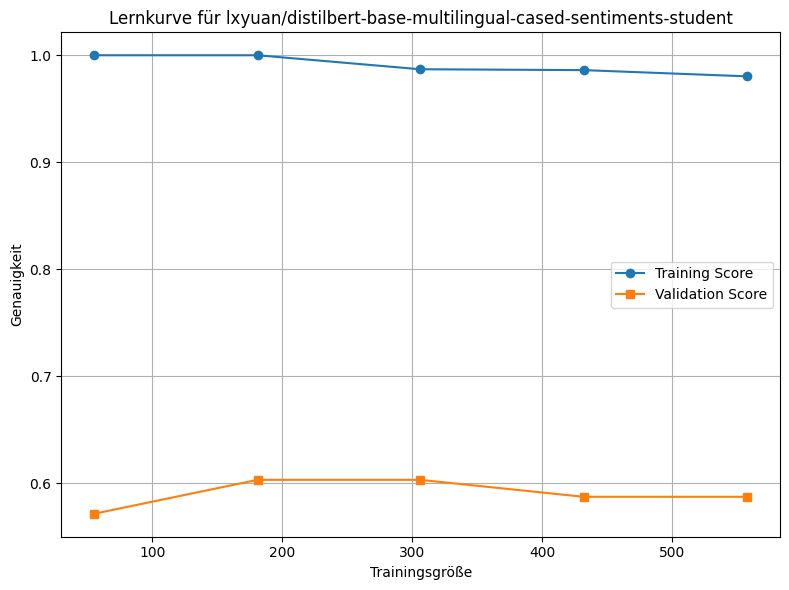

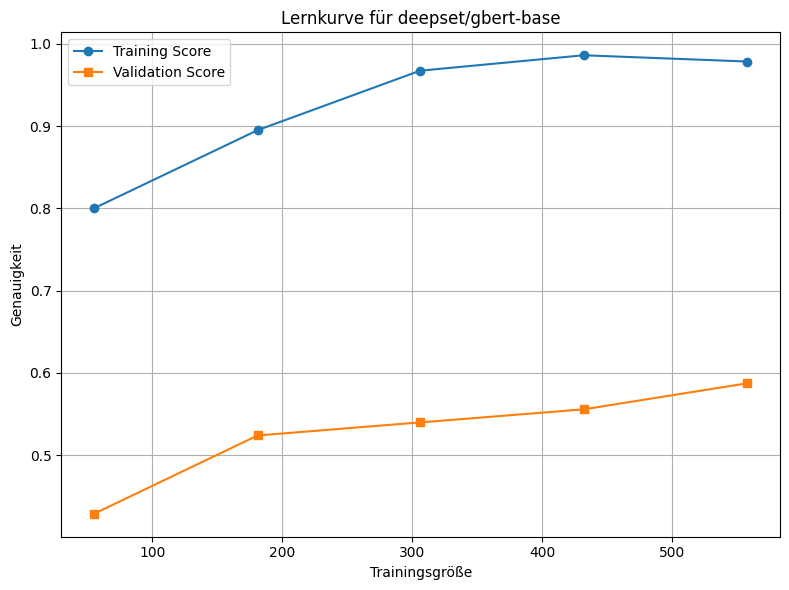

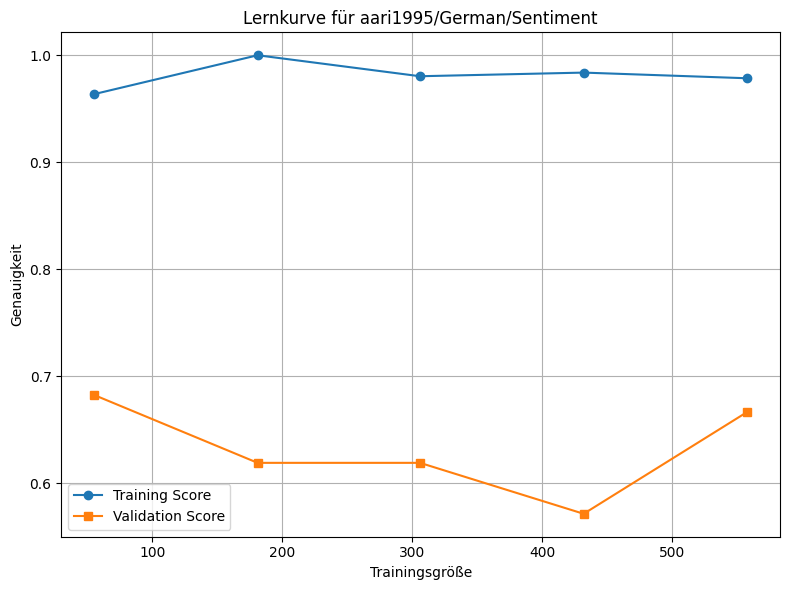

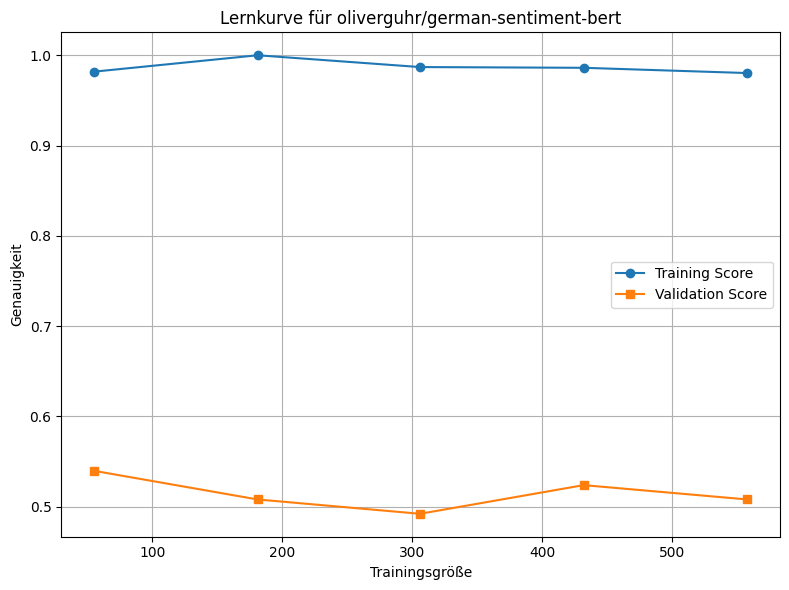

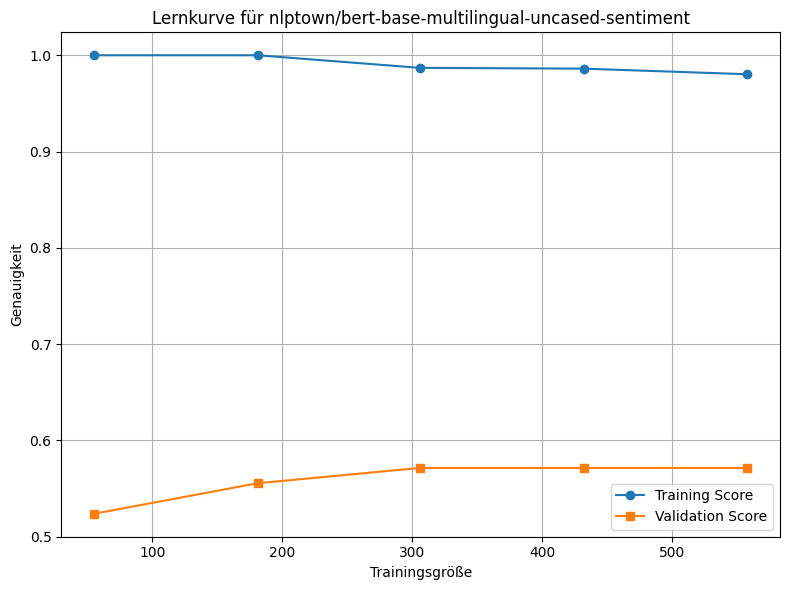

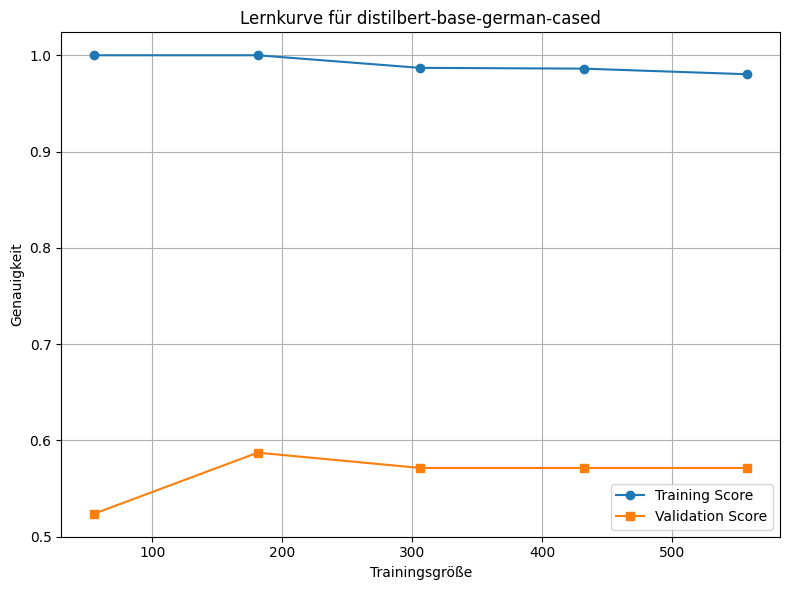

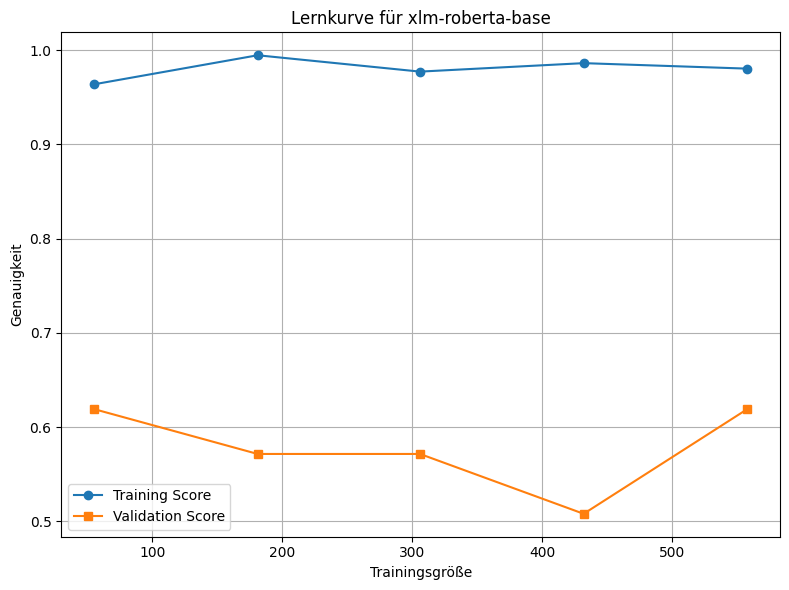

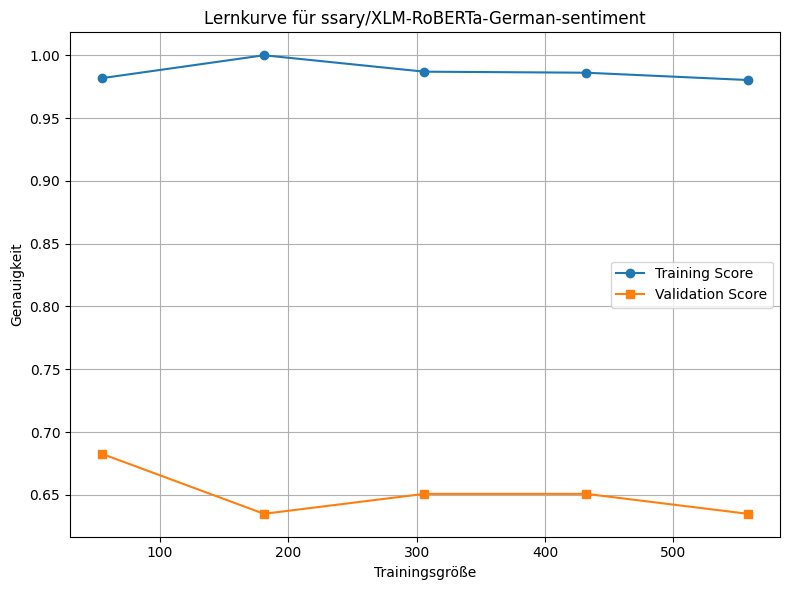

In [ ]:
import os
import json
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, Subset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Verzeichnis, in dem die Modelle gespeichert sind
saved_models_dir = '/content/drive/MyDrive/MAS DataScience/CAS_ML/saved_models'

# CSV-Datei laden (für die Validierungsdaten)
data = pd.read_csv('/content/drive/MyDrive/MAS DataScience/CAS_ML/training_data.csv')
data = data[['relevant_sentence', 'label']]
label_map = {'negativ': 0, 'neutral': 1, 'positiv': 2}
data['label'] = data['label'].map(label_map)

# Trainings- und Validierungsdaten aufteilen
train_texts, val_texts, train_labels, val_labels = train_test_split(
    data['relevant_sentence'].tolist(),
    data['label'].tolist(),
    test_size=0.1,
    random_state=42,
    stratify=data['label']
)

# Datensatzklasse definieren
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {
            key: torch.tensor(val[idx])
            for key, val in self.encodings.items()
        }
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Definiere die Metrik
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted', zero_division=1
    )
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Tokenisierung der Texte
def tokenize_texts(tokenizer, texts):
    return tokenizer(
        texts,
        truncation=True,
        padding=True,
        max_length=512
    )

# Erstelle vollständige Validierungsdaten
def create_full_validation_dataset(tokenizer):
    val_encodings = tokenize_texts(tokenizer, val_texts)
    return SentimentDataset(val_encodings, val_labels)

# Funktion zur Erstellung von Subsets
def get_train_subset(train_dataset, subset_size):
    indices = np.random.choice(len(train_dataset), subset_size, replace=False)
    return Subset(train_dataset, indices)

# Liste der gespeicherten Modelle
model_dirs = [
    os.path.join(saved_models_dir, d)
    for d in os.listdir(saved_models_dir)
    if os.path.isdir(os.path.join(saved_models_dir, d))
]

# Definiere die Trainingsgrößen (z.B. 10%, 30%, ..., 100%)
train_sizes = np.linspace(0.1, 1.0, 5)

# Ergebnisse speichern
learning_curves = {}

for model_dir in model_dirs:
    model_name = os.path.basename(model_dir).replace('_', '/')
    print(f"\n===== Verarbeite Modell: {model_name} =====")

    # Lade die Hyperparameter und Best Accuracy
    hyperparams_path = os.path.join(model_dir, 'best_hyperparams.json')
    try:
        with open(hyperparams_path, 'r') as f:
            hyperparams_data = json.load(f)
        best_params = hyperparams_data['best_params']
        best_accuracy = hyperparams_data['best_accuracy']
    except Exception as e:
        print(f"Fehler beim Laden der Hyperparameter für {model_name}: {e}")
        continue

    # Lade den Tokenizer und das Modell
    try:
        tokenizer = AutoTokenizer.from_pretrained(model_dir)
        model = AutoModelForSequenceClassification.from_pretrained(model_dir)
    except Exception as e:
        print(f"Fehler beim Laden des Modells oder Tokenizers für {model_name}: {e}")
        continue

    # Tokenisiere die Trainingsdaten
    try:
        train_encodings_full = tokenize_texts(tokenizer, train_texts)
        full_train_dataset = SentimentDataset(train_encodings_full, train_labels)
    except Exception as e:
        print(f"Fehler bei der Tokenisierung der Trainingsdaten für {model_name}: {e}")
        continue

    # Tokenisiere die Validierungsdaten
    try:
        val_dataset = create_full_validation_dataset(tokenizer)
    except Exception as e:
        print(f"Fehler bei der Tokenisierung der Validierungsdaten für {model_name}: {e}")
        continue

    # Initialisiere die Ergebnisse für dieses Modell
    learning_curves[model_name] = {
        'train_sizes': [],
        'train_scores': [],
        'val_scores': []
    }

    for size_fraction in train_sizes:
        subset_size = int(len(full_train_dataset) * size_fraction)
        if subset_size < 1:
            subset_size = 1  # Stelle sicher, dass mindestens ein Beispiel verwendet wird

        print(f"  Trainingsgröße: {subset_size} ({size_fraction*100:.0f}%)")

        # Erstelle ein Subset des Trainingsdatensatzes
        train_subset = get_train_subset(full_train_dataset, subset_size)

        # Definiere Trainingsargumente (verwende die besten Hyperparameter)
        training_args = TrainingArguments(
            output_dir='./temp_trainer',
            evaluation_strategy='no',
            save_strategy='no',
            logging_dir='./logs',
            logging_steps=10,
            per_device_train_batch_size=best_params['per_device_train_batch_size'],
            learning_rate=best_params['learning_rate'],
            num_train_epochs=best_params['num_train_epochs'],
            weight_decay=best_params['weight_decay'],
            warmup_steps=best_params['warmup_steps'],
            disable_tqdm=True,  # Vermeide übermäßige Ausgaben
        )

        # Definiere den Trainer
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_subset,
            eval_dataset=val_dataset,
            compute_metrics=compute_metrics
        )

        # Trainiere das Modell
        try:
            trainer.train()
        except Exception as e:
            print(f"Fehler beim Training für {model_name} mit Größe {subset_size}: {e}")
            continue

        # Evaluierung auf dem Trainingssubset
        try:
            train_results = trainer.evaluate(eval_dataset=train_subset)
            train_acc = train_results.get('eval_accuracy', 0)
        except Exception as e:
            print(f"Fehler bei der Evaluierung des Trainingssets für {model_name}: {e}")
            train_acc = 0

        # Evaluierung auf dem Validierungsset
        try:
            val_results = trainer.evaluate(eval_dataset=val_dataset)
            val_acc = val_results.get('eval_accuracy', 0)
        except Exception as e:
            print(f"Fehler bei der Evaluierung des Validierungssets für {model_name}: {e}")
            val_acc = 0

        # Speichere die Ergebnisse
        learning_curves[model_name]['train_sizes'].append(subset_size)
        learning_curves[model_name]['train_scores'].append(train_acc)
        learning_curves[model_name]['val_scores'].append(val_acc)

        # Optional: Bereinige temporäre Trainingsverzeichnisse
        try:
            import shutil
            shutil.rmtree('./temp_trainer')
            shutil.rmtree('./logs')
        except:
            pass

    # Entferne das Modell aus dem Speicher, um Ressourcen zu schonen
    del model
    torch.cuda.empty_cache()

# Plotten der Lernkurven pro Modell
for model_name, curves in learning_curves.items():
    plt.figure(figsize=(8, 6))

    train_sizes = curves['train_sizes']
    train_scores = curves['train_scores']
    val_scores = curves['val_scores']

    plt.plot(train_sizes, train_scores, 'o-', label='Training Score')
    plt.plot(train_sizes, val_scores, 's-', label='Validation Score')

    plt.xlabel('Trainingsgröße')
    plt.ylabel('Genauigkeit')
    plt.title(f'Lernkurve für {model_name}')
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Alle Modelle zeigen sehr starkes Overfitting. Diese Wahl, die Hyperparameter zu optimieren nach der Accuracy ist ein reinfall.

## BestParam: Eval_Loss


===== Verarbeite Modell: deepset/gbert-base =====
  Trainingsgröße: 69 (10%)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 0.8182, 'grad_norm': 11.326997756958008, 'learning_rate': 5.016795169419871e-05, 'epoch': 2.0}
{'loss': 0.337, 'grad_norm': 11.225821495056152, 'learning_rate': 5.8529276976565166e-05, 'epoch': 4.0}
{'loss': 0.0586, 'grad_norm': 0.40409591794013977, 'learning_rate': 3.901951798437678e-05, 'epoch': 6.0}
{'loss': 0.0078, 'grad_norm': 0.07704441249370575, 'learning_rate': 1.950975899218839e-05, 'epoch': 8.0}
{'loss': 0.0032, 'grad_norm': 0.06095690280199051, 'learning_rate': 0.0, 'epoch': 10.0}
{'train_runtime': 23.5972, 'train_samples_per_second': 29.241, 'train_steps_per_second': 2.119, 'train_loss': 0.24498425595462323, 'epoch': 10.0}
{'eval_loss': 0.0018115828279405832, 'eval_accuracy': 1.0, 'eval_f1': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_runtime': 0.6594, 'eval_samples_per_second': 104.642, 'eval_steps_per_second': 13.649, 'epoch': 10.0}
{'eval_loss': 1.7730425596237183, 'eval_accuracy': 0.603448275862069, 'eval_f1': 0.5853629712690116, 'eval_precision': 0.6

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.1983, 'grad_norm': 29.530414581298828, 'learning_rate': 5.016795169419871e-05, 'epoch': 0.6666666666666666}
{'loss': 0.5892, 'grad_norm': 9.51276969909668, 'learning_rate': 6.713652359076592e-05, 'epoch': 1.3333333333333333}
{'loss': 0.4472, 'grad_norm': 15.73106861114502, 'learning_rate': 6.197217562224546e-05, 'epoch': 2.0}
{'loss': 0.2449, 'grad_norm': 15.528915405273438, 'learning_rate': 5.6807827653725015e-05, 'epoch': 2.6666666666666665}
{'loss': 0.1775, 'grad_norm': 5.067333221435547, 'learning_rate': 5.164347968520456e-05, 'epoch': 3.3333333333333335}
{'loss': 0.1002, 'grad_norm': 0.5461708903312683, 'learning_rate': 4.64791317166841e-05, 'epoch': 4.0}
{'loss': 0.0627, 'grad_norm': 0.3148977756500244, 'learning_rate': 4.131478374816364e-05, 'epoch': 4.666666666666667}
{'loss': 0.0205, 'grad_norm': 0.07723134011030197, 'learning_rate': 3.615043577964318e-05, 'epoch': 5.333333333333333}
{'loss': 0.0864, 'grad_norm': 0.022969184443354607, 'learning_rate': 3.098608781112

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.0678, 'grad_norm': 34.32575607299805, 'learning_rate': 5.016795169419871e-05, 'epoch': 0.4166666666666667}
{'loss': 0.5651, 'grad_norm': 8.653940200805664, 'learning_rate': 6.837048283988142e-05, 'epoch': 0.8333333333333334}
{'loss': 0.3883, 'grad_norm': 2.667140483856201, 'learning_rate': 6.526273361988682e-05, 'epoch': 1.25}
{'loss': 0.1134, 'grad_norm': 6.757412433624268, 'learning_rate': 6.215498439989221e-05, 'epoch': 1.6666666666666665}
{'loss': 0.4082, 'grad_norm': 2.345088243484497, 'learning_rate': 5.9047235179897596e-05, 'epoch': 2.0833333333333335}
{'loss': 0.2071, 'grad_norm': 13.436189651489258, 'learning_rate': 5.593948595990299e-05, 'epoch': 2.5}
{'loss': 0.0805, 'grad_norm': 0.09649983793497086, 'learning_rate': 5.2831736739908375e-05, 'epoch': 2.9166666666666665}
{'loss': 0.1734, 'grad_norm': 1.405287742614746, 'learning_rate': 4.972398751991377e-05, 'epoch': 3.3333333333333335}
{'loss': 0.0764, 'grad_norm': 0.40468713641166687, 'learning_rate': 4.6616238299

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 0.5322, 'grad_norm': 9.048526763916016, 'learning_rate': 5.016795169419871e-05, 'epoch': 0.29411764705882354}
{'loss': 0.3892, 'grad_norm': 20.779491424560547, 'learning_rate': 6.894246122392952e-05, 'epoch': 0.5882352941176471}
{'loss': 0.3926, 'grad_norm': 1.9761489629745483, 'learning_rate': 6.678800931068171e-05, 'epoch': 0.8823529411764706}
{'loss': 0.3506, 'grad_norm': 4.51555871963501, 'learning_rate': 6.463355739743393e-05, 'epoch': 1.1764705882352942}
{'loss': 0.1517, 'grad_norm': 0.8195199966430664, 'learning_rate': 6.247910548418612e-05, 'epoch': 1.4705882352941178}
{'loss': 0.198, 'grad_norm': 9.0399751663208, 'learning_rate': 6.032465357093833e-05, 'epoch': 1.7647058823529411}
{'loss': 0.2145, 'grad_norm': 0.2198629528284073, 'learning_rate': 5.817020165769053e-05, 'epoch': 2.0588235294117645}
{'loss': 0.0895, 'grad_norm': 0.578012228012085, 'learning_rate': 5.601574974444273e-05, 'epoch': 2.3529411764705883}
{'loss': 0.1282, 'grad_norm': 1.6360511779785156, 'lear

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 0.3639, 'grad_norm': 1.5466365814208984, 'learning_rate': 5.016795169419871e-05, 'epoch': 0.22727272727272727}
{'loss': 0.364, 'grad_norm': 13.018171310424805, 'learning_rate': 6.924590515537287e-05, 'epoch': 0.45454545454545453}
{'loss': 0.5064, 'grad_norm': 15.987980842590332, 'learning_rate': 6.7597193127864e-05, 'epoch': 0.6818181818181818}
{'loss': 0.3343, 'grad_norm': 4.102181434631348, 'learning_rate': 6.594848110035511e-05, 'epoch': 0.9090909090909091}
{'loss': 0.3887, 'grad_norm': 1.9063048362731934, 'learning_rate': 6.429976907284624e-05, 'epoch': 1.1363636363636362}
{'loss': 0.1901, 'grad_norm': 5.664562702178955, 'learning_rate': 6.265105704533736e-05, 'epoch': 1.3636363636363638}
{'loss': 0.0429, 'grad_norm': 1.2690097093582153, 'learning_rate': 6.100234501782848e-05, 'epoch': 1.5909090909090908}
{'loss': 0.13, 'grad_norm': 0.5988999605178833, 'learning_rate': 5.93536329903196e-05, 'epoch': 1.8181818181818183}
{'loss': 0.2386, 'grad_norm': 6.875983715057373, 'lear

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 0.7817, 'grad_norm': 15.481612205505371, 'learning_rate': 8.882962481550987e-06, 'epoch': 1.1111111111111112}
{'train_runtime': 16.1575, 'train_samples_per_second': 8.541, 'train_steps_per_second': 1.114, 'train_loss': 0.7297785017225478, 'epoch': 2.0}
{'eval_loss': 0.40801459550857544, 'eval_accuracy': 0.8985507246376812, 'eval_f1': 0.8962929061784898, 'eval_precision': 0.9018296281723391, 'eval_recall': 0.8985507246376812, 'eval_runtime': 2.8951, 'eval_samples_per_second': 23.834, 'eval_steps_per_second': 3.109, 'epoch': 2.0}
{'eval_loss': 0.9197832942008972, 'eval_accuracy': 0.6206896551724138, 'eval_f1': 0.6204863669859985, 'eval_precision': 0.62046783625731, 'eval_recall': 0.6206896551724138, 'eval_runtime': 4.7539, 'eval_samples_per_second': 36.602, 'eval_steps_per_second': 4.628, 'epoch': 2.0}
  Trainingsgröße: 225 (32%)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 0.8399, 'grad_norm': 119.35034942626953, 'learning_rate': 8.882962481550987e-06, 'epoch': 0.3448275862068966}
{'loss': 0.747, 'grad_norm': 17.395261764526367, 'learning_rate': 1.7765924963101975e-05, 'epoch': 0.6896551724137931}
{'loss': 0.5735, 'grad_norm': 16.46600914001465, 'learning_rate': 2.6648887444652964e-05, 'epoch': 1.0344827586206897}
{'loss': 0.4737, 'grad_norm': 25.225852966308594, 'learning_rate': 1.9679178420666803e-05, 'epoch': 1.3793103448275863}
{'loss': 0.5459, 'grad_norm': 7.845048904418945, 'learning_rate': 8.746301520296358e-06, 'epoch': 1.7241379310344827}
{'train_runtime': 53.2522, 'train_samples_per_second': 8.45, 'train_steps_per_second': 1.089, 'train_loss': 0.6067705031098991, 'epoch': 2.0}
{'eval_loss': 0.23668742179870605, 'eval_accuracy': 0.9244444444444444, 'eval_f1': 0.9239219260760544, 'eval_precision': 0.9241286592530374, 'eval_recall': 0.9244444444444444, 'eval_runtime': 8.9845, 'eval_samples_per_second': 25.043, 'eval_steps_per_second': 3.2

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 0.7618, 'grad_norm': 35.068824768066406, 'learning_rate': 8.882962481550987e-06, 'epoch': 0.20833333333333334}
{'loss': 0.7004, 'grad_norm': 56.66212463378906, 'learning_rate': 1.7765924963101975e-05, 'epoch': 0.4166666666666667}
{'loss': 0.5852, 'grad_norm': 26.82051658630371, 'learning_rate': 2.6648887444652964e-05, 'epoch': 0.625}
{'loss': 0.8067, 'grad_norm': 20.082857131958008, 'learning_rate': 2.4872294948342766e-05, 'epoch': 0.8333333333333334}
{'loss': 0.6189, 'grad_norm': 26.85820770263672, 'learning_rate': 2.043081370756727e-05, 'epoch': 1.0416666666666667}
{'loss': 0.5779, 'grad_norm': 37.73181915283203, 'learning_rate': 1.5989332466791777e-05, 'epoch': 1.25}
{'loss': 0.45, 'grad_norm': 79.3388671875, 'learning_rate': 1.1547851226016284e-05, 'epoch': 1.4583333333333333}
{'loss': 0.5675, 'grad_norm': 10.966509819030762, 'learning_rate': 7.10636998524079e-06, 'epoch': 1.6666666666666665}
{'loss': 0.5559, 'grad_norm': 79.21219635009766, 'learning_rate': 2.6648887444652

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 0.546, 'grad_norm': 47.41304397583008, 'learning_rate': 8.882962481550987e-06, 'epoch': 0.14705882352941177}
{'loss': 0.3236, 'grad_norm': 51.15484619140625, 'learning_rate': 1.7765924963101975e-05, 'epoch': 0.29411764705882354}
{'loss': 0.4721, 'grad_norm': 25.143844604492188, 'learning_rate': 2.6648887444652964e-05, 'epoch': 0.4411764705882353}
{'loss': 0.6403, 'grad_norm': 35.36506652832031, 'learning_rate': 2.6238904560889075e-05, 'epoch': 0.5882352941176471}
{'loss': 0.6358, 'grad_norm': 27.65093421936035, 'learning_rate': 2.350568533579646e-05, 'epoch': 0.7352941176470589}
{'loss': 0.6039, 'grad_norm': 9.977524757385254, 'learning_rate': 2.0772466110703847e-05, 'epoch': 0.8823529411764706}
{'loss': 0.7227, 'grad_norm': 34.669578552246094, 'learning_rate': 1.8039246885611236e-05, 'epoch': 1.0294117647058822}
{'loss': 0.4941, 'grad_norm': 35.9372673034668, 'learning_rate': 1.5306027660518626e-05, 'epoch': 1.1764705882352942}
{'loss': 0.2856, 'grad_norm': 14.800968170166016

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 0.2192, 'grad_norm': 12.523868560791016, 'learning_rate': 8.882962481550987e-06, 'epoch': 0.11494252873563218}
{'loss': 0.4523, 'grad_norm': 50.48054885864258, 'learning_rate': 1.7765924963101975e-05, 'epoch': 0.22988505747126436}
{'loss': 0.4116, 'grad_norm': 10.112370491027832, 'learning_rate': 2.6648887444652964e-05, 'epoch': 0.3448275862068966}
{'loss': 0.525, 'grad_norm': 28.381847381591797, 'learning_rate': 2.6824044451331433e-05, 'epoch': 0.45977011494252873}
{'loss': 0.6601, 'grad_norm': 6.9884257316589355, 'learning_rate': 2.4822250089291775e-05, 'epoch': 0.5747126436781609}
{'loss': 0.4554, 'grad_norm': 7.041582107543945, 'learning_rate': 2.2820455727252117e-05, 'epoch': 0.6896551724137931}
{'loss': 0.3588, 'grad_norm': 55.0347785949707, 'learning_rate': 2.0818661365212456e-05, 'epoch': 0.8045977011494253}
{'loss': 0.6696, 'grad_norm': 24.050260543823242, 'learning_rate': 1.8816867003172798e-05, 'epoch': 0.9195402298850575}
{'loss': 0.4218, 'grad_norm': 9.61448287963

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.0887, 'grad_norm': 11.317299842834473, 'learning_rate': 2.034684248471282e-06, 'epoch': 1.1111111111111112}
{'loss': 1.0203, 'grad_norm': 12.439332008361816, 'learning_rate': 4.069368496942564e-06, 'epoch': 2.2222222222222223}
{'loss': 1.0518, 'grad_norm': 15.729990005493164, 'learning_rate': 6.1040527454138465e-06, 'epoch': 3.3333333333333335}
{'loss': 0.9535, 'grad_norm': 12.769086837768555, 'learning_rate': 8.138736993885129e-06, 'epoch': 4.444444444444445}
{'loss': 0.8011, 'grad_norm': 12.547557830810547, 'learning_rate': 1.0173421242356412e-05, 'epoch': 5.555555555555555}
{'loss': 0.6297, 'grad_norm': 16.906620025634766, 'learning_rate': 1.2208105490827693e-05, 'epoch': 6.666666666666667}
{'loss': 0.4961, 'grad_norm': 13.882223129272461, 'learning_rate': 1.4242789739298976e-05, 'epoch': 7.777777777777778}
{'loss': 0.3024, 'grad_norm': 25.111160278320312, 'learning_rate': 1.6277473987770257e-05, 'epoch': 8.88888888888889}
{'loss': 0.2735, 'grad_norm': 24.898380279541016,

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.23, 'grad_norm': 49.77275466918945, 'learning_rate': 2.034684248471282e-06, 'epoch': 0.3448275862068966}
{'loss': 1.222, 'grad_norm': 39.58298110961914, 'learning_rate': 4.069368496942564e-06, 'epoch': 0.6896551724137931}
{'loss': 1.082, 'grad_norm': 22.433765411376953, 'learning_rate': 6.1040527454138465e-06, 'epoch': 1.0344827586206897}
{'loss': 0.9318, 'grad_norm': 43.100101470947266, 'learning_rate': 8.138736993885129e-06, 'epoch': 1.3793103448275863}
{'loss': 0.7496, 'grad_norm': 58.71681213378906, 'learning_rate': 1.0173421242356412e-05, 'epoch': 1.7241379310344827}
{'loss': 0.9362, 'grad_norm': 20.60637855529785, 'learning_rate': 1.2208105490827693e-05, 'epoch': 2.0689655172413794}
{'loss': 0.6568, 'grad_norm': 21.434951782226562, 'learning_rate': 1.4242789739298976e-05, 'epoch': 2.413793103448276}
{'loss': 0.6034, 'grad_norm': 19.062408447265625, 'learning_rate': 1.6277473987770257e-05, 'epoch': 2.7586206896551726}
{'loss': 0.6182, 'grad_norm': 39.025455474853516, 'l

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.6754, 'grad_norm': 125.94318389892578, 'learning_rate': 2.034684248471282e-06, 'epoch': 0.20833333333333334}
{'loss': 1.2072, 'grad_norm': 56.94569396972656, 'learning_rate': 4.069368496942564e-06, 'epoch': 0.4166666666666667}
{'loss': 1.0795, 'grad_norm': 14.169726371765137, 'learning_rate': 6.1040527454138465e-06, 'epoch': 0.625}
{'loss': 0.7554, 'grad_norm': 15.75942325592041, 'learning_rate': 8.138736993885129e-06, 'epoch': 0.8333333333333334}
{'loss': 0.8231, 'grad_norm': 23.775955200195312, 'learning_rate': 1.0173421242356412e-05, 'epoch': 1.0416666666666667}
{'loss': 0.736, 'grad_norm': 0.9482026100158691, 'learning_rate': 1.2208105490827693e-05, 'epoch': 1.25}
{'loss': 0.4493, 'grad_norm': 50.56538391113281, 'learning_rate': 1.4242789739298976e-05, 'epoch': 1.4583333333333333}
{'loss': 0.7853, 'grad_norm': 89.58308410644531, 'learning_rate': 1.6277473987770257e-05, 'epoch': 1.6666666666666665}
{'loss': 0.7983, 'grad_norm': 44.04769515991211, 'learning_rate': 1.610919

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.2778, 'grad_norm': 1.3347574472427368, 'learning_rate': 2.034684248471282e-06, 'epoch': 0.14705882352941177}
{'loss': 0.797, 'grad_norm': 42.620323181152344, 'learning_rate': 4.069368496942564e-06, 'epoch': 0.29411764705882354}
{'loss': 1.0456, 'grad_norm': 90.5973892211914, 'learning_rate': 6.1040527454138465e-06, 'epoch': 0.4411764705882353}
{'loss': 1.0255, 'grad_norm': 43.22669982910156, 'learning_rate': 8.138736993885129e-06, 'epoch': 0.5882352941176471}
{'loss': 0.9314, 'grad_norm': 92.59382629394531, 'learning_rate': 1.0173421242356412e-05, 'epoch': 0.7352941176470589}
{'loss': 0.8245, 'grad_norm': 0.6091501712799072, 'learning_rate': 1.2208105490827693e-05, 'epoch': 0.8823529411764706}
{'loss': 0.6365, 'grad_norm': 78.68559265136719, 'learning_rate': 1.4242789739298976e-05, 'epoch': 1.0294117647058822}
{'loss': 0.7179, 'grad_norm': 35.571388244628906, 'learning_rate': 1.6277473987770257e-05, 'epoch': 1.1764705882352942}
{'loss': 0.3802, 'grad_norm': 58.66497421264648

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 0.4314, 'grad_norm': 6.648338317871094, 'learning_rate': 2.034684248471282e-06, 'epoch': 0.11494252873563218}
{'loss': 0.711, 'grad_norm': 16.33148765563965, 'learning_rate': 4.069368496942564e-06, 'epoch': 0.22988505747126436}
{'loss': 0.511, 'grad_norm': 145.5284881591797, 'learning_rate': 6.1040527454138465e-06, 'epoch': 0.3448275862068966}
{'loss': 0.5218, 'grad_norm': 426.09979248046875, 'learning_rate': 8.138736993885129e-06, 'epoch': 0.45977011494252873}
{'loss': 0.574, 'grad_norm': 0.06576040387153625, 'learning_rate': 1.0173421242356412e-05, 'epoch': 0.5747126436781609}
{'loss': 0.792, 'grad_norm': 2.078359365463257, 'learning_rate': 1.2208105490827693e-05, 'epoch': 0.6896551724137931}
{'loss': 0.5518, 'grad_norm': 14.450348854064941, 'learning_rate': 1.4242789739298976e-05, 'epoch': 0.8045977011494253}
{'loss': 0.5646, 'grad_norm': 13.466089248657227, 'learning_rate': 1.6277473987770257e-05, 'epoch': 0.9195402298850575}
{'loss': 0.6949, 'grad_norm': 0.361637920141220

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 0.8712, 'grad_norm': 4.014039993286133, 'learning_rate': 6.948942969820114e-06, 'epoch': 1.1111111111111112}
{'loss': 0.7836, 'grad_norm': 4.64616584777832, 'learning_rate': 1.3897885939640228e-05, 'epoch': 2.2222222222222223}
{'loss': 0.7441, 'grad_norm': 6.05155086517334, 'learning_rate': 2.084682890946034e-05, 'epoch': 3.3333333333333335}
{'loss': 0.5092, 'grad_norm': 3.8754193782806396, 'learning_rate': 2.7795771879280457e-05, 'epoch': 4.444444444444445}
{'train_runtime': 7.8291, 'train_samples_per_second': 44.066, 'train_steps_per_second': 5.748, 'train_loss': 0.6967275036705864, 'epoch': 5.0}
{'eval_loss': 0.2962419390678406, 'eval_accuracy': 0.927536231884058, 'eval_f1': 0.928064065589233, 'eval_precision': 0.9324519027036189, 'eval_recall': 0.927536231884058, 'eval_runtime': 0.422, 'eval_samples_per_second': 163.519, 'eval_steps_per_second': 21.329, 'epoch': 5.0}
{'eval_loss': 1.1821171045303345, 'eval_accuracy': 0.5287356321839081, 'eval_f1': 0.5208938400685974, 'eval

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 0.6746, 'grad_norm': 12.146464347839355, 'learning_rate': 6.948942969820114e-06, 'epoch': 0.3448275862068966}
{'loss': 0.755, 'grad_norm': 7.947154521942139, 'learning_rate': 1.3897885939640228e-05, 'epoch': 0.6896551724137931}
{'loss': 0.6043, 'grad_norm': 12.117362976074219, 'learning_rate': 2.084682890946034e-05, 'epoch': 1.0344827586206897}
{'loss': 0.4914, 'grad_norm': 13.698287010192871, 'learning_rate': 2.7795771879280457e-05, 'epoch': 1.3793103448275863}
{'loss': 0.577, 'grad_norm': 25.66119956970215, 'learning_rate': 3.474471484910057e-05, 'epoch': 1.7241379310344827}
{'loss': 0.4341, 'grad_norm': 14.251666069030762, 'learning_rate': 4.169365781892068e-05, 'epoch': 2.0689655172413794}
{'loss': 0.3539, 'grad_norm': 13.25285530090332, 'learning_rate': 4.86426007887408e-05, 'epoch': 2.413793103448276}
{'loss': 0.3419, 'grad_norm': 43.85380554199219, 'learning_rate': 5.5591543758560914e-05, 'epoch': 2.7586206896551726}
{'loss': 0.9832, 'grad_norm': 13.789855003356934, 'le

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.2332, 'grad_norm': 56.29784393310547, 'learning_rate': 6.948942969820114e-06, 'epoch': 0.20833333333333334}
{'loss': 0.8548, 'grad_norm': 20.993064880371094, 'learning_rate': 1.3897885939640228e-05, 'epoch': 0.4166666666666667}
{'loss': 0.7634, 'grad_norm': 19.8981876373291, 'learning_rate': 2.084682890946034e-05, 'epoch': 0.625}
{'loss': 0.6766, 'grad_norm': 43.02436065673828, 'learning_rate': 2.7795771879280457e-05, 'epoch': 0.8333333333333334}
{'loss': 0.4949, 'grad_norm': 22.481746673583984, 'learning_rate': 3.474471484910057e-05, 'epoch': 1.0416666666666667}
{'loss': 0.4386, 'grad_norm': 2.215851306915283, 'learning_rate': 4.169365781892068e-05, 'epoch': 1.25}
{'loss': 0.1994, 'grad_norm': 11.946721076965332, 'learning_rate': 4.86426007887408e-05, 'epoch': 1.4583333333333333}
{'loss': 0.6614, 'grad_norm': 34.39078140258789, 'learning_rate': 5.5591543758560914e-05, 'epoch': 1.6666666666666665}
{'loss': 0.5353, 'grad_norm': 20.278182983398438, 'learning_rate': 6.254048672

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 0.7891, 'grad_norm': 42.34198760986328, 'learning_rate': 6.948942969820114e-06, 'epoch': 0.14705882352941177}
{'loss': 0.6581, 'grad_norm': 31.960411071777344, 'learning_rate': 1.3897885939640228e-05, 'epoch': 0.29411764705882354}
{'loss': 0.4054, 'grad_norm': 5.530829429626465, 'learning_rate': 2.084682890946034e-05, 'epoch': 0.4411764705882353}
{'loss': 0.4114, 'grad_norm': 3.225029945373535, 'learning_rate': 2.7795771879280457e-05, 'epoch': 0.5882352941176471}
{'loss': 0.4486, 'grad_norm': 4.049956321716309, 'learning_rate': 3.474471484910057e-05, 'epoch': 0.7352941176470589}
{'loss': 0.342, 'grad_norm': 0.1997796595096588, 'learning_rate': 4.169365781892068e-05, 'epoch': 0.8823529411764706}
{'loss': 0.4121, 'grad_norm': 30.024465560913086, 'learning_rate': 4.86426007887408e-05, 'epoch': 1.0294117647058822}
{'loss': 0.2116, 'grad_norm': 4.038226127624512, 'learning_rate': 5.5591543758560914e-05, 'epoch': 1.1764705882352942}
{'loss': 0.2388, 'grad_norm': 20.152456283569336, 

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 0.386, 'grad_norm': 99.18785095214844, 'learning_rate': 6.948942969820114e-06, 'epoch': 0.11494252873563218}
{'loss': 0.6886, 'grad_norm': 8.834553718566895, 'learning_rate': 1.3897885939640228e-05, 'epoch': 0.22988505747126436}
{'loss': 0.6836, 'grad_norm': 68.23338317871094, 'learning_rate': 2.084682890946034e-05, 'epoch': 0.3448275862068966}
{'loss': 0.4886, 'grad_norm': 1.0641206502914429, 'learning_rate': 2.7795771879280457e-05, 'epoch': 0.45977011494252873}
{'loss': 0.551, 'grad_norm': 0.07387470453977585, 'learning_rate': 3.474471484910057e-05, 'epoch': 0.5747126436781609}
{'loss': 0.2493, 'grad_norm': 11.473997116088867, 'learning_rate': 4.169365781892068e-05, 'epoch': 0.6896551724137931}
{'loss': 0.3006, 'grad_norm': 12.623444557189941, 'learning_rate': 4.86426007887408e-05, 'epoch': 0.8045977011494253}
{'loss': 0.5561, 'grad_norm': 2.8562872409820557, 'learning_rate': 5.5591543758560914e-05, 'epoch': 0.9195402298850575}
{'loss': 0.4893, 'grad_norm': 0.173077628016471

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.0897, 'grad_norm': 4.136081695556641, 'learning_rate': 1.606145040610777e-07, 'epoch': 1.1111111111111112}
{'loss': 1.0588, 'grad_norm': 4.662374496459961, 'learning_rate': 3.212290081221554e-07, 'epoch': 2.2222222222222223}
{'loss': 1.0744, 'grad_norm': 5.068018436431885, 'learning_rate': 4.818435121832331e-07, 'epoch': 3.3333333333333335}
{'loss': 1.0783, 'grad_norm': 5.420356273651123, 'learning_rate': 6.424580162443108e-07, 'epoch': 4.444444444444445}
{'loss': 1.061, 'grad_norm': 4.400450229644775, 'learning_rate': 8.030725203053886e-07, 'epoch': 5.555555555555555}
{'loss': 1.0593, 'grad_norm': 3.8453457355499268, 'learning_rate': 9.636870243664662e-07, 'epoch': 6.666666666666667}
{'loss': 1.0398, 'grad_norm': 3.8732032775878906, 'learning_rate': 1.124301528427544e-06, 'epoch': 7.777777777777778}
{'loss': 1.0345, 'grad_norm': 4.301234245300293, 'learning_rate': 1.2849160324886216e-06, 'epoch': 8.88888888888889}
{'loss': 1.032, 'grad_norm': 6.916273593902588, 'learning_ra

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.0537, 'grad_norm': 4.984624862670898, 'learning_rate': 1.606145040610777e-07, 'epoch': 0.3448275862068966}
{'loss': 1.0681, 'grad_norm': 5.8714213371276855, 'learning_rate': 3.212290081221554e-07, 'epoch': 0.6896551724137931}
{'loss': 1.0298, 'grad_norm': 4.9051127433776855, 'learning_rate': 4.818435121832331e-07, 'epoch': 1.0344827586206897}
{'loss': 1.0804, 'grad_norm': 5.7149834632873535, 'learning_rate': 6.424580162443108e-07, 'epoch': 1.3793103448275863}
{'loss': 1.0351, 'grad_norm': 7.169355392456055, 'learning_rate': 8.030725203053886e-07, 'epoch': 1.7241379310344827}
{'loss': 1.0303, 'grad_norm': 6.351073265075684, 'learning_rate': 9.636870243664662e-07, 'epoch': 2.0689655172413794}
{'loss': 1.0563, 'grad_norm': 5.452531814575195, 'learning_rate': 1.124301528427544e-06, 'epoch': 2.413793103448276}
{'loss': 1.0567, 'grad_norm': 4.606490612030029, 'learning_rate': 1.2849160324886216e-06, 'epoch': 2.7586206896551726}
{'loss': 1.047, 'grad_norm': 4.373653888702393, 'lear

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 0.9422, 'grad_norm': 13.178525924682617, 'learning_rate': 1.606145040610777e-07, 'epoch': 0.20833333333333334}
{'loss': 0.888, 'grad_norm': 7.564886569976807, 'learning_rate': 3.212290081221554e-07, 'epoch': 0.4166666666666667}
{'loss': 0.8259, 'grad_norm': 10.479564666748047, 'learning_rate': 4.818435121832331e-07, 'epoch': 0.625}
{'loss': 0.825, 'grad_norm': 11.152029991149902, 'learning_rate': 6.424580162443108e-07, 'epoch': 0.8333333333333334}
{'loss': 0.8003, 'grad_norm': 10.832405090332031, 'learning_rate': 8.030725203053886e-07, 'epoch': 1.0416666666666667}
{'loss': 0.8644, 'grad_norm': 12.134020805358887, 'learning_rate': 9.636870243664662e-07, 'epoch': 1.25}
{'loss': 0.9085, 'grad_norm': 9.836524963378906, 'learning_rate': 1.124301528427544e-06, 'epoch': 1.4583333333333333}
{'loss': 0.8155, 'grad_norm': 9.15699577331543, 'learning_rate': 1.2849160324886216e-06, 'epoch': 1.6666666666666665}
{'loss': 0.9172, 'grad_norm': 9.127240180969238, 'learning_rate': 1.44553053654

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 0.7382, 'grad_norm': 18.203311920166016, 'learning_rate': 1.606145040610777e-07, 'epoch': 0.14705882352941177}
{'loss': 0.6238, 'grad_norm': 16.624929428100586, 'learning_rate': 3.212290081221554e-07, 'epoch': 0.29411764705882354}
{'loss': 0.535, 'grad_norm': 19.22114372253418, 'learning_rate': 4.818435121832331e-07, 'epoch': 0.4411764705882353}
{'loss': 0.7308, 'grad_norm': 17.600364685058594, 'learning_rate': 6.424580162443108e-07, 'epoch': 0.5882352941176471}
{'loss': 0.6812, 'grad_norm': 14.74754524230957, 'learning_rate': 8.030725203053886e-07, 'epoch': 0.7352941176470589}
{'loss': 0.7286, 'grad_norm': 25.273767471313477, 'learning_rate': 9.636870243664662e-07, 'epoch': 0.8823529411764706}
{'loss': 0.792, 'grad_norm': 16.518678665161133, 'learning_rate': 1.124301528427544e-06, 'epoch': 1.0294117647058822}
{'loss': 0.7677, 'grad_norm': 12.11935806274414, 'learning_rate': 1.2849160324886216e-06, 'epoch': 1.1764705882352942}
{'loss': 0.5589, 'grad_norm': 14.484292984008789, 

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 0.3864, 'grad_norm': 15.125547409057617, 'learning_rate': 1.606145040610777e-07, 'epoch': 0.11494252873563218}
{'loss': 0.5607, 'grad_norm': 11.194036483764648, 'learning_rate': 3.212290081221554e-07, 'epoch': 0.22988505747126436}
{'loss': 0.4547, 'grad_norm': 38.26286697387695, 'learning_rate': 4.818435121832331e-07, 'epoch': 0.3448275862068966}
{'loss': 0.56, 'grad_norm': 15.229722023010254, 'learning_rate': 6.424580162443108e-07, 'epoch': 0.45977011494252873}
{'loss': 0.743, 'grad_norm': 14.329548835754395, 'learning_rate': 8.030725203053886e-07, 'epoch': 0.5747126436781609}
{'loss': 0.6311, 'grad_norm': 15.385374069213867, 'learning_rate': 9.636870243664662e-07, 'epoch': 0.6896551724137931}
{'loss': 0.414, 'grad_norm': 19.506282806396484, 'learning_rate': 1.124301528427544e-06, 'epoch': 0.8045977011494253}
{'loss': 0.5976, 'grad_norm': 16.522180557250977, 'learning_rate': 1.2849160324886216e-06, 'epoch': 0.9195402298850575}
{'loss': 0.6984, 'grad_norm': 12.336278915405273,

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.0724, 'grad_norm': 6.031749248504639, 'learning_rate': 3.2474584830926176e-06, 'epoch': 2.0}
{'loss': 1.0802, 'grad_norm': 3.8093552589416504, 'learning_rate': 6.494916966185235e-06, 'epoch': 4.0}
{'train_runtime': 5.5651, 'train_samples_per_second': 61.994, 'train_steps_per_second': 4.492, 'train_loss': 1.0727811431884766, 'epoch': 5.0}
{'eval_loss': 1.0450141429901123, 'eval_accuracy': 0.5652173913043478, 'eval_f1': 0.5530533027681994, 'eval_precision': 0.5997373892110734, 'eval_recall': 0.5652173913043478, 'eval_runtime': 0.3961, 'eval_samples_per_second': 174.218, 'eval_steps_per_second': 22.724, 'epoch': 5.0}
{'eval_loss': 1.0741525888442993, 'eval_accuracy': 0.4367816091954023, 'eval_f1': 0.426501240694789, 'eval_precision': 0.43562939271894496, 'eval_recall': 0.4367816091954023, 'eval_runtime': 0.6658, 'eval_samples_per_second': 261.348, 'eval_steps_per_second': 33.044, 'epoch': 5.0}
  Trainingsgröße: 225 (32%)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.0648, 'grad_norm': 1.9517902135849, 'learning_rate': 3.2474584830926176e-06, 'epoch': 0.6666666666666666}
{'loss': 1.0488, 'grad_norm': 3.8785359859466553, 'learning_rate': 6.494916966185235e-06, 'epoch': 1.3333333333333333}
{'loss': 1.0445, 'grad_norm': 11.001465797424316, 'learning_rate': 9.742375449277853e-06, 'epoch': 2.0}
{'loss': 1.0292, 'grad_norm': 2.651383876800537, 'learning_rate': 1.298983393237047e-05, 'epoch': 2.6666666666666665}
{'loss': 0.9861, 'grad_norm': 4.289170742034912, 'learning_rate': 1.6237292415463087e-05, 'epoch': 3.3333333333333335}
{'loss': 0.9124, 'grad_norm': 20.058115005493164, 'learning_rate': 1.9484750898555705e-05, 'epoch': 4.0}
{'loss': 0.8341, 'grad_norm': 6.093085765838623, 'learning_rate': 2.2732209381648326e-05, 'epoch': 4.666666666666667}
{'train_runtime': 18.3193, 'train_samples_per_second': 61.411, 'train_steps_per_second': 4.094, 'train_loss': 0.9776505851745605, 'epoch': 5.0}
{'eval_loss': 0.6810608506202698, 'eval_accuracy': 0.782

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 0.9118, 'grad_norm': 4.282742500305176, 'learning_rate': 3.2474584830926176e-06, 'epoch': 0.4166666666666667}
{'loss': 0.7394, 'grad_norm': 3.7836742401123047, 'learning_rate': 6.494916966185235e-06, 'epoch': 0.8333333333333334}
{'loss': 0.8051, 'grad_norm': 4.208165645599365, 'learning_rate': 9.742375449277853e-06, 'epoch': 1.25}
{'loss': 0.7709, 'grad_norm': 5.020321369171143, 'learning_rate': 1.298983393237047e-05, 'epoch': 1.6666666666666665}
{'loss': 0.7763, 'grad_norm': 9.835686683654785, 'learning_rate': 1.6237292415463087e-05, 'epoch': 2.0833333333333335}
{'loss': 0.7484, 'grad_norm': 6.353537082672119, 'learning_rate': 1.9484750898555705e-05, 'epoch': 2.5}
{'loss': 0.653, 'grad_norm': 5.376651287078857, 'learning_rate': 2.2732209381648326e-05, 'epoch': 2.9166666666666665}
{'loss': 0.6329, 'grad_norm': 6.064188480377197, 'learning_rate': 2.597966786474094e-05, 'epoch': 3.3333333333333335}
{'loss': 0.5389, 'grad_norm': 5.329725742340088, 'learning_rate': 2.9227126347833

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 0.4232, 'grad_norm': 7.5272440910339355, 'learning_rate': 3.2474584830926176e-06, 'epoch': 0.29411764705882354}
{'loss': 0.5103, 'grad_norm': 9.656633377075195, 'learning_rate': 6.494916966185235e-06, 'epoch': 0.5882352941176471}
{'loss': 0.4965, 'grad_norm': 8.428905487060547, 'learning_rate': 9.742375449277853e-06, 'epoch': 0.8823529411764706}
{'loss': 0.527, 'grad_norm': 6.509770393371582, 'learning_rate': 1.298983393237047e-05, 'epoch': 1.1764705882352942}
{'loss': 0.3502, 'grad_norm': 12.500252723693848, 'learning_rate': 1.6237292415463087e-05, 'epoch': 1.4705882352941178}
{'loss': 0.4054, 'grad_norm': 12.029742240905762, 'learning_rate': 1.9484750898555705e-05, 'epoch': 1.7647058823529411}
{'loss': 0.4146, 'grad_norm': 9.360689163208008, 'learning_rate': 2.2732209381648326e-05, 'epoch': 2.0588235294117645}
{'loss': 0.2881, 'grad_norm': 20.184993743896484, 'learning_rate': 2.597966786474094e-05, 'epoch': 2.3529411764705883}
{'loss': 0.4215, 'grad_norm': 11.280149459838867

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 0.4347, 'grad_norm': 20.634443283081055, 'learning_rate': 3.2474584830926176e-06, 'epoch': 0.22727272727272727}
{'loss': 0.4155, 'grad_norm': 16.45388412475586, 'learning_rate': 6.494916966185235e-06, 'epoch': 0.45454545454545453}
{'loss': 0.4391, 'grad_norm': 27.6813907623291, 'learning_rate': 9.742375449277853e-06, 'epoch': 0.6818181818181818}
{'loss': 0.4453, 'grad_norm': 6.96828031539917, 'learning_rate': 1.298983393237047e-05, 'epoch': 0.9090909090909091}
{'loss': 0.5017, 'grad_norm': 12.662281036376953, 'learning_rate': 1.6237292415463087e-05, 'epoch': 1.1363636363636362}
{'loss': 0.3129, 'grad_norm': 15.416813850402832, 'learning_rate': 1.9484750898555705e-05, 'epoch': 1.3636363636363638}
{'loss': 0.221, 'grad_norm': 8.492753982543945, 'learning_rate': 2.2732209381648326e-05, 'epoch': 1.5909090909090908}
{'loss': 0.3993, 'grad_norm': 11.909818649291992, 'learning_rate': 2.597966786474094e-05, 'epoch': 1.8181818181818183}
{'loss': 0.3992, 'grad_norm': 26.41012191772461, 

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.0596, 'grad_norm': 5.774229526519775, 'learning_rate': 2.2191292976793004e-06, 'epoch': 1.1111111111111112}
{'loss': 1.0572, 'grad_norm': 8.31283950805664, 'learning_rate': 4.438258595358601e-06, 'epoch': 2.2222222222222223}
{'loss': 1.0497, 'grad_norm': 9.034728050231934, 'learning_rate': 6.6573878930379005e-06, 'epoch': 3.3333333333333335}
{'loss': 0.9923, 'grad_norm': 11.0521879196167, 'learning_rate': 8.876517190717202e-06, 'epoch': 4.444444444444445}
{'train_runtime': 15.9694, 'train_samples_per_second': 21.604, 'train_steps_per_second': 2.818, 'train_loss': 1.0304760932922363, 'epoch': 5.0}
{'eval_loss': 0.9264949560165405, 'eval_accuracy': 0.5652173913043478, 'eval_f1': 0.5380979641849207, 'eval_precision': 0.5991074584658891, 'eval_recall': 0.5652173913043478, 'eval_runtime': 0.7936, 'eval_samples_per_second': 86.941, 'eval_steps_per_second': 11.34, 'epoch': 5.0}
{'eval_loss': 1.1012340784072876, 'eval_accuracy': 0.39655172413793105, 'eval_f1': 0.30736625514403293, '

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.0669, 'grad_norm': 9.211094856262207, 'learning_rate': 2.2191292976793004e-06, 'epoch': 0.3448275862068966}
{'loss': 1.0467, 'grad_norm': 6.844637393951416, 'learning_rate': 4.438258595358601e-06, 'epoch': 0.6896551724137931}
{'loss': 0.9758, 'grad_norm': 25.70221519470215, 'learning_rate': 6.6573878930379005e-06, 'epoch': 1.0344827586206897}
{'loss': 0.9724, 'grad_norm': 14.986490249633789, 'learning_rate': 8.876517190717202e-06, 'epoch': 1.3793103448275863}
{'loss': 0.95, 'grad_norm': 20.554473876953125, 'learning_rate': 1.1095646488396502e-05, 'epoch': 1.7241379310344827}
{'loss': 0.9708, 'grad_norm': 31.549551010131836, 'learning_rate': 1.3314775786075801e-05, 'epoch': 2.0689655172413794}
{'loss': 0.8838, 'grad_norm': 35.11283493041992, 'learning_rate': 1.5533905083755103e-05, 'epoch': 2.413793103448276}
{'loss': 0.8676, 'grad_norm': 20.579940795898438, 'learning_rate': 1.7753034381434404e-05, 'epoch': 2.7586206896551726}
{'loss': 0.9274, 'grad_norm': 23.72296905517578, 

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.187, 'grad_norm': 12.469597816467285, 'learning_rate': 2.2191292976793004e-06, 'epoch': 0.20833333333333334}
{'loss': 0.9421, 'grad_norm': 11.131521224975586, 'learning_rate': 4.438258595358601e-06, 'epoch': 0.4166666666666667}
{'loss': 0.8532, 'grad_norm': 34.317955017089844, 'learning_rate': 6.6573878930379005e-06, 'epoch': 0.625}
{'loss': 0.7687, 'grad_norm': 10.715422630310059, 'learning_rate': 8.876517190717202e-06, 'epoch': 0.8333333333333334}
{'loss': 0.8338, 'grad_norm': 15.29847240447998, 'learning_rate': 1.1095646488396502e-05, 'epoch': 1.0416666666666667}
{'loss': 0.6918, 'grad_norm': 25.06151008605957, 'learning_rate': 1.3314775786075801e-05, 'epoch': 1.25}
{'loss': 0.6907, 'grad_norm': 11.285730361938477, 'learning_rate': 1.5533905083755103e-05, 'epoch': 1.4583333333333333}
{'loss': 0.8235, 'grad_norm': 12.727932929992676, 'learning_rate': 1.7753034381434404e-05, 'epoch': 1.6666666666666665}
{'loss': 0.8007, 'grad_norm': 21.974895477294922, 'learning_rate': 1.99

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 0.7816, 'grad_norm': 3.9472720623016357, 'learning_rate': 2.2191292976793004e-06, 'epoch': 0.14705882352941177}
{'loss': 0.3381, 'grad_norm': 44.89033508300781, 'learning_rate': 4.438258595358601e-06, 'epoch': 0.29411764705882354}
{'loss': 0.3296, 'grad_norm': 8.3269624710083, 'learning_rate': 6.6573878930379005e-06, 'epoch': 0.4411764705882353}
{'loss': 0.6203, 'grad_norm': 57.6746711730957, 'learning_rate': 8.876517190717202e-06, 'epoch': 0.5882352941176471}
{'loss': 0.5093, 'grad_norm': 16.738727569580078, 'learning_rate': 1.1095646488396502e-05, 'epoch': 0.7352941176470589}
{'loss': 0.5663, 'grad_norm': 12.18004035949707, 'learning_rate': 1.3314775786075801e-05, 'epoch': 0.8823529411764706}
{'loss': 0.5548, 'grad_norm': 2.9493515491485596, 'learning_rate': 1.5533905083755103e-05, 'epoch': 1.0294117647058822}
{'loss': 0.5858, 'grad_norm': 59.34763717651367, 'learning_rate': 1.7753034381434404e-05, 'epoch': 1.1764705882352942}
{'loss': 0.3347, 'grad_norm': 13.903443336486816

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 0.2912, 'grad_norm': 5.036594867706299, 'learning_rate': 2.2191292976793004e-06, 'epoch': 0.11494252873563218}
{'loss': 0.6584, 'grad_norm': 12.57236385345459, 'learning_rate': 4.438258595358601e-06, 'epoch': 0.22988505747126436}
{'loss': 0.4553, 'grad_norm': 161.77554321289062, 'learning_rate': 6.6573878930379005e-06, 'epoch': 0.3448275862068966}
{'loss': 0.546, 'grad_norm': 12.409872055053711, 'learning_rate': 8.876517190717202e-06, 'epoch': 0.45977011494252873}
{'loss': 0.6277, 'grad_norm': 0.2555775046348572, 'learning_rate': 1.1095646488396502e-05, 'epoch': 0.5747126436781609}
{'loss': 0.8661, 'grad_norm': 21.32677459716797, 'learning_rate': 1.3314775786075801e-05, 'epoch': 0.6896551724137931}
{'loss': 0.4622, 'grad_norm': 32.31769561767578, 'learning_rate': 1.5533905083755103e-05, 'epoch': 0.8045977011494253}
{'loss': 0.4905, 'grad_norm': 3.6520636081695557, 'learning_rate': 1.7753034381434404e-05, 'epoch': 0.9195402298850575}
{'loss': 0.6425, 'grad_norm': 2.078555822372

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 2.4854, 'grad_norm': 88.91780853271484, 'learning_rate': 8.90395865512533e-08, 'epoch': 2.0}
{'loss': 2.4461, 'grad_norm': 76.55394744873047, 'learning_rate': 1.780791731025066e-07, 'epoch': 4.0}
{'loss': 2.2772, 'grad_norm': 87.79759979248047, 'learning_rate': 2.671187596537599e-07, 'epoch': 6.0}
{'loss': 2.1825, 'grad_norm': 105.02095794677734, 'learning_rate': 3.561583462050132e-07, 'epoch': 8.0}
{'loss': 2.1101, 'grad_norm': 78.86209869384766, 'learning_rate': 4.4519793275626654e-07, 'epoch': 10.0}
{'train_runtime': 27.667, 'train_samples_per_second': 24.939, 'train_steps_per_second': 1.807, 'train_loss': 2.300253219604492, 'epoch': 10.0}
{'eval_loss': 2.101270914077759, 'eval_accuracy': 0.4782608695652174, 'eval_f1': 0.47047790500512865, 'eval_precision': 0.5462082912032356, 'eval_recall': 0.4782608695652174, 'eval_runtime': 0.8329, 'eval_samples_per_second': 82.845, 'eval_steps_per_second': 10.806, 'epoch': 10.0}
{'eval_loss': 2.4099349975585938, 'eval_accuracy': 0.33333

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.8656, 'grad_norm': 27.467784881591797, 'learning_rate': 8.90395865512533e-08, 'epoch': 0.6666666666666666}
{'loss': 1.928, 'grad_norm': 63.708221435546875, 'learning_rate': 1.780791731025066e-07, 'epoch': 1.3333333333333333}
{'loss': 1.5888, 'grad_norm': 6.307380676269531, 'learning_rate': 2.671187596537599e-07, 'epoch': 2.0}
{'loss': 1.915, 'grad_norm': 41.00300979614258, 'learning_rate': 3.561583462050132e-07, 'epoch': 2.6666666666666665}
{'loss': 1.7848, 'grad_norm': 51.928672790527344, 'learning_rate': 4.4519793275626654e-07, 'epoch': 3.3333333333333335}
{'loss': 1.4602, 'grad_norm': 60.63929748535156, 'learning_rate': 5.342375193075198e-07, 'epoch': 4.0}
{'loss': 1.5328, 'grad_norm': 29.20277214050293, 'learning_rate': 6.232771058587731e-07, 'epoch': 4.666666666666667}
{'loss': 1.2353, 'grad_norm': 22.584543228149414, 'learning_rate': 7.123166924100264e-07, 'epoch': 5.333333333333333}
{'loss': 1.4409, 'grad_norm': 151.82467651367188, 'learning_rate': 8.013562789612798e-

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.2247, 'grad_norm': 14.689638137817383, 'learning_rate': 8.90395865512533e-08, 'epoch': 0.4166666666666667}
{'loss': 1.1677, 'grad_norm': 19.48548698425293, 'learning_rate': 1.780791731025066e-07, 'epoch': 0.8333333333333334}
{'loss': 1.1456, 'grad_norm': 10.345168113708496, 'learning_rate': 2.671187596537599e-07, 'epoch': 1.25}
{'loss': 1.1927, 'grad_norm': 12.291792869567871, 'learning_rate': 3.561583462050132e-07, 'epoch': 1.6666666666666665}
{'loss': 1.1383, 'grad_norm': 13.27733039855957, 'learning_rate': 4.4519793275626654e-07, 'epoch': 2.0833333333333335}
{'loss': 1.1973, 'grad_norm': 15.843238830566406, 'learning_rate': 5.342375193075198e-07, 'epoch': 2.5}
{'loss': 1.1089, 'grad_norm': 17.164464950561523, 'learning_rate': 6.232771058587731e-07, 'epoch': 2.9166666666666665}
{'loss': 1.1295, 'grad_norm': 10.581926345825195, 'learning_rate': 7.123166924100264e-07, 'epoch': 3.3333333333333335}
{'loss': 1.1167, 'grad_norm': 16.96778678894043, 'learning_rate': 8.01356278961

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 0.9638, 'grad_norm': 9.430370330810547, 'learning_rate': 8.90395865512533e-08, 'epoch': 0.29411764705882354}
{'loss': 0.9869, 'grad_norm': 16.021745681762695, 'learning_rate': 1.780791731025066e-07, 'epoch': 0.5882352941176471}
{'loss': 0.9312, 'grad_norm': 8.618199348449707, 'learning_rate': 2.671187596537599e-07, 'epoch': 0.8823529411764706}
{'loss': 0.9275, 'grad_norm': 9.52734661102295, 'learning_rate': 3.561583462050132e-07, 'epoch': 1.1764705882352942}
{'loss': 0.96, 'grad_norm': 14.0011568069458, 'learning_rate': 4.4519793275626654e-07, 'epoch': 1.4705882352941178}
{'loss': 0.9915, 'grad_norm': 12.11682415008545, 'learning_rate': 5.342375193075198e-07, 'epoch': 1.7647058823529411}
{'loss': 1.0039, 'grad_norm': 17.63854217529297, 'learning_rate': 6.232771058587731e-07, 'epoch': 2.0588235294117645}
{'loss': 0.9397, 'grad_norm': 9.294151306152344, 'learning_rate': 7.123166924100264e-07, 'epoch': 2.3529411764705883}
{'loss': 1.014, 'grad_norm': 12.049904823303223, 'learning

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 0.7613, 'grad_norm': 12.454319953918457, 'learning_rate': 8.90395865512533e-08, 'epoch': 0.22727272727272727}
{'loss': 0.7821, 'grad_norm': 13.82132339477539, 'learning_rate': 1.780791731025066e-07, 'epoch': 0.45454545454545453}
{'loss': 0.9359, 'grad_norm': 21.52431297302246, 'learning_rate': 2.671187596537599e-07, 'epoch': 0.6818181818181818}
{'loss': 0.7721, 'grad_norm': 18.74031639099121, 'learning_rate': 3.561583462050132e-07, 'epoch': 0.9090909090909091}
{'loss': 0.7938, 'grad_norm': 11.196499824523926, 'learning_rate': 4.4519793275626654e-07, 'epoch': 1.1363636363636362}
{'loss': 0.8814, 'grad_norm': 11.324789047241211, 'learning_rate': 5.342375193075198e-07, 'epoch': 1.3636363636363638}
{'loss': 0.8148, 'grad_norm': 14.055070877075195, 'learning_rate': 6.232771058587731e-07, 'epoch': 1.5909090909090908}
{'loss': 0.7423, 'grad_norm': 9.927578926086426, 'learning_rate': 7.123166924100264e-07, 'epoch': 1.8181818181818183}
{'loss': 0.831, 'grad_norm': 26.037517547607422, '

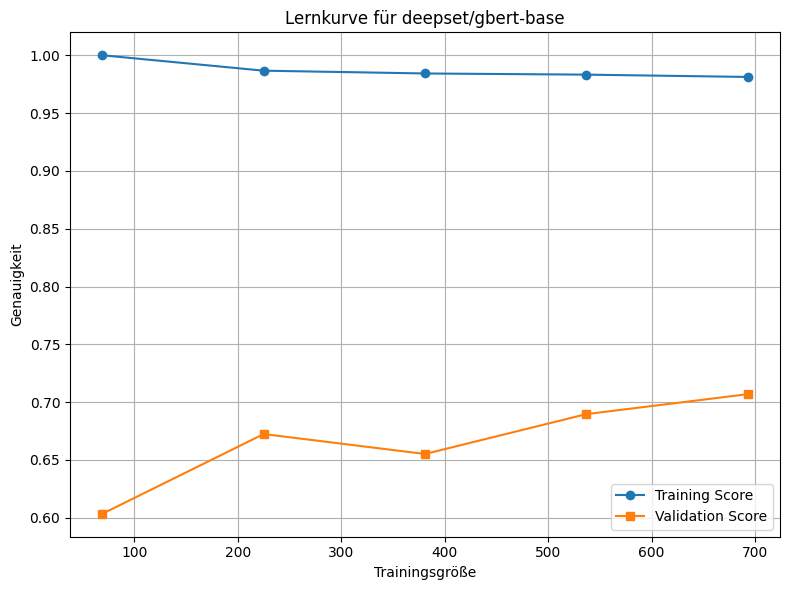

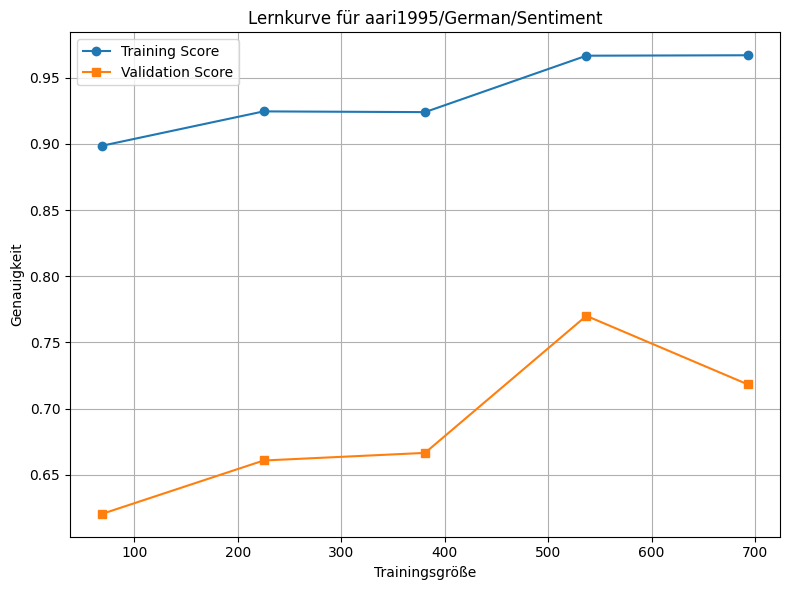

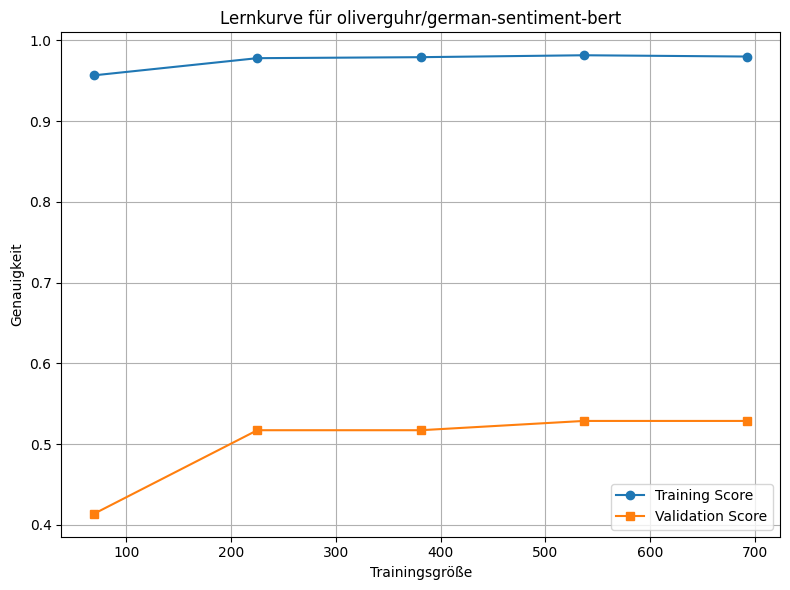

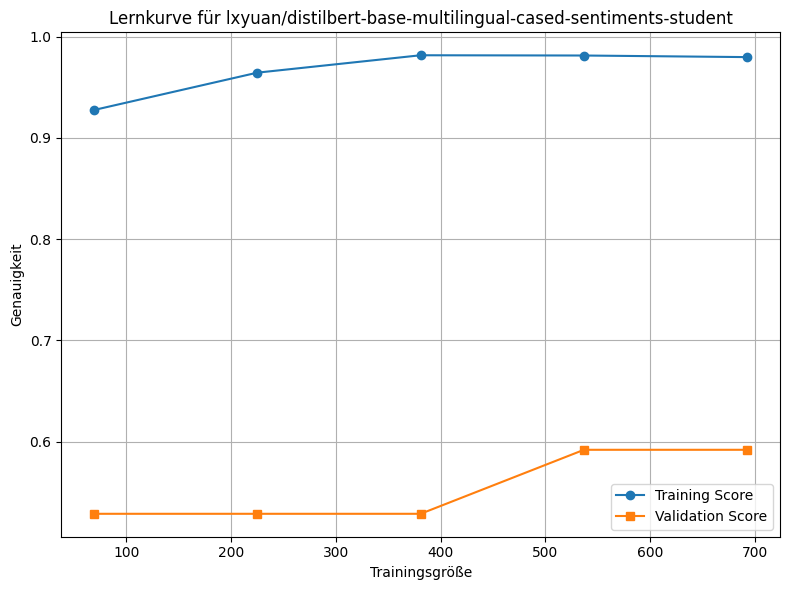

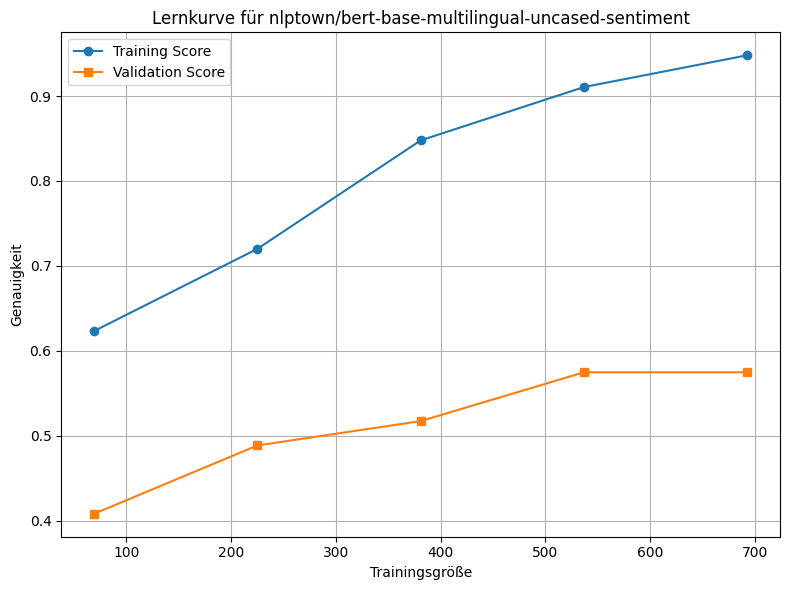

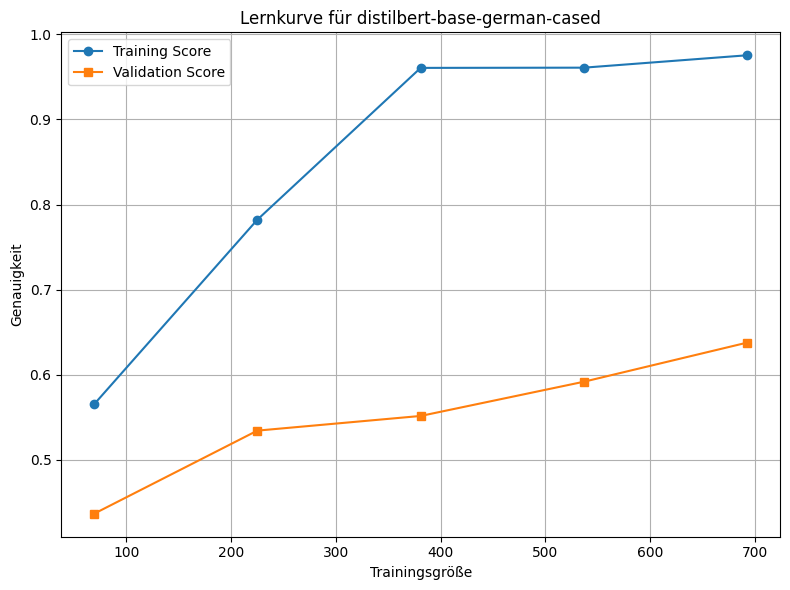

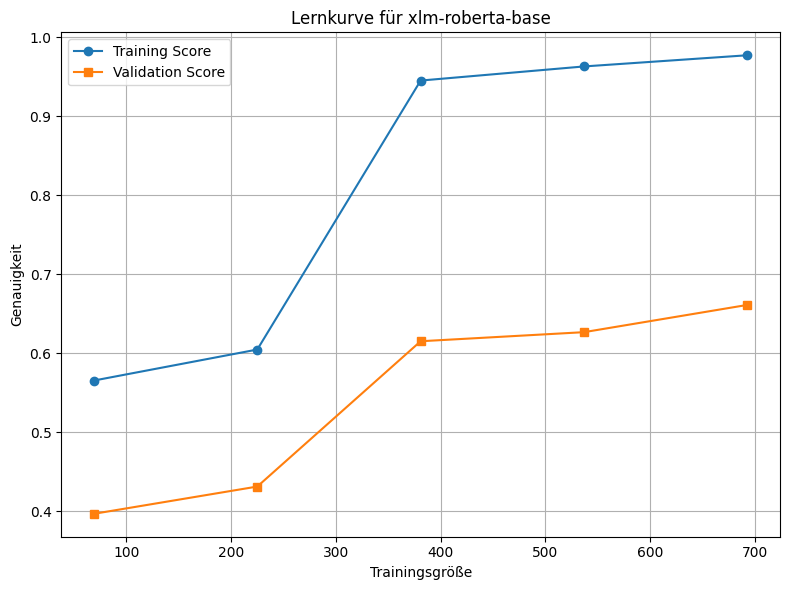

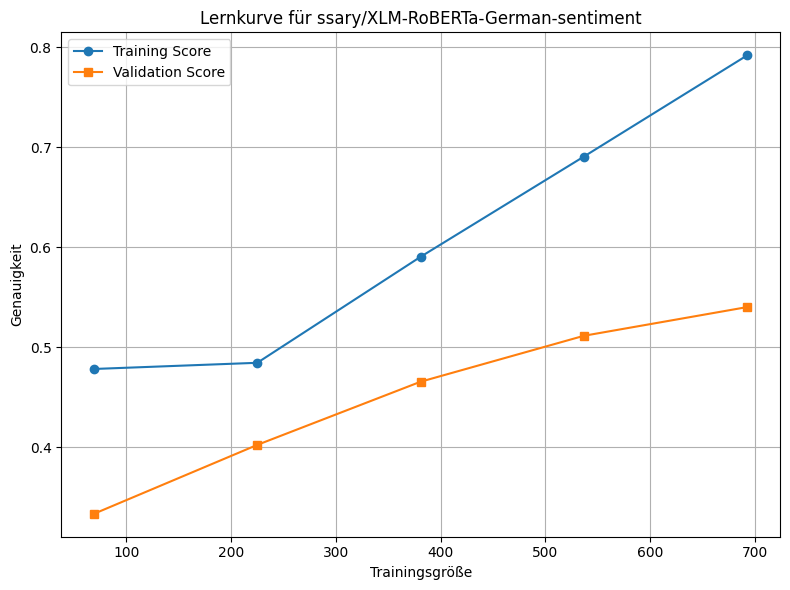

In [ ]:
import os
import json
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, Subset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Verzeichnis, in dem die Modelle gespeichert sind
saved_models_dir = '/content/drive/MyDrive/MAS DataScience/CAS_ML/saved_models_eval_loss'

# CSV-Datei laden (für die Validierungsdaten)
data = pd.read_csv('/content/drive/MyDrive/MAS DataScience/CAS_ML/training_data.csv')
data = data[['relevant_sentence', 'label']]
label_map = {'negativ': 0, 'neutral': 1, 'positiv': 2}
data['label'] = data['label'].map(label_map)

# Trainings- und Validierungsdaten aufteilen
train_texts, val_texts, train_labels, val_labels = train_test_split(
    data['relevant_sentence'].tolist(),
    data['label'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=data['label']
)

# Datensatzklasse definieren
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {
            key: torch.tensor(val[idx])
            for key, val in self.encodings.items()
        }
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Definiere die Metrik
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted', zero_division=1
    )
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Tokenisierung der Texte
def tokenize_texts(tokenizer, texts):
    return tokenizer(
        texts,
        truncation=True,
        padding=True,
        max_length=512
    )

# Erstelle vollständige Validierungsdaten
def create_full_validation_dataset(tokenizer):
    val_encodings = tokenize_texts(tokenizer, val_texts)
    return SentimentDataset(val_encodings, val_labels)

# Funktion zur Erstellung von Subsets
def get_train_subset(train_dataset, subset_size):
    indices = np.random.choice(len(train_dataset), subset_size, replace=False)
    return Subset(train_dataset, indices)

# Liste der gespeicherten Modelle
model_dirs = [
    os.path.join(saved_models_dir, d)
    for d in os.listdir(saved_models_dir)
    if os.path.isdir(os.path.join(saved_models_dir, d))
]

# Definiere die Trainingsgrößen (z.B. 10%, 30%, ..., 100%)
train_sizes = np.linspace(0.1, 1.0, 5)

# Ergebnisse speichern
learning_curves = {}

for model_dir in model_dirs:
    model_name = os.path.basename(model_dir).replace('_', '/')
    print(f"\n===== Verarbeite Modell: {model_name} =====")

    # Lade die Hyperparameter und Best Accuracy
    hyperparams_path = os.path.join(model_dir, 'best_hyperparams.json')
    try:
        with open(hyperparams_path, 'r') as f:
            hyperparams_data = json.load(f)
        best_params = hyperparams_data['best_params']
        best_accuracy = hyperparams_data['best_accuracy']
    except Exception as e:
        print(f"Fehler beim Laden der Hyperparameter für {model_name}: {e}")
        continue

    # Lade den Tokenizer und das Modell
    try:
        tokenizer = AutoTokenizer.from_pretrained(model_dir)
        model = AutoModelForSequenceClassification.from_pretrained(model_dir)
    except Exception as e:
        print(f"Fehler beim Laden des Modells oder Tokenizers für {model_name}: {e}")
        continue

    # Tokenisiere die Trainingsdaten
    try:
        train_encodings_full = tokenize_texts(tokenizer, train_texts)
        full_train_dataset = SentimentDataset(train_encodings_full, train_labels)
    except Exception as e:
        print(f"Fehler bei der Tokenisierung der Trainingsdaten für {model_name}: {e}")
        continue

    # Tokenisiere die Validierungsdaten
    try:
        val_dataset = create_full_validation_dataset(tokenizer)
    except Exception as e:
        print(f"Fehler bei der Tokenisierung der Validierungsdaten für {model_name}: {e}")
        continue

    # Initialisiere die Ergebnisse für dieses Modell
    learning_curves[model_name] = {
        'train_sizes': [],
        'train_scores': [],
        'val_scores': []
    }

    for size_fraction in train_sizes:
        subset_size = int(len(full_train_dataset) * size_fraction)
        if subset_size < 1:
            subset_size = 1  # Stelle sicher, dass mindestens ein Beispiel verwendet wird

        print(f"  Trainingsgröße: {subset_size} ({size_fraction*100:.0f}%)")

        # Erstelle ein Subset des Trainingsdatensatzes
        train_subset = get_train_subset(full_train_dataset, subset_size)

        # Definiere Trainingsargumente (verwende die besten Hyperparameter)
        training_args = TrainingArguments(
            output_dir='./temp_trainer',
            evaluation_strategy='no',
            save_strategy='no',
            logging_dir='./logs',
            logging_steps=10,
            per_device_train_batch_size=best_params['per_device_train_batch_size'],
            learning_rate=best_params['learning_rate'],
            num_train_epochs=best_params['num_train_epochs'],
            weight_decay=best_params['weight_decay'],
            warmup_steps=best_params['warmup_steps'],
            disable_tqdm=True,  # Vermeide übermäßige Ausgaben
        )

        # Definiere den Trainer
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_subset,
            eval_dataset=val_dataset,
            compute_metrics=compute_metrics
        )

        # Trainiere das Modell
        try:
            trainer.train()
        except Exception as e:
            print(f"Fehler beim Training für {model_name} mit Größe {subset_size}: {e}")
            continue

        # Evaluierung auf dem Trainingssubset
        try:
            train_results = trainer.evaluate(eval_dataset=train_subset)
            train_acc = train_results.get('eval_accuracy', 0)
        except Exception as e:
            print(f"Fehler bei der Evaluierung des Trainingssets für {model_name}: {e}")
            train_acc = 0

        # Evaluierung auf dem Validierungsset
        try:
            val_results = trainer.evaluate(eval_dataset=val_dataset)
            val_acc = val_results.get('eval_accuracy', 0)
        except Exception as e:
            print(f"Fehler bei der Evaluierung des Validierungssets für {model_name}: {e}")
            val_acc = 0

        # Speichere die Ergebnisse
        learning_curves[model_name]['train_sizes'].append(subset_size)
        learning_curves[model_name]['train_scores'].append(train_acc)
        learning_curves[model_name]['val_scores'].append(val_acc)

        # Optional: Bereinige temporäre Trainingsverzeichnisse
        try:
            import shutil
            shutil.rmtree('./temp_trainer')
            shutil.rmtree('./logs')
        except:
            pass

    # Entferne das Modell aus dem Speicher, um Ressourcen zu schonen
    del model
    torch.cuda.empty_cache()

# Plotten der Lernkurven pro Modell
for model_name, curves in learning_curves.items():
    plt.figure(figsize=(8, 6))

    train_sizes = curves['train_sizes']
    train_scores = curves['train_scores']
    val_scores = curves['val_scores']

    plt.plot(train_sizes, train_scores, 'o-', label='Training Score')
    plt.plot(train_sizes, val_scores, 's-', label='Validation Score')

    plt.xlabel('Trainingsgröße')
    plt.ylabel('Genauigkeit')
    plt.title(f'Lernkurve für {model_name}')
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Fazit
Nachdem ich die Modelle auf zwei Arten genaustens unter die Lupen genommen habe, möchte ich hier kurz festhalten, welche beiden "Gewinner" je Art ich gewählt habe.
   * **ACCURACY**
     * xlm-roberta-base
     * deepset/gbert-base

   * **EVAL_LOSS**
     * ssary/XLM-RoBERTa-German-sentiment

Abschliessen ist für mich klar, die **eval_loss Strategie** hat in meinem Fall einen viel höheren Nutzen. Auch implizit gegeben: **zusätzliche Trainings-Daten** müssen erarbeitet werden